### Clustering and KEGG analysis

Input files:<br>
Anndata SPF/GF: anndata_hm_norm_all_de_genes_n_Feb2022.h5ad<br>
Single cell data files: mli_zscore_norm_scaled_all_pheno_log.csv<br>
Raster files: raster_GF_6w.png, raster_WT_6w.png, raster_whole_tissue_GF_6w.png, raster_whole_tissue_WT_6w.png<br>
Gene IDs: gene_ids.txt<br>
KEGG IDs: kegg_ids.txt<br>
KEGG database: kegg_database.txt<br>

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib
from matplotlib.transforms import Bbox
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.manifold
import os
import openpyxl
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.stats
import scipy.cluster
import glob
import itertools
import matplotlib.colors
import scanpy.external as sce
from matplotlib import cm
import anndata
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 1,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 1,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial',
                            'patch.edgecolor' : 'black'})

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=True, fontsize=15, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')

In [2]:
# error settings to avoid crowding the notebook
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white', figsize = (5,5))

In [3]:
'Ignore warnings'
import warnings
warnings.filterwarnings('ignore')

Load definitions

In [4]:
def get_key(val, my_dict): 
    for key, value in my_dict.items(): 
         if val == value: 
            return key 
  
    return "key doesn't exist"

def get_colors_dict():
    colors_to_rois_dict = dict(
    memimmsm = 'muscle and submucosa',
    base_all = 'epithelium and muscle and submucosa',
    eplp = 'epithelium',
    eplpmm = "epithelium and mucosae",
    ext = "externa",
    mm_mix = "externa and interna",
    interna = "interna",
    interna_mm = "mucosae and interna",
    apex = "crypt apex and mucosa",
    base_mm1 = "crypt mid",
    base_mid = "crypt base",
    mid = "crypt apex and crypt mid",
    eplpmmsm = "epithelium and mucosae and submucosa",
    pp = "peyer's patch",
    muc = 'mucosa',
    mucpel = 'mucosa and pellet',
    pel = 'pellet',
    )
    return colors_to_rois_dict

def get_raster_whole_tissue(variable_of_interest, age):
    raster_path = ""
    raster_img = "raster_whole_tissue_"+variable_of_interest+"_"+age+".png"
    im = Image.open(os.path.join(raster_path,raster_img))
    im = im.convert('RGBA')
    # make np array 
    data = np.array(im)   # "data" is a height x width x 4 np array
    red, green, blue, alpha = data.T # Temporarily unpack the bands for readability


    areas = dict(    
    memimmsm = (red == 222) & (green==101) & (blue ==167 ) & (alpha == 255), 
    base_all = (red == 164) & (green == 180) & (blue == 221) & (alpha == 255),
    eplp = ((red >=199 ) & (red <= 200)) & ((green >=182) & (green <= 183)) & ((blue >=217) & (blue <= 218)) & (alpha == 255),
    eplpmm =  (red == 226) & (green==111) & (blue == 171) & (alpha == 255), 
    ext = (red == 107) & ((green >=81) & (green <= 83)) & ((blue >=162) & (blue <= 163)) & (alpha == 255),
    mm_mix = ((red >=107 ) & (red <= 109)) & ((green >=98) & (green <= 100)) & ((blue >=171) & (blue <= 172)) & (alpha == 255),
    interna =  ((red >=186 ) & (red <= 187)) & ((green >=92) & (green <= 96)) & ((blue >=163) & (blue <= 165)) & (alpha == 255), 
    interna_mm = ((red >=210 ) & (red <= 211)) & ((green >=134) & (green <= 135)) & ((blue >=183) & (blue <= 185)) & (alpha == 255),
    apex = ((red >=236 ) & (red <= 237)) & ((green >=224) & (green <= 227)) & ((blue >=239) & (blue <= 240)) & (alpha == 255),
    mid = ((red >=220 ) & (red <= 222)) & ((green >=201) & (green <= 203)) & ((blue >=227) & (blue <= 228)) & (alpha == 255),
    base_mid = (red == 153) & (green == 112) & (blue == 196) & (alpha == 255),
    base_mm1 = (red == 133) & (green == 86) & (blue == 155) & (alpha == 255),
    eplpmmsm =  ((red >=209 ) & (red <= 212)) & ((green >=151) & (green <= 152)) & (blue == 184) & (alpha == 255),
    pp = (red == 78) & (green == 97) & (blue == 172) & (alpha == 255),
    pel = (red == 205) & (green == 200) & (blue == 214) & (alpha == 255),
    mucpel = (red == 150) & (green == 150) & (blue == 150) & (alpha == 255),
    )
    
    return red, green, blue, alpha, data, areas


def get_raster(variable_of_interest, age):
    raster_path = ""
    raster_img = "raster_"+variable_of_interest+"_"+age+".png"
    im = Image.open(os.path.join(raster_path,raster_img))
    im = im.convert('RGBA')
    # make np array 
    data = np.array(im)   # "data" is a height x width x 4 np array
    red, green, blue, alpha = data.T # Temporarily unpack the bands for readability
    
    areas = dict(    
    memimmsm = (red == 222) & (green==101) & (blue ==167 ) & (alpha == 255), 
    base_all = (red == 164) & (green == 180) & (blue == 221) & (alpha == 255),
    eplp = ((red >=199 ) & (red <= 200)) & ((green >=182) & (green <= 183)) & ((blue >=217) & (blue <= 218)) & (alpha == 255),
    empty = (red == 205) & (green == 200) & (blue == 214) & (alpha == 255),
    eplpmm =  (red == 226) & (green==111) & (blue == 171) & (alpha == 255), 
    ext = (red == 107) & ((green >=81) & (green <= 83)) & ((blue >=162) & (blue <= 163)) & (alpha == 255),
    mm_mix = ((red >=107 ) & (red <= 109)) & ((green >=98) & (green <= 100)) & ((blue >=171) & (blue <= 172)) & (alpha == 255),
    interna =  ((red >=186 ) & (red <= 187)) & ((green >=92) & (green <= 96)) & ((blue >=163) & (blue <= 165)) & (alpha == 255), 
    interna_mm = ((red >=210 ) & (red <= 211)) & ((green >=134) & (green <= 135)) & ((blue >=183) & (blue <= 185)) & (alpha == 255),
    apex = ((red >=236 ) & (red <= 237)) & ((green >=224) & (green <= 227)) & ((blue >=239) & (blue <= 240)) & (alpha == 255),
    mid = ((red >=220 ) & (red <= 222)) & ((green >=201) & (green <= 203)) & ((blue >=227) & (blue <= 228)) & (alpha == 255),
    base_mid = (red == 153) & (green == 112) & (blue == 196) & (alpha == 255),
    base_mm1 = (red == 133) & (green == 86) & (blue == 155) & (alpha == 255),
    eplpmmsm =  ((red >=209 ) & (red <= 212)) & ((green >=151) & (green <= 152)) & (blue == 184) & (alpha == 255),
    pp = (red == 78) & (green == 97) & (blue == 172) & (alpha == 255),
    pel = (red == 205) & (green == 200) & (blue == 214) & (alpha == 255),
    mucpel = (red == 150) & (green == 150) & (blue == 150) & (alpha == 255),
    )
    
    return red, green, blue, alpha, data, areas


def subset_to_major_rois(a_cluster):
    major_rois = ['epithelium',
                  'epithelium and mucosae',
                  'epithelium and muscle and submucosa',
                  'externa',
                  'externa and interna',
                  'interna',
                  'mucosae and interna',
                  "peyer's patch", 
                  'mucosa and pellet',
                  'pellet'
             ]
    
    an = a_cluster[a_cluster.obs.annotation.isin(major_rois)]
    
    return an

def subset_to_minor_rois(a_cluster):
    major_rois = ['crypt apex and mucosa',
                  'crypt base',
                  'crypt mid',
                  'crypt apex and crypt mid',
                  'epithelium and mucosae',
                  'epithelium and mucosae and submucosa',
                  'epithelium and muscle and submucosa',
                  'externa',
                  'externa and interna',
                  'interna',
                  'mucosae and interna',
                  "peyer's patch", 
                  'mucosa and pellet',
                  'pellet'
                ]
    
    an = a_cluster[a_cluster.obs.annotation.isin(major_rois)]
    
    return an

def plot_tissue_rasters(a, plot_type, key = None, gene = None, region = None, age = None, 
                        plot_values = None, axes = None, vmin = None, vmax = None):
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    plot_type - str - needs to match 'major' or 'minor'
    ** kwargs:
    key = 'annotation_analysis'
    plot_type = 'major'
    plot_values = 'modules'
    gene = ['Epcam']
    region = ['GT']
    age = ['6w']
    '''
    
    
    if key != None:
        if plot_values == 'modules':
            plot_values_str = '_modules'
        else:       
            if plot_values == 'submodules':
                plot_values_str = '_submodules'
            else:
                if plot_values == 'clusters':
                    plot_values_str = ''
                else:
                    print('you need to provide: "submodules" or "modules" as keyword arg')
    
    # check if key exhists
    try:
        if (key == None) & (gene == None):
            raise ValueError
        else:
            if (gene != None) & (key != None):
                print("Too many values to unpack...")
                raise ValueError
            else:
                if gene != None:
                    if len(gene) == 1:
                        for_keys = gene
                    else:
                        for_keys = ['gene average']
                else:
                    if 'module' in key:
                        for_keys = a.uns[str(key+plot_values_str)].keys()
                    else:
                        tmp = pd.DataFrame(adata.uns[key]['names'])
                        dict_genes = dict()
                        for col in tmp.columns:
                            dict_genes[col]= np.array([i for i in tmp[col] if str(i) != 'nan'])
                        for_keys = dict_genes.keys()

                for cluster_idx in for_keys:

                    #Get genes per cluster
                    if gene != None:
                        genes_cluster = gene
                    else:
                        if 'module' in key:
                            genes_cluster = a.uns[str(key+plot_values_str)][cluster_idx]
                        else:
                            genes_cluster = dict_genes[cluster_idx]

                    #Make sure anndata has the genes subsetted in this module aka cluster
                    a_cluster = a[:,np.intersect1d(genes_cluster,a.var_names)]

                    #Subset anndata to have all major rois # this is ok if we are using just sth for intial visualizations
                    if plot_type == 'major':
                        print("Subsetting to major ROIs...")
                        a_cluster = subset_to_major_rois(a_cluster)
                    else:
                        print("Subsetting to minor ROIs...")
                        a_cluster = subset_to_minor_rois(a_cluster)

                    # subset to appropriate ages
                    ## comment this out if you don't want to subset data before plotting
                    if (key != None):

                        if ('genotype' in key):
                                sub1 = 'GF'
                                sub2 = 'WT'
                                a_cluster = a_cluster[a_cluster.obs.Genotype.isin([sub1, sub2])]

                    if (gene != None):
                        if (region != None):
                            print("Subsetting to specific genotype...")
                            a_cluster = a_cluster[a_cluster.obs.Genotype.isin(region)]
                            width_fig = 5
                        else:
                            width_fig = 3


                    # Scale data
                    sc_data_pd_subset = pd.DataFrame(a_cluster.X.T)
                    sc_data_pd_subset_max = (sc_data_pd_subset.values)
                    sc_data_pd_subset_max[np.isnan(sc_data_pd_subset_max)] = 0
                    sc_data_pd_subset_max[np.isinf(sc_data_pd_subset_max)] = 0
                    a_scaled = sc_data_pd_subset_max.flatten()
                    
                    a_scaled = a_cluster.X.T.mean(0)
                    a_anns = a_cluster.obs.annotation
                    a_conds = a_cluster.obs.conditions

                    #Group anndata by condition and annotations
                    a_pd = pd.DataFrame([a_anns.tolist(), a_conds.tolist(), a_scaled.tolist()]).T
                    a_pd.columns = ["annotation", "conditions", "value"]
                    a_pd.value = a_pd.value.astype(float)
                    a_pd_mean = a_pd.groupby(["annotation", "conditions"]).mean()
                    print(a_pd_mean)

                    # set unique variables for plotting
                    ages = np.unique([i.split("_")[1] for i in np.unique([i for i in a_pd_mean.index.get_level_values(1)])])
                    ages = [str(j)+'w' for j in sorted([int(i.split('w')[0]) for i in ages])]
                    regions = np.unique([i.split("_")[0] for i in np.unique([i for i in a_pd_mean.index.get_level_values(1)])])

                    # use the same color scale across the arrays
                    if vmin == None:
                        vmin = 0.05*a_pd_mean.values.min()
                    else:
                        vmin = vmin
                    if vmax == None:
                        vmax = 0.95*a_pd_mean.values.max()
                    else:
                        vmax = vmax
                    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

                    # initialize a figure
                    if axes !=None:
                        cbmap = [None for _ in range(0,2)]
                    else:    
                        
                        fig = matplotlib.pyplot.figure()
                        fig.set_size_inches([len(regions)*5,len(ages)*5])
                        fig.subplots_adjust(hspace=0)

                        fig.suptitle(cluster_idx+" "+"(%d genes)"%(len(genes_cluster)),y=0.999,fontsize=15)

                        # initialize axes
                        ax = [fig.add_subplot(len(ages),len(regions),ax_idx) for ax_idx in range(1,len(regions)*len(ages)+1)]

                        # adjust the axes
                        # loop over the count files
                        ax_idx = 0
                        for n, var_of_interest in enumerate(ages):
                            for j, reg in enumerate(regions):
                                ax[ax_idx].set_title(regions[j], fontsize=20)
                                ax[ax_idx].set_aspect('equal')   
                                ax[ax_idx].set_xticks([])
                                ax[ax_idx].set_yticks([])
                                ax_idx+=1

                        cbmap = [None for _ in range(0,len(ax))]
                    print(cluster_idx)

                    # loop over the count files
                    counter = 0
                    for n, var_of_interest in enumerate(ages):
                        for j, reg in enumerate(regions):

                            # see if the current array has the level variable of interest
                            ax_idx = counter
                            gene_df_tmp = a_pd_mean
                            gene_df_fin = gene_df_tmp[a_pd_mean.index.get_level_values(1) == reg+"_"+var_of_interest]
                            
                            avg_colors = dict()
                            avg_colors[ax_idx] = [cm.Reds(norm(i), bytes=True) for i in gene_df_fin['value'].tolist()]
                            test_keys = gene_df_fin.index.get_level_values(0).tolist()
                            av_colors_dict = {test_keys[i]: avg_colors[ax_idx][i] for i in range(len(test_keys))} 
                            new_cols = dict()
                            colors_to_rois_dict = get_colors_dict()
                            for k in av_colors_dict.keys():
                                for kk in colors_to_rois_dict.values():
                                    if k == kk:
                                        new_cols[get_key(k,colors_to_rois_dict)] = av_colors_dict[k]

                            if plot_type == 'major':
                                red, green, blue, alpha, data, areas = get_raster_whole_tissue(reg, var_of_interest)
                            else:
                                red, green, blue, alpha, data, areas = get_raster(reg, var_of_interest)
                            for i in get_colors_dict().keys():
                                if i == 'muc':
                                    continue
                                area=areas[i]                                
                                if i in new_cols.keys():
                                    data[..., :-1][area.T] = new_cols[i][0:3] # Transpose back needed
                                else:
                                    data[..., :-1][area.T] = cm.Reds(norm(vmin), bytes=True)[0:3]

                            dtim = np.array(data).astype('uint8')
                            
                            if axes != None:
                                cbmap[ax_idx]=axes.imshow(dtim)
                            else:
                                cbmap[ax_idx]=ax[ax_idx].imshow(dtim)

                            counter +=1
                    # add colorbars
                    
                    if axes != None:
                        cbar = matplotlib.pyplot.colorbar(cm.ScalarMappable(norm=norm, cmap='Reds'),
                                                          ax=axes,shrink=0.8, orientation="horizontal",
                                                          extend='both', pad = 0.05)   
                        ticklabs = cbar.ax.get_yticks()
                        ticklabs = [str(round(float(label), 2)) for label in ticklabs]
                        cbar.ax.set_yticklabels(ticklabs,fontsize=3)
                        cbar.ax.tick_params(labelsize=7)
                    
                    else:
                        ax_idx = 0
                        for n, var_of_interest in enumerate(ages):
                            for j, reg in enumerate(regions):
                                if cbmap[ax_idx] is not None:
                                    cbar = matplotlib.pyplot.colorbar(cm.ScalarMappable(norm=norm, cmap='Reds'),ax=ax[ax_idx],shrink=0.6)    
                                    cbar.set_label(r'%s'%('norm'+'\n'+'counts'),fontsize=5)
                                    ticklabs = cbar.ax.get_yticks()
                                    ticklabs = [str(round(float(label), 2)) for label in ticklabs]
                                ax_idx +=1

                        fig.set_tight_layout(True)
                        if key != None:
                            fig.savefig('figures/tissues_'+plot_type+'_raster_%s.pdf'%(cluster_idx))
                        else:
                            conds = "".join([i+"_" for i in ages])+"".join([i+"_" for i in regions])[:-1] 
                            fig.savefig('figures/tissues_'+plot_type+'_raster_%s.pdf'%(cluster_idx+"_"+conds))
                        

    except ValueError:
        print("no data to show in condition")
        pass

def plot_tissue_rasters_bac(a, plot_type, key = None, gene = None, region = None, age = None, 
                            plot_values = None, vmin1 = None, vmax1 = None, scale = None, 
                            axes = None, file_suffix = None):
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    plot_type - str - needs to match 'major' or 'minor'
    ** kwargs:
    key = 'annotation_analysis'
    plot_type = 'major'
    plot_values = 'modules'
    gene = ['Epcam']
    region = ['GT']
    age = ['6w']
    '''
    
    if key != None:
        if plot_values == 'modules':
            plot_values_str = '_modules'
        else:       
            if plot_values == 'submodules':
                plot_values_str = '_submodules'
            else:
                if plot_values == 'clusters':
                    plot_values_str = ''
                else:
                    print('you need to provide: "submodules" or "modules" as keyword arg')
    
    # check if key exhists
    try:
        if (key == None) & (gene == None):
            raise ValueError
        else:
            if (gene != None) & (key != None):
                print("Too many values to unpack...")
                raise ValueError
            else:
                if gene != None:
                    if len(gene) == 1:
                        for_keys = gene
                    else:
                        for_keys = ['gene average']
                else:
                    if 'module' in plot_values:
                        for_keys = a.uns[str(key+plot_values_str)].keys()
                    else:
                        tmp = pd.DataFrame(adata.uns[key]['names'])
                        dict_genes = dict()
                        for col in tmp.columns:
                            dict_genes[col]= np.array([i for i in tmp[col] if str(i) != 'nan'])
                        for_keys = dict_genes.keys()

                for cluster_idx in for_keys:

                    #Get genes per cluster
                    if gene != None:
                        genes_cluster = gene
                    else:
                        if 'module' in plot_values:
                            genes_cluster = a.uns[str(key+plot_values_str)][cluster_idx]
                        else:
                            genes_cluster = dict_genes[cluster_idx]
                        
                    a_cluster = a[:,np.intersect1d(genes_cluster,a.var_names)]

                    #Subset anndata to have all major rois # this is ok if we are using just sth for intial visualizations
                    if plot_type == 'major':
                        print("Subsetting to major ROIs...")
                        a_cluster = subset_to_major_rois(a_cluster)
                    else:
                        print("Subsetting to minor ROIs...")
                        a_cluster = subset_to_minor_rois(a_cluster)

                    # subset to appropriate ages
                    ## comment this out if you don't want to subset data before plotting
                    if (key != None):

                        if ('genotype' in key):
                                sub1 = 'GF'
                                sub2 = 'WT'
                                a_cluster = a_cluster[a_cluster.obs.Genotype.isin([sub1, sub2])]

                    if (gene != None):
                        if (region != None):
                            print("Subsetting to specific genotype...")
                            a_cluster = a_cluster[a_cluster.obs.Genotype.isin(region)]
                            width_fig = 5
                        else:
                            width_fig = 3
                    
                    # Scale data
                    if gene != ['total_sum']:
                        #Make sure anndata has the genes subsetted in this module aka cluster                        
                        a_scaled = sklearn.preprocessing.scale(a_cluster.X.T,axis=1).mean(0)
                        
                    else:
                        a_scaled = a_cluster.obs.total_counts
                    a_anns = a_cluster.obs.annotation
                    a_conds = a_cluster.obs.conditions

                    #Group anndata by condition and annotations
                    a_pd = pd.DataFrame([a_anns.tolist(), a_conds.tolist(), a_scaled.tolist()]).T
                    a_pd.columns = ["annotation", "conditions", "value"]
                    a_pd.value = a_pd.value.astype(float)
                    a_pd_mean = a_pd.groupby(["annotation", "conditions"]).mean()
                    anns_counts = a_cluster.obs.groupby(["annotation", "conditions"]).count()

                    if len(np.unique(anns_counts.index.get_level_values(1)))== 2:
                    
                        gf_perc = 100*anns_counts[anns_counts.index.get_level_values(1) == 'GF_6w']/a_cluster.obs.groupby(['conditions']).count()['sample'][0]
                        wt_perc = 100*anns_counts[anns_counts.index.get_level_values(1) == 'WT_6w']/a_cluster.obs.groupby(['conditions']).count()['sample'][1]
                        w = pd.DataFrame(pd.concat([gf_perc,wt_perc])['sample'])
                        w = w.reindex(a_pd_mean.index)
                        w.columns = ['value']
                    else:
                        wt_perc = 100*anns_counts/a_cluster.obs.groupby(['conditions']).count()['sample'][0]
                        w = pd.DataFrame(pd.concat([wt_perc])['sample'])
                        w = w.reindex(a_pd_mean.index)
                        w.columns = ['value']
                        
                    a_pd_mean['value'] = [i*j for i,j in zip(a_pd_mean['value'],w['value'])]
                    
                    # set unique variables for plotting
                    ages = np.unique([i.split("_")[1] for i in np.unique([i for i in a_pd_mean.index.get_level_values(1)])])
                    ages = [str(j)+'w' for j in sorted([int(i.split('w')[0]) for i in ages])]
                    regions = np.unique([i.split("_")[0] for i in np.unique([i for i in a_pd_mean.index.get_level_values(1)])])

                    # use the same color scale across the arrays
                    a_pd_mean= a_pd_mean.round(2)
                    
                    if scale == 'yes':
                        a_pd_mean['value'] = sklearn.preprocessing.minmax_scale(a_pd_mean['value'], feature_range=(0,1))
                    
                    if vmin1 == None:
                        vmin1 = 0.05
                    if vmax1 == None:
                        vmax1 = 0.95
                    
                    vmin = vmin1*a_pd_mean.values.max()
                    vmax = vmax1*a_pd_mean.values.max()
                    print(vmin, vmax)
                    norm_all = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)


                    if axes !=None:
                        cbmap = [None for _ in range(0,2)]
                   
                    else:    
                        
                        fig = matplotlib.pyplot.figure()
                        fig.set_size_inches([len(regions)*5,len(ages)*5])
                        fig.subplots_adjust(hspace=0)

                        fig.suptitle(cluster_idx+" "+"(%d genes)"%(len(genes_cluster)),y=0.999,fontsize=15)

                        # initialize axes
                        ax = [fig.add_subplot(len(ages),len(regions),ax_idx) for ax_idx in range(1,len(regions)*len(ages)+1)]

                        # adjust the axes
                        # loop over the count files
                        ax_idx = 0
                        for n, var_of_interest in enumerate(ages):
                            for j, reg in enumerate(regions):
                                ax[ax_idx].set_title(regions[j], fontsize=20)

                                ax[ax_idx].set_aspect('equal')   
                                ax[ax_idx].set_xticks([])
                                ax[ax_idx].set_yticks([])
                                ax_idx+=1

                        cbmap = [None for _ in range(0,len(ax))]
                    print(cluster_idx)

                    # loop over the count files
                    counter = 0
                    for n, var_of_interest in enumerate(ages):
                        for j, reg in enumerate(regions):

                            # see if the current array has the level variable of interest
                            ax_idx = counter

                            gene_df_tmp = a_pd_mean
                            gene_df_fin = gene_df_tmp[a_pd_mean.index.get_level_values(1) == reg+"_"+var_of_interest]
                            gene_df_fin = gene_df_fin.round(2)
                            if vmax < vmin:
                                vmax = vmin
                            norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
                            
                            avg_colors = dict()
                            avg_colors[ax_idx] = [cm.Reds(norm(i), bytes=True) for i in gene_df_fin['value'].tolist()]
                            test_keys = gene_df_fin.index.get_level_values(0).tolist()
                            av_colors_dict = {test_keys[i]: avg_colors[ax_idx][i] for i in range(len(test_keys))} 
                            new_cols = dict()
                            colors_to_rois_dict = get_colors_dict()
                            for k in av_colors_dict.keys():
                                for kk in colors_to_rois_dict.values():
                                    if k == kk:
                                        new_cols[get_key(k,colors_to_rois_dict)] = av_colors_dict[k]
                            # read appropriate tissue img
                            if plot_type == 'major':
                                red, green, blue, alpha, data, areas = get_raster_whole_tissue(reg, var_of_interest)
                            else:
                                red, green, blue, alpha, data, areas = get_raster(reg, var_of_interest)

                            for i in get_colors_dict().keys():
                                if i == 'muc':
                                    continue
                                
                                area=areas[i] 
                                if i in new_cols.keys():
                                    data[..., :-1][area.T] = new_cols[i][0:3] # Transpose back needed
                                else:
                                    data[..., :-1][area.T] = cm.Reds(norm_all(vmin), bytes=True)[0:3]

                            dtim = np.array(data).astype('uint8')
                            
                            if axes != None:
                                cbmap[ax_idx]=axes.imshow(dtim)     
                            else:
                                cbmap[ax_idx]=ax[ax_idx].imshow(dtim)

                            counter +=1
                    
                    if axes != None:
                        cbar = matplotlib.pyplot.colorbar(cm.ScalarMappable(norm=norm_all, cmap='Reds'),
                                                          ax=axes,shrink=0.8, orientation="horizontal",
                                                          extend='both', pad = 0.05)   
                        ticklabs = cbar.ax.get_yticks()
                        ticklabs = [str(round(float(label), 2)) for label in ticklabs]
                        cbar.ax.set_yticklabels(ticklabs,fontsize=3)
                        cbar.ax.tick_params(labelsize=7)
                    
                    else:
                        ax_idx = 0
                        for n, var_of_interest in enumerate(ages):
                            for j, reg in enumerate(regions):
                                if cbmap[ax_idx] is not None:
                                    cbar = matplotlib.pyplot.colorbar(cm.ScalarMappable(norm=norm, cmap='Reds'),ax=ax[ax_idx],shrink=0.6)    
                                    cbar.set_label(r'%s'%('norm'+'\n'+'counts'),fontsize=5)
                                    ticklabs = cbar.ax.get_yticks()
                                    ticklabs = [str(round(float(label), 2)) for label in ticklabs]
                                ax_idx +=1

                        fig.set_tight_layout(True)
                        if key != None:
                            fig.savefig('figures/tissues_'+plot_type+'_raster_%s_4mrois.pdf'%(cluster_idx))
                        else:
                            conds = "".join([i+"_" for i in ages])+"".join([i+"_" for i in regions])[:-1] 
                            if file_suffix == None:
                                file_suffix = ''
                            fig.savefig('figures/tissues_'+plot_type+'_raster_%s_'%(cluster_idx+"_"+conds)+file_suffix+'.pdf')
    except ValueError:
        print("no data to show in condition")
        pass


def filter_rank_genes_st(
    adata = None,
    key=None,
    key_added='rank_genes_groups_filtered',
    min_fold_change=0,
    min_pvals_change=0.05,
    min_scores=0

) -> None:

    if key is None:
        key = 'rank_genes_groups'

    # convert structured numpy array into DataFrame
    gene_names = pd.DataFrame(adata.uns[key]['names'])

    #gets unique names
    genes_new = pd.DataFrame(columns = gene_names.columns)
    for cond, ind in enumerate(gene_names):
        genes_tmp = []
        for i in range(0,len(gene_names[ind])):
            if str(gene_names[ind][i]) in genes_tmp:
                genes_new.at[i, ind] = np.nan
            else:
                if gene_names[ind][i] == 'nan':
                    gene_names[ind][i] = np.nan
                genes_new.at[i, ind] = gene_names[ind][i]
            genes_tmp.append(gene_names[ind][i])
    gene_names = genes_new    

    fold_change_matrix = pd.DataFrame(adata.uns[key]['logfoldchanges'])
    pvals_change_matrix = pd.DataFrame(adata.uns[key]['pvals'])
    scores_change_matrix = pd.DataFrame(adata.uns[key]['scores'])

    # filter original_matrix
    gene_names = gene_names[(fold_change_matrix >= min_fold_change)]
    gene_names = gene_names[(pvals_change_matrix <= min_pvals_change)]
    gene_names = gene_names[(scores_change_matrix >= min_scores)]
    fold_change_matrix = fold_change_matrix[gene_names.notna()]
    pvals_change_matrix = pvals_change_matrix[gene_names.notna()]  
    scores_change_matrix = scores_change_matrix[gene_names.notna()]

    # remove if all rows na 
    gene_names.dropna(axis = 0, how = 'all', inplace = True)
    fold_change_matrix.dropna(axis = 0, how = 'all', inplace = True)
    pvals_change_matrix.dropna(axis = 0, how = 'all', inplace = True)
    scores_change_matrix.dropna(axis = 0, how = 'all', inplace = True)
    
    # create new structured array using 'key_added'.
    adata.uns[key_added] = adata.uns[key].copy()
    adata.uns[key_added]['names'] = gene_names.to_records(index=False,column_dtypes='O')
    adata.uns[key_added]['logfoldchanges'] = fold_change_matrix.to_records(index=False,column_dtypes='float32')
    adata.uns[key_added]['pvals'] = pvals_change_matrix.to_records(index=False,column_dtypes='float64')
    adata.uns[key_added]['pvals_adj'] = pvals_change_matrix.to_records(index=False,column_dtypes='float64')
    adata.uns[key_added]['scores'] = scores_change_matrix.to_records(index=False,column_dtypes='float32')

flatten = lambda t: [item for sublist in t for item in sublist]
    
def get_marker_gene_ranges(a, key):
    
    df = pd.DataFrame(a.uns[key]['names'])
    col_rnage = []
    df_copy = df.copy()
    for i, nm in enumerate(df):

        if i == 0:
            ls = df_copy[nm].tolist()
            lapp = []
            for l in ls:
                if str(l) != 'nan':
                    lapp.append(l)
                else:
                    break
            col_rnage.append(len(lapp))
        else:
            df_copy = df_copy.iloc[len(lapp): , :]
            ls = df_copy[nm].tolist()
            lapp = []
            for l in ls:
                if str(l) != 'nan':
                    lapp.append(l)
                else:
                    break
            col_rnage.append(len(lapp))
    
    
    arange = []
    for i, nm in enumerate(col_rnage):
        if i == 0:
            arange.append(i)
        else:
            if (i + 1) > len(col_rnage):
                break
            else:
                arange.append(sum(col_rnage[:i]))
            
    return arange


def slice_df(df, startpos, gsize, arange):
    """
    Slice the data based on start position, group size and nth row
    df : pandas DataFrame
    startpos : int
        start position for the target-value (e.g. person)
    gsize : int
        group size (plus 1)
    arange : range
        slice dataframe by this defined range
    """
    i = startpos
    arange = arange
    idx = sum([list(range(i,i+gsize)) for i in arange], [])
    idx = list(filter(lambda x: x < df.shape[0], idx))
    return df.iloc[idx]

def grouped_obs_wmean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], adata.shape[0]), dtype=np.float64),
        columns=adata.obs.index,
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        w = 100*len(idx)/len(adata.obs)
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64)*w)
    return out

def obs_wmean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], adata.shape[0]), dtype=np.float64),
        index=adata.var_names
    )
    column_all = []
    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        w = 100*len(idx)/len(adata.obs)
        out.loc[:,idx] = pd.DataFrame(X*w).T.values
        column_all.append(adata.obs.index[idx])
    out.columns = flatten(column_all)
    return out


In [5]:
def generate_kegg_spreadsheet(group_names, file_prefix = 'Pheno', output_file_name = 'Pheno_KEGG_summary.xlsx'):
    
    '''
    group_names - list - category names
    output_file_name - str - name of summary file
    file_prefix - str - file prefix: Pheno or st 
    '''    

    writer = pd.ExcelWriter(output_file_name)

    counter_idx = 0
    for group_name in group_names:

        # some naming clean up
        if "." in group_name:
            group_name = group_name.replace("BL6WT.", "")
        if " " in group_name:
            group_name = group_name.replace(" ", "_")

        if os.path.isfile(file_prefix+'_kegg_module_%s.tsv'%(group_name)):
            df = pd.read_table(file_prefix+'_kegg_module_%s.tsv'%(group_name))    
            df.to_excel(writer,'%s'%(group_name))

            submodule_files = glob.glob(file_prefix+'_kegg_submodule_%s_[0-9].tsv'%(group_name))

            subcluster_indices = [int(foo.replace('.tsv','').split('_')[-1]) for foo in submodule_files]
            subcluster_indices = np.sort(subcluster_indices)
            for subcluster_idx in subcluster_indices:
                df = pd.read_table(file_prefix+'_kegg_submodule_%s_%d.tsv'%(group_name,subcluster_idx))
                df.to_excel(writer,'%s.%d'%(group_name,subcluster_idx))
        counter_idx+=1
    writer.save()

def generate_submodules_spreadsheet(group_names,  file_prefix = 'Pheno', output_file_name = 'Pheno_Submodules.xlsx'):    
    '''
    group_names - list - category names
    output_file_name - str - name of summary file
    '''

    writer = pd.ExcelWriter(output_file_name)

    counter_idx = 0
    real_submodule_names = []
    for group_name in group_names:
        # some naming clean up
        if "." in group_name:
            group_name = group_name.replace("BL6WT.", "")
        if " " in group_name:
            group_name = group_name.replace(" ", "_")
        if os.path.isfile(file_prefix+'_module_%s.tsv'%(group_name)):
            real_submodule_names.append(group_name)
            df = pd.read_table(file_prefix+'_module_%s.tsv'%(group_name))
            df.to_excel(writer,'%s'%(group_name))
        counter_idx += 1
    writer.save()


In [6]:
def countElement(sample_list, element):
    return sample_list.count(element)

def kegg_analysis(genes_of_interest,filename):
    gene_mapping = {}
    with open('gene_ids.txt','r') as f:
        for line in f:
            gene_mapping[line.split('\t')[0]] = line.split('\t')[1].strip()

    kegg_mapping = {}
    with open('kegg_ids.txt','r') as f:
        for line in f:
            kegg_mapping[line.split('\t')[0]] = line.split('\t')[1].strip()

    genes_per_kegg_pathway = {}
    kegg_pathways_per_gene = {}

    with open('kegg_database.txt','r') as f:
        for line in f:
            kegg_pathway_id = line.split('\t')[0].replace('mmu','')
            kegg_pathway_genes = line.strip().split('\t')[1].split(',')[:-1]

            genes_per_kegg_pathway[kegg_mapping[kegg_pathway_id]] = [gene_mapping[gene] for gene in kegg_pathway_genes]

            for gene in kegg_pathway_genes:
                if not gene_mapping[gene] in kegg_pathways_per_gene:
                    kegg_pathways_per_gene[gene_mapping[gene]] = []
                kegg_pathways_per_gene[gene_mapping[gene]].append(kegg_mapping[kegg_pathway_id])

    genes_of_interest_in_kegg = []
    for gene in genes_of_interest:
        if gene in kegg_pathways_per_gene:
            genes_of_interest_in_kegg.append(gene)

    pvals = []
    test_statistics = []
    tested_kegg_pathways = []
    genes_in_kegg_pathways = {}
    for kegg_pathway in genes_per_kegg_pathway.keys():
        genes_in_kegg_pathways[kegg_pathway] = []
        for gene in genes_of_interest_in_kegg:
            if gene in genes_per_kegg_pathway[kegg_pathway]:
                genes_in_kegg_pathways[kegg_pathway].append(gene) 

        genes_in_kegg_pathway = len(genes_in_kegg_pathways[kegg_pathway])
        contingency_table = [[genes_in_kegg_pathway,
                              len(genes_per_kegg_pathway[kegg_pathway])],
                             [len(genes_of_interest_in_kegg)-genes_in_kegg_pathway,
                              len(kegg_pathways_per_gene)-len(genes_per_kegg_pathway[kegg_pathway])]]

        t,p = scipy.stats.fisher_exact(contingency_table,'greater')
        tested_kegg_pathways.append(kegg_pathway)
        pvals.append(p)
        test_statistics.append(t)

    Q = 0.1
    m = len(genes_per_kegg_pathway)

    BF_critical_values = (scipy.stats.rankdata(pvals))/float(m)*Q

    max_pval = 0
    for idx,pval in enumerate(pvals):
        if pval < BF_critical_values[idx] and max_pval < pval:
            max_pval = pval

    with open(filename,'w') as f: # move under if
        f.write('Term\tOverlap\tP-value\tAdjusted P-value\tGenes\tTest statistic\n')
        for k,(idx,pval) in enumerate(zip(np.argsort(pvals),np.sort(pvals))):
            if pval <= max_pval:
                adj_p = min(pval*m/float(k+1),1)
                f.write('%s\t%d/%d\t%s\t%s\t%s\t%f\n'%(tested_kegg_pathways[idx],
                                                       len(genes_in_kegg_pathways[tested_kegg_pathways[idx]]),
                                                       len(genes_per_kegg_pathway[tested_kegg_pathways[idx]]),
                                                       pvals[idx],adj_p,','.join(genes_in_kegg_pathways[tested_kegg_pathways[idx]]),
                                                       test_statistics[idx]))
                    


In [7]:
def pheno_kegg_clustering(a, key, single_cell_df,  color_threshold = 0.25, sc_cutoff = 1, tsne = None):
        
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    sc_data_pd - pandas dataframe - needs to be a zscored df of cell type scores
    '''
        
    rank_genes_groups_keys = ['logfoldchanges', 'pvals', 'scores']
    rank_genes_groups = a.uns[key]
    group_names = rank_genes_groups['names'].dtype.names

    counter_idx = 0
    
    print(key)
    
    for group_name in group_names:
        
        
        #subset temporal analysis to groups that are interesting
        if 'temporal' in key:
            if group_name in ['1w_vs_0w', '2w_vs_1w', '3w_vs_2w', '4w_vs_3w', '6w_vs_4w', '8w_vs_6w','12w_vs_8w', '26w_vs_12w', '52w_vs_26w', '104w_vs_52w']:
                gene_names = rank_genes_groups['names'][group_name]
                if len([x for x in gene_names if str(x) != 'nan']) == 0:
                    continue
                group_df = pd.DataFrame(index=gene_names)
                for rank_genes_groups_key in rank_genes_groups_keys:
                    values = rank_genes_groups[rank_genes_groups_key][group_name]
                    group_df[rank_genes_groups_key] = values
                group_df = group_df.loc[[x for x in group_df.index if str(x) != 'nan']]
            else:
                continue
        else:
            gene_names = rank_genes_groups['names'][group_name]
            if len([x for x in gene_names if str(x) != 'nan']) == 0:
                continue
            group_df = pd.DataFrame(index=gene_names)
            for rank_genes_groups_key in rank_genes_groups_keys:
                values = rank_genes_groups[rank_genes_groups_key][group_name]
                group_df[rank_genes_groups_key] = values
            group_df = group_df.loc[[x for x in group_df.index if str(x) != 'nan']]
        group_df.drop_duplicates(inplace=True)
        genes_cluster = [x for x in group_df.index if str(x) != 'nan'] 

        #Make sure anndata has the genes subsetted in this module aka cluster
        a_cluster = a[:,np.intersect1d(genes_cluster,a.var_names)]
        
        #Make sure anndata is group_names_specific
        a_cluster = a_cluster[a_cluster.obs.Genotype.isin([group_name.split("_")[0]])]
        a_cluster = a_cluster[a_cluster.obs.annotation.isin([" ".join([i for i in group_name.split("_")[1:]])])]

        # make tmp gene var
        tmp_genes = a_cluster.var_names

        # some naming clean up
        if "." in group_name:
            group_name = group_name.replace("BL6WT.", "")
        
        if " " in group_name:
            group_name = group_name.replace(" ", "_")

        # get genes in common with sc data
        foo_genes = []
        for tmp_gene in tmp_genes:
            if tmp_gene in sc_data_pd.index and sc_data_pd.loc[tmp_gene].max() > sc_cutoff:
                foo_genes.append(tmp_gene)
        
        print(group_name)
        if len(foo_genes) < 10:
            print("no genes in common in this condition...")
            continue
            
            # print max sc rna score
        
        print('genes in common with scRNAseq data: ', len(tmp_genes))
        print('genes over scRNA threshold: ', len(foo_genes))
            
        # performs kegg
        kegg_analysis(list(foo_genes),'Pheno_kegg_module_%s.tsv'%(group_name))

        # subset and score sc data
        sc_data_pd_subset = sc_data_pd.loc[foo_genes]
        sc_data_pd_subset_max = (sc_data_pd_subset.values)/(sc_data_pd_subset.values).max(1,keepdims=True)
        sc_data_pd_subset_max[np.isnan(sc_data_pd_subset_max)] = 0

        # cluster gene-gene submodules
        Y2 = scipy.cluster.hierarchy.linkage(sc_data_pd_subset_max, metric='cosine', method='average')
        cluster_memberships_exp = scipy.cluster.hierarchy.fcluster(Y2, color_threshold*max(Y2[:,2]), criterion='distance')
        indices_sort_exp = scipy.cluster.hierarchy.leaves_list(Y2)
        sc_max_pd = pd.DataFrame(sc_data_pd_subset_max, columns = [sc_data_pd_subset.columns], index = sc_data_pd_subset.index)      
        
        #print out data 
        with open('Pheno_module_%s.tsv'%(group_name),'w') as f:
            f.write('Gene\tSubmodule\t%s\n'%('\t'.join(sc_data_pd_subset.columns)))
            lol_idx = np.max(cluster_memberships_exp)
            counter_lol_idx = 1
            for cluster_idx_2 in np.sort(np.unique(cluster_memberships_exp)):
                apu = np.array(foo_genes)[cluster_memberships_exp == cluster_idx_2]
                if (len(apu) > 3):
                    print(group_name)
                    print(counter_lol_idx)
                    for gene_apu in apu:
                        f.write('%s\t%d\t%s\n'%(gene_apu,counter_lol_idx,'\t'.join([str(abc) for abc in sc_max_pd.loc[gene_apu]])))
                        indx = np.where(np.array(foo_genes) == gene_apu)[0]

                    genes_str = '\n'.join(apu)
                    kegg_analysis(list(apu),'Pheno_kegg_submodule_%s_%d.tsv'%(group_name,counter_lol_idx))
                    counter_lol_idx += 1 
                    lol_idx -= 1
        
        # print and create tsnes 
        'Add cluster numbers to scores st_anndata obs'
        st_clust_adata = sc.AnnData(sc_max_pd, pd.DataFrame([str(i) for i in cluster_memberships_exp], index = sc_max_pd.index, columns = ['st_submodule']))
        st_clust_adata.obs.st_submodule = st_clust_adata.obs.st_submodule.astype('category')
        st_clust_adata.var_names = st_clust_adata.var_names.get_level_values(0)

        'Remove small clusters'
        tosave_clusters = [str(i) for i in np.unique(cluster_memberships_exp) if countElement(cluster_memberships_exp.tolist(),i) > 3]
        print("Total tsne submodules found...", len(tosave_clusters))   
        # if not clusters left, skip
        if len(tosave_clusters) == 0:
            continue
        st_clust_adata = st_clust_adata[st_clust_adata.obs['st_submodule'].isin(tosave_clusters)]

        #renumber the clusters
        new_cl_dict = dict()
        counter = 1
        for i in sorted([int(j) for j in np.unique(st_clust_adata.obs['st_submodule'])]):
            for n in range(1, 1+len(np.unique( st_clust_adata.obs['st_submodule']))):
                if n == counter:
                    new_cl_dict[str(i)] = str(n)
            counter += 1

        #map
        st_clust_adata.obs['st_submodule'] = st_clust_adata.obs['st_submodule'].map(new_cl_dict)
        st_clust_adata.obs['st_submodule'] = [group_name+'_submodule_'+i for i in st_clust_adata.obs['st_submodule']]

        'Do PCA'
        sc.tl.pca(st_clust_adata, svd_solver='arpack')

        'Do tsne on pheno'
        if tsne == 'yes':
            sc.tl.tsne(st_clust_adata, use_rep = "X_pca", n_pcs=50, random_state = 7,  perplexity=25, use_fast_tsne=True)
            sc.pl.tsne(st_clust_adata, color=['st_submodule'], size = 75, save="_Pheno_clusters_submodule_"+group_name+'_.pdf')#, save="Pheno_clusters_sc2st.pdf" )
            sc.pl.tsne(st_clust_adata, color=st_clust_adata.var_names, size = 75, ncols=5, vmin = 0, vmax = 1, cmap = 'Reds',save="_Pheno_celltypes_submodule_"+group_name+'.pdf')#, save="Cell_types_tsne__annotation_clusters_sc2st.pdf", cmap = 'Reds'  )
        else:
            sc.pl.pca(st_clust_adata, color=['st_submodule'], size = 50, save="_Pheno_clusters_submodule_"+group_name+'_.pdf')#, save="Pheno_clusters_sc2st.pdf" )
            sc.pl.pca(st_clust_adata, color=st_clust_adata.var_names, size = 50, ncols=5, vmin = 0, vmax = 1, cmap = 'Reds',save="_Pheno_celltypes_submodule_"+group_name+'.pdf')#, save="Cell_types_tsne__annotation_clusters_sc2st.pdf", cmap = 'Reds'  )

        counter_idx += 1
        
    return group_names


def kegg2anndata(a, key, xl):
        
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    xl - str - kegg summary excel file name
    '''
    
    xl_names = pd.ExcelFile(xl)
    output = []
    modules = [x for x in xl_names.sheet_names if "." not in x ]
    submodules = [x for x in xl_names.sheet_names if "."  in x ]
    
    try:
        if modules == None:
            raise ValueError

        module_names = []
        real_module_names = []
        counter = 0
        for sheet in modules:
            # subsets all sheets (modules and submodules for each group)
            submodules_module = [x for x in submodules if str(x.split(".")[0]) == sheet]

            #reads original module
            mod = pd.read_excel(xl, sheet_name = sheet, index_col=0)
            submods = pd.DataFrame()
            # reads all submodules

            for sheets in submodules_module:
                #reads original module
                submod = pd.read_excel(xl, sheet_name = sheets, index_col=0)

                if (len(submod.index) == 0) & (len(mod) == 0):
                    continue

                if (len(submod.index) == 0):
                    if (len(mod) != 0):
                        submods = pd.concat([submods, mod])
                else:
                    submods = pd.concat([submods, submod])

                    #drop duplicates
                    submods.drop_duplicates(inplace = True)

            if len(submods) != 0:
                submods = submods.sort_values(by = ['P-value'])
                output.append(submods)
                module_names.append(sheet)
                real_module_names.append(sheet)
                counter +=1

        kegg_pathways = {}
        for output_idx in range(0,len(output)):
            for row in output[output_idx].iterrows():
                if not row[1]['Term'] in kegg_pathways:
                    kegg_pathways[row[1]['Term']] = np.ones(len(output))
                kegg_pathways[row[1]['Term']][output_idx] = row[1]['Adjusted P-value']

        kegg_stats = {}
        for output_idx in range(0,len(output)):
            for row in output[output_idx].iterrows():
                if not row[1]['Term'] in kegg_stats:
                    kegg_stats[row[1]['Term']] = np.zeros(len(output))
                kegg_stats[row[1]['Term']][output_idx] = row[1]['Test statistic']

        kegg_categories = []
        pvalues = []
        scores = []
        for keys,value in kegg_pathways.items():
            kegg_categories.append(keys)
            pvalues.append(value)
            scores.append(kegg_stats[keys])

        log10pvalues = np.log10(pvalues)

        try:
            if len(log10pvalues) == 0:
                raise ValueError

            #make rec arrays for scanpy
            dict_kegg = dict()
            dict_kegg['pvals'] = pd.DataFrame(log10pvalues, columns = module_names, index = kegg_categories).to_records(index=False, column_dtypes='float64', index_dtypes=None)
            dict_kegg['scores'] = pd.DataFrame(scores, columns = module_names, index = kegg_categories).to_records(index=False, column_dtypes='float64', index_dtypes=None)
            new_df = pd.DataFrame(index = range(0, len(kegg_categories)))
            for i in range(0, len(module_names)):
                new_df[i] = pd.Series(kegg_categories)
            new_df.columns = module_names
            dict_kegg['names'] =new_df.to_records(index=False, column_dtypes='O', index_dtypes='O')
            dict_kegg['params'] = dict(groupby = 'kegg_modules',
                                                   reference = 'rest',
                                                   method = key,
                                                   use_raw = False,
                                                   layer = None,)

            ### add results direclty to anndata
            a.uns[key+'_kegg_modules'] = dict_kegg

            print(key+'_kegg_modules')

            return (real_module_names)

        except:
            print('no relevant kegg module scores for this condition ', key+'_kegg_modules')
    
    except ValueError:
        print('no relevant kegg module scores for this condition ', key+'_kegg_modules')

def kegg_submodules2anndata(a, key, xl, real_module_names):
        
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    xl - str - kegg summary excel file name
    real_module_names - list - names of modules before filtering
    '''
    
    xl_names = pd.ExcelFile(xl)
    output = []

    modules = [x for x in xl_names.sheet_names if "." not in x ]
    submodules = [x for x in xl_names.sheet_names if "."  in x ]
    
    try:
        if modules == None:
            raise ValueError

        module_names = []
        real_module_names = []
        counter = 0
        for sheet in modules:

            # subsets all sheets (modules and submodules for each group)
            submodules_module = [x for x in submodules if str(x.split(".")[0]) == sheet]

            #reads original module

            submods = pd.DataFrame()
            # reads all submodules
            real_submodule_names = []
            for sheets in submodules_module:
                #reads original module
                submod = pd.read_excel(xl, sheet_name = sheets, index_col=0)

                if (len(submod.index) != 0):
                    submods = submod.sort_values(by = ['P-value'])
                    output.append(submods)
                    module_names.append(sheets)
                else:
                    continue

        kegg_pathways = {}
        for output_idx in range(0,len(output)):
            for row in output[output_idx].iterrows():
                if not row[1]['Term'] in kegg_pathways:
                    kegg_pathways[row[1]['Term']] = np.ones(len(output))
                kegg_pathways[row[1]['Term']][output_idx] = row[1]['Adjusted P-value']

        kegg_stats = {}
        for output_idx in range(0,len(output)):
            for row in output[output_idx].iterrows():
                if not row[1]['Term'] in kegg_stats:
                    kegg_stats[row[1]['Term']] = np.zeros(len(output))
                kegg_stats[row[1]['Term']][output_idx] = row[1]['Test statistic']

        kegg_categories = []
        pvalues = []
        scores = []
        for keys,value in kegg_pathways.items():
            kegg_categories.append(keys)
            pvalues.append(value)
            scores.append(kegg_stats[keys])

        log10pvalues = np.log10(pvalues)

        try:
            if len(log10pvalues) == 0:
                raise ValueError

            #make rec arrays for scanpy
            dict_kegg = dict()
            dict_kegg['pvals'] = pd.DataFrame(log10pvalues, columns = module_names, index = kegg_categories).to_records(index=False, column_dtypes='float64', index_dtypes=None)
            dict_kegg['scores'] = pd.DataFrame(scores, columns = module_names, index = kegg_categories).to_records(index=False, column_dtypes='float64', index_dtypes=None)
            new_df = pd.DataFrame(index = range(0, len(kegg_categories)))
            for i in range(0, len(module_names)):
                new_df[i] = pd.Series(kegg_categories)
            new_df.columns = module_names
            dict_kegg['names'] = new_df.to_records(index=False, column_dtypes='O', index_dtypes='O')
            dict_kegg['params'] = dict(groupby = 'kegg_modules',
                                                   reference = 'rest',
                                                   method = key,
                                                   use_raw = False,
                                                   layer = None,)

            ### add results direclty to anndata
            a.uns[key+'_kegg_submodules'] = dict_kegg

            print(key+'_kegg_submodules')

            return (real_module_names)

        except:
            print('no relevant kegg module scores for this condition ', key+'_kegg_submodules')
    
    except ValueError:
        print('no relevant kegg module scores for this condition ', key+'_kegg_submodules')
        
def modules2anndata(a, key, xl, real_module_names):
        
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    xl - str - kegg summary excel file name
    real_module_names - list - names of modules before filtering
    '''
    
    # 'Add info only on modules/submodules with relevant KEGG scores'
    modules = real_module_names

    try:
        if modules == None:
            raise ValueError

        submodules = {}
        metagenes_dict = {}
        counter = 0
        for sheet in modules: 

            mod = pd.read_excel(xl, sheet_name = sheet, index_col=0)
            metagenes_dict[sheet] = list(mod['Gene'])  
            counter_sub = 0
            for submod in np.unique(mod['Submodule']):

                submodules[sheet+"."+str(submod)] = list(mod[mod['Submodule'] == submod]['Gene'])
                counter_sub += 1
            counter += 1

        ### add to anndata object
        a.uns[key+'_submodules'] = submodules
        a.uns[key+'_modules'] = metagenes_dict
    
    except ValueError:
        print('no relevant kegg module scores for this condition ', key+'_kegg_submodules')

def heatmap_kegg_modules(a, key, values = 'pvals', categories_order = None):    
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    values - str - pvals or scores
    '''

    # check if key exhists
    try:
        if not key+'_kegg_modules' in a.uns.keys():
            raise ValueError

        # load from uns
        rank_genes_groups_keys = [values]
        rank_genes_groups = a.uns[key+'_kegg_modules']
        group_names = rank_genes_groups['names'].dtype.names
        
        mod = pd.DataFrame(a.uns[key+'_kegg_modules'][values], columns = a.uns[key+'_kegg_modules'][values].dtype.names, index = [i[0] for i in a.uns[key+'_kegg_modules']['names']])
        mod[mod > np.log10(0.05)] = 0
        mod = mod.groupby(level=0).sum()
        mod = mod.loc[(mod.sum(axis=1) != 0), (mod.sum(axis=0) != 0)]

        if categories_order == None:
            
            mod = mod.sort_values(by=[i for i in mod.columns])
        else:
            mod = mod[categories_order]
            mod = mod.sort_values(by=[i for i in mod.columns])
        mod = mod.loc[(mod.sum(axis=1) != 0), (mod.sum(axis=0) != 0)]   
        
        # use scanpy plotting
        obs = pd.DataFrame(pd.DataFrame(mod.index), index = mod.index, columns = ['KEGG']).astype("category")
        mod_anndata = sc.AnnData(mod,obs)  
        
        category_height = 0.1
        category_width = 0.01
        legends_width = 1.0
        group_extra_size = 0.1
        min_figure_height = 3
        min_figure_width = 3

        mainplot_height = len(np.unique(mod_anndata.obs.KEGG)) * category_height
        mainplot_width = len(np.unique(mod_anndata.obs.index)) * category_width + group_extra_size

        height = mainplot_height + 1  # +1 for labels
    
        # if the number of categories is small use
        # a larger height, otherwise the legends do not fit
        height = max([min_figure_height, height])
        width = max([min_figure_width, mainplot_width]) + legends_width
        min_figure_height = height
        mainplot_height = height

        mainplot_width = width - (legends_width + group_extra_size)

        # plots
        if values == 'pvals':
            vmin = -4
            vmax = -1
            cmap = 'Reds_r'
        if values == 'scores':
            vmin = mod_anndata.X.min()
            vmax = mod_anndata.X.max()
            cmap = 'Reds'
        ax_dict = sc.pl.heatmap(mod_anndata, show=False, dendrogram = True, show_gene_labels=True, var_names = mod_anndata.var_names, groupby = 'KEGG',
                      vmin = vmin, vmax = vmax, cmap=cmap, swap_axes = False, figsize = (mainplot_width,mainplot_height))
        ax_dict['heatmap_ax'].set_title(key+'_kegg_modules')
        ax_dict['heatmap_ax'].set_yticks(range(0, len(mod_anndata.obs.KEGG.index)))
        ax_dict['heatmap_ax'].set_yticklabels([i for i in mod_anndata.obs.KEGG.index]) 
        ax_dict['heatmap_ax'].tick_params(axis='y', labelleft=True, left=True,labelsize = 5,labelrotation = 0)   
        ax_dict['heatmap_ax'].tick_params(axis='x', labelbottom=True, bottom=True,labelsize = 10,labelrotation = 90) 
        ax_dict['heatmap_ax'].grid(b=False, which='major', axis='both', alpha = 0.5)
        figure = ax_dict['heatmap_ax'].get_figure()
        figure.savefig('figures/'+key+'_heatmap_kegg_modules.pdf', dpi=400,bbox_inches='tight')
    
    except ValueError:
        print("no data to show in condition: ", key)
        pass
    


def heatmap_kegg_unique_submodules(a, key, values = 'pvals', categories_order = None):
    
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    values - str - pvals or scores
    '''
    
    # check if key exhists
    try:
        if not key+'_kegg_submodules' in a.uns.keys():
            raise ValueError

        mod = pd.DataFrame(a.uns[key+'_kegg_submodules'][values], columns = a.uns[key+'_kegg_submodules'][values].dtype.names, index = [i[0] for i in a.uns[key+'_kegg_submodules']['names']])
        mod[mod > np.log10(0.05)] = 0
        mod = mod.groupby(level=0).sum()
        mod = mod.loc[(mod.sum(axis=1) != 0), (mod.sum(axis=0) != 0)]
        conditions_order = []
        new = np.unique(["_".join(i.split(".")[0].split("_")[1:]) for i in mod.columns])
        for n in new:
            for o in mod.columns:
                if o.split(".")[0][3:] == n:
                    if categories_order == None:
                        conditions_order.append(o)
                    else:
                        if any(k for k in categories_order if n in k) == True:
                            conditions_order.append(o)
                        else:
                            continue
    
        mod = mod[conditions_order]
        mod = mod.sort_values(by=[i for i in mod.columns])
        mod = mod[mod.astype(bool).sum(axis=1) == 1] # sorts only unique kegg pathways
        mod = mod.loc[:, (mod != 0).any(axis=0)] # remove if all zeros in module ie. not unique clusters were only present

        # use scanpy plotting
        obs = pd.DataFrame(pd.DataFrame(mod.index), index = mod.index, columns = ['KEGG']).astype("category")
        mod_anndata = sc.AnnData(mod,obs)  
        
        category_height = 0.1
        category_width = 0.01
        legends_width = 1.0
        group_extra_size = 0.1
        min_figure_height = 3
        min_figure_width = 3

        mainplot_height = len(np.unique(mod_anndata.obs.KEGG)) * category_height
        mainplot_width = len(np.unique(mod_anndata.obs.index)) * category_width + group_extra_size

        height = mainplot_height + 1  # +1 for labels
    
        # if the number of categories is small use
        # a larger height, otherwise the legends do not fit
        height = max([min_figure_height, height])
        width = max([min_figure_width, mainplot_width]) + legends_width
        min_figure_height = height
        mainplot_height = height

        mainplot_width = width - (legends_width + group_extra_size)

        # plots
        if values == 'pvals':
            vmin = -4
            vmax = -1
            cmap = 'Reds_r'
        if values == 'scores':
            vmin = mod_anndata.X.min()
            vmax = mod_anndata.X.max()
            cmap = 'Reds'


        ax_dict = sc.pl.heatmap(mod_anndata, show=False, show_gene_labels=True, var_names = mod_anndata.var_names, groupby = 'KEGG',
                      vmin = vmin, vmax = vmax, cmap=cmap, swap_axes = False,
                               figsize = (mainplot_width,mainplot_height))
        ax_dict['heatmap_ax'].set_title(key+'_kegg_submodules')
        ax_dict['heatmap_ax'].set_yticks(range(0, len(mod_anndata.obs.KEGG.index)))
        ax_dict['heatmap_ax'].set_yticklabels([i for i in mod_anndata.obs.KEGG.index]) 
        ax_dict['heatmap_ax'].tick_params(axis='y', labelleft=True, left=True,labelsize = 5,labelrotation = 0)   
        ax_dict['heatmap_ax'].tick_params(axis='x', labelbottom=True, bottom=True,labelsize = 10,labelrotation = 90) 
        ax_dict['heatmap_ax'].grid(b=False, which='major', axis='both', alpha = 0.5)
        figure = ax_dict['heatmap_ax'].get_figure()
        figure.savefig('figures/'+key+'_heatmap_kegg_unique_submodules.pdf', dpi=400, bbox_inches='tight')
    
    except ValueError:
        print("no data to show in condition: ", key)
        pass    

def heatmap_kegg_submodules(a, key, values = 'pvals', categories_order = None):
    
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    values - str - pvals or scores
    '''
    
    mod = pd.DataFrame(a.uns[key+'_kegg_submodules'][values], columns = a.uns[key+'_kegg_submodules'][values].dtype.names, index = [i[0] for i in a.uns[key+'_kegg_submodules']['names']])
    mod[mod > np.log10(0.05)] = 0
    mod = mod.groupby(level=0).sum()
    mod = mod.loc[(mod.sum(axis=1) != 0), (mod.sum(axis=0) != 0)]
    mod = mod.sort_values(by=[i for i in mod.columns])
    mod = mod.loc[(mod.sum(axis=1) != 0), (mod.sum(axis=0) != 0)]

    # use scanpy plotting
    obs = pd.DataFrame(pd.DataFrame(mod.index), index = mod.index, columns = ['KEGG']).astype("category")
    mod_anndata = sc.AnnData(mod,obs)  

    category_height = 0.1
    category_width = 0.01
    legends_width = 1.0
    group_extra_size = 0.1
    min_figure_height = 3
    min_figure_width = 3

    mainplot_height = len(np.unique(mod_anndata.obs.KEGG)) * category_height
    mainplot_width = len(np.unique(mod_anndata.obs.index)) * category_width + group_extra_size

    height = mainplot_height + 1  # +1 for labels

    # if the number of categories is small use
    # a larger height, otherwise the legends do not fit
    height = max([min_figure_height, height])
    width = max([min_figure_width, mainplot_width]) + legends_width
    min_figure_height = height
    mainplot_height = height

    mainplot_width = width - (legends_width + group_extra_size)

    # plots
    if values == 'pvals':
        vmin = -4
        vmax = -1
        cmap = 'Reds_r'
    if values == 'scores':
        vmin = mod_anndata.X.min()
        vmax = mod_anndata.X.max()
        cmap = 'Reds'


    ax_dict = sc.pl.heatmap(mod_anndata, show=False, show_gene_labels=True, var_names = mod_anndata.var_names, groupby = 'KEGG',
                  vmin = vmin, vmax = vmax, cmap=cmap, swap_axes = False,
                           figsize = (mainplot_width,mainplot_height))
    ax_dict['heatmap_ax'].set_title(key+'_kegg_submodules')
    ax_dict['heatmap_ax'].set_yticks(range(0, len(mod_anndata.obs.KEGG.index)))
    ax_dict['heatmap_ax'].set_yticklabels([i for i in mod_anndata.obs.KEGG.index]) 
    ax_dict['heatmap_ax'].tick_params(axis='y', labelleft=True, left=True,labelsize = 5,labelrotation = 0)   
    ax_dict['heatmap_ax'].tick_params(axis='x', labelbottom=True, bottom=True,labelsize = 8,labelrotation = 90)
    ax_dict['heatmap_ax'].grid(b=False, which='major', axis='both', alpha = 0.5)
    figure = ax_dict['heatmap_ax'].get_figure()
    figure.savefig('figures/'+key+'_heatmap_kegg_submodules.pdf', dpi=400, bbox_inches='tight')
    
def cell_type_enrichment(a, key=None, all_cell_types=None):
    
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    all_cell_types - list - list of major cell types to test agains eg, Neuron, TA, Glia
    '''

    output = []

    output_per_submodule = {}
    for cell_type_of_interest_pattern in all_cell_types:
        for submodule in a.uns[key+'_cell_types_per_module'].keys():

            # read in data per submodule
            sc_data_pd = a.uns[key+'_cell_types_per_module'][submodule]
            sc_data_pd.iloc[:,2:] = sc_data_pd[(sc_data_pd.iloc[:,2:] > 0)].fillna(0).iloc[:,2:]

            df_expression = sc_data_pd.iloc[:,2:]
            df_expression.index = sc_data_pd.iloc[:,0]

            # add name to cluster id
            cluster_idx = submodule

            # get subsets of cell types
            cell_type_indices = np.where([foo.startswith(cell_type_of_interest_pattern) for foo in np.array(df_expression.columns)])[0]
            non_cell_type_indices = np.where([not foo.startswith(cell_type_of_interest_pattern) for foo in np.array(df_expression.columns)])[0]

            # perform w-test within each module
            for cell_type_idx in range(0,len(cell_type_indices)):
                interesting_index = cell_type_indices[cell_type_idx]
                for genes_submodules in np.unique(sc_data_pd['Submodule']):
                    genes_per_subclusters = sc_data_pd[sc_data_pd.Submodule == genes_submodules]['Gene']

                    pvals = []
                    difference = []
                    scores = []

                    for lol_idx in non_cell_type_indices:
                        difference.append(df_expression.loc[genes_per_subclusters].values[:,interesting_index].mean() > df_expression.loc[genes_per_subclusters].values[:,lol_idx].mean())

                        try:
                            _,p = scipy.stats.wilcoxon(df_expression.loc[genes_per_subclusters].values[:,interesting_index],
                                                       df_expression.loc[genes_per_subclusters].values[:,lol_idx], )
                        except ValueError:
                            p = 1

                        pvals.append(p)
                        scores.append(df_expression.loc[genes_per_subclusters].values[:,interesting_index].mean())

                    output.append([df_expression.columns[interesting_index],cluster_idx,genes_submodules,max(pvals),df_expression.loc[genes_per_subclusters].values[:,interesting_index].mean()])
    outputpd = pd.DataFrame(output, columns = ['cell_type', "Module", "Submodule", "pvals", "scores"]).drop_duplicates()

    pvals_cell_types = list()
    means_cell_types = list()
    pvals_cell_dict = dict()
    sub_names = list()
    for submodule in a.uns[key+'_cell_types_per_module'].keys():
        print(submodule)

        # read in data per submodule
        sc_data_pd = a.uns[key+'_cell_types_per_module'][submodule]
        num_subs = len(np.unique(sc_data_pd.Submodule))
        sub_names.append([submodule+"_"+str(i) for i in np.unique(sc_data_pd.Submodule)])

        # sets empty df for all non-sign pvals
        pd_empty = pd.DataFrame(np.nan, columns = sc_data_pd.columns, index = np.unique(sc_data_pd.Submodule))
        pd_scores = pd.DataFrame(np.nan, columns = sc_data_pd.columns, index = np.unique(sc_data_pd.Submodule))

        module_num = submodule
        pdsub = outputpd[outputpd.Module == module_num]
        for j in pdsub.cell_type:
            sub_num = pdsub[pdsub.cell_type == j]['Submodule']
            if len(sub_num) > 1:
                for z in sub_num.index:
                    pd_empty.at[sub_num[z],j] = pdsub[pdsub.cell_type == j]['pvals'][z]
                    pd_scores.at[sub_num[z],j] = pdsub[pdsub.cell_type == j]['scores'][z]
            else:
                pd_empty.at[pd_empty.index[0],j] = pdsub[pdsub.cell_type == j]['pvals']
                pd_scores.at[pd_empty.index[0],j] = pdsub[pdsub.cell_type == j]['scores']
        pd_empty.drop(['Gene', 'Submodule'], axis = 1, inplace = True)
        pd_scores.drop(['Gene', 'Submodule'], axis = 1, inplace = True)
        pvals_cell_types.append(np.log10(pd_empty).replace(np.nan, 0))
        pvals_cell_dict[submodule] = np.log10(pd_empty).replace(np.nan, 0)
        means_cell_types.append(pd_scores.replace(np.nan, min(pd_scores.min())))
    sub_names = list(itertools.chain(*sub_names))

    #make rec arrays for scanpy
    dict_cells = dict()
    mod_pvals = pd.concat(pvals_cell_types).T
    mod_pvals.columns = sub_names
    mod_scores = pd.concat(means_cell_types).T
    mod_scores.columns = sub_names
    dict_cells['pvals'] = mod_pvals.to_records(index=False, column_dtypes='float64', index_dtypes=None)
    dict_cells['scores'] = mod_scores.to_records(index=False, column_dtypes='float64', index_dtypes=None)
    new_df = pd.DataFrame(index = range(0, len(mod_pvals.index)))
    for i in range(0, len(mod_pvals.columns)):
        new_df[i] = pd.Series(mod_pvals.index)
    new_df.columns = mod_pvals.columns
    dict_cells['names'] = new_df.to_records(index=False, column_dtypes='O', index_dtypes='O')
    dict_cells['params'] = dict(groupby = 'cell_type_analysis',
                                           reference = 'rest',
                                           method = key,
                                           use_raw = False,
                                           layer = None,)


    ### adds to anndata
    a.uns[key+'_cell_type_enrichment'] = dict_cells

### Create output directory

In [8]:
if not os.path.exists('../../output'):
    os.makedirs('../../output')
os.chdir('../../output')

### Read st unscaled anndata

In [10]:
# Load Lambda pmean df
path = ''

# Read expression file
filename = os.path.join(path, 'anndata_hm_norm_all_de_genes_n_Feb2022.h5ad')

st_splotch_pd_bac = sc.read_h5ad(filename)
sc.pp.log1p(st_splotch_pd_bac)
sc.pp.scale(st_splotch_pd_bac,max_value=10)
st_splotch_pd_bac.obs = st_splotch_pd_bac.obs.drop(['Gnai3'], axis = 1)

st_splotch_pd_bac.obs['Age'] = '6w'
st_splotch_pd_bac.obs['conditions'] = [i+"_"+str(j) for i,j in zip(st_splotch_pd_bac.obs.Genotype, st_splotch_pd_bac.obs.Age)]
st_splotch_pd_bac = st_splotch_pd_bac[:,[i for i in st_splotch_pd_bac.var_names if not 'Lacrimispora' in i]]
st_splotch_pd_bac = st_splotch_pd_bac[:,[i for i in st_splotch_pd_bac.var_names if not 'Acetobacterium' in i]]


In [11]:
'Make clusters out of model parameters'
st_splotch_pd_bac.obs['pheno'] = pd.Categorical([i+"_"+str(j) for i,j in zip(st_splotch_pd_bac.obs.Genotype, st_splotch_pd_bac.obs.annotation)])

Trying to set attribute `.obs` of view, copying.


In [12]:
st_splotch_pd_bac.obs

sample  patch             annotation     x     y  \
10015CN72_C1_23_26  10015CN72_C1  23_26                 pellet  5132  5472   
10015CN72_C1_16_18  10015CN72_C1  16_18             epithelium  3499  3721   
10015CN72_C1_16_26  10015CN72_C1  16_26                 pellet  3499  5472   
10015CN72_C1_24_25  10015CN72_C1  24_25             epithelium  5365  5253   
10015CN72_C1_11_12  10015CN72_C1  11_12             epithelium  2332  2408   
...                          ...    ...                    ...   ...   ...   
10015CN73_C1_10_5   10015CN73_C1   10_5    externa and interna  2111   875   
10015CN73_C1_16_30  10015CN73_C1  16_30  crypt apex and mucosa  3518  6348   
10015CN73_C1_20_12  10015CN73_C1  20_12    externa and interna  4457  2408   
10015CN73_C1_20_10  10015CN73_C1  20_10                externa  4457  1970   
10015CN73_C1_13_12  10015CN73_C1  13_12      mucosa and pellet  2815  2408   

                   Genotype         Specimen_ID  cell_count Sex  sections  \
10015CN72_C1_23_26       GF       GF mouse M1 D           0   M         3   
10015CN72_C1_16_18       GF       GF mouse M1 D          54   M         3   
10015CN72_C1_16_26       GF       GF mouse M1 D          30   M         3   
10015CN72_C1_24_25       GF       GF mouse M1 D           0   M         3   
10015CN72_C1_11_12       GF       GF mouse M1 D           0   M         3   
...                     ...                 ...         ...  ..       ...   
10015CN73_C1_10_5        WT  x7w M5 F 01/17 (2)           0   F         3   
10015CN73_C1_16_30       WT  x7w M5 F 01/17 (2)           0   F         3   
10015CN73_C1_20_12       WT  x7w M5 F 01/17 (2)           0   F         3   
10015CN73_C1_20_10       WT  x7w M5 F 01/17 (2)           0   F         3   
10015CN73_C1_13_12       WT  x7w M5 F 01/17 (2)          34   F         3   

                    UMIs  Genes  spots short_annotations               index  \
10015CN72_C1_23_26  2463   1548    292                PE  10015CN72_C1_23_26   
10015CN72_C1_16_18  2004   1335    292                 E  10015CN72_C1_16_18   
10015CN72_C1_16_26  2042   1431    292                PE  10015CN72_C1_16_26   
10015CN72_C1_24_25  4257   2388    292                 E  10015CN72_C1_24_25   
10015CN72_C1_11_12  1772   1225    292                 E  10015CN72_C1_11_12   
...                  ...    ...    ...               ...                 ...   
10015CN73_C1_10_5   3187   2037    337               MEI   10015CN73_C1_10_5   
10015CN73_C1_16_30  3350   1949    337            APEXMU  10015CN73_C1_16_30   
10015CN73_C1_20_12  2097   1290    337               MEI  10015CN73_C1_20_12   
10015CN73_C1_20_10  1278    855    337                ME  10015CN73_C1_20_10   
10015CN73_C1_13_12  2354   1394    337              MUPE  10015CN73_C1_13_12   

                   genotype_conds Age conditions                     pheno  
10015CN72_C1_23_26       GF_vs_WT  6w      GF_6w                 GF_pellet  
10015CN72_C1_16_18       GF_vs_WT  6w      GF_6w             GF_epithelium  
10015CN72_C1_16_26       GF_vs_WT  6w      GF_6w                 GF_pellet  
10015CN72_C1_24_25       GF_vs_WT  6w      GF_6w             GF_epithelium  
10015CN72_C1_11_12       GF_vs_WT  6w      GF_6w             GF_epithelium  
...                           ...  ..        ...                       ...  
10015CN73_C1_10_5        WT_vs_GF  6w      WT_6w    WT_externa and interna  
10015CN73_C1_16_30       WT_vs_GF  6w      WT_6w  WT_crypt apex and mucosa  
10015CN73_C1_20_12       WT_vs_GF  6w      WT_6w    WT_externa and interna  
10015CN73_C1_20_10       WT_vs_GF  6w      WT_6w                WT_externa  
10015CN73_C1_13_12       WT_vs_GF  6w      WT_6w      WT_mucosa and pellet  

[10924 rows x 19 columns]

Perform PCA 

In [13]:
%env PYTHONHASHSEED=0
sc.tl.pca(st_splotch_pd_bac, svd_solver='arpack')
sc.pp.neighbors(st_splotch_pd_bac, n_neighbors=20, n_pcs=5)
sc.tl.umap(st_splotch_pd_bac)

env: PYTHONHASHSEED=0


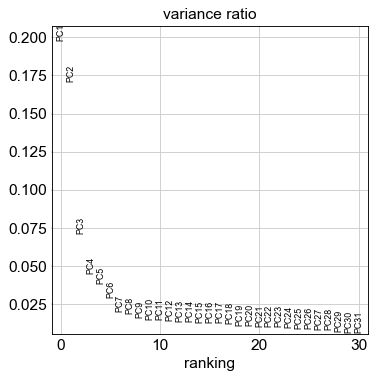

In [14]:
sc.pl.pca_variance_ratio(st_splotch_pd_bac, log=False)

In [15]:
'Do tsne on pheno'
sc.tl.tsne(st_splotch_pd_bac, use_rep = "X_pca", n_pcs=20, random_state = 7,  perplexity=50, use_fast_tsne=True)

... storing 'Age' as categorical
... storing 'conditions' as categorical


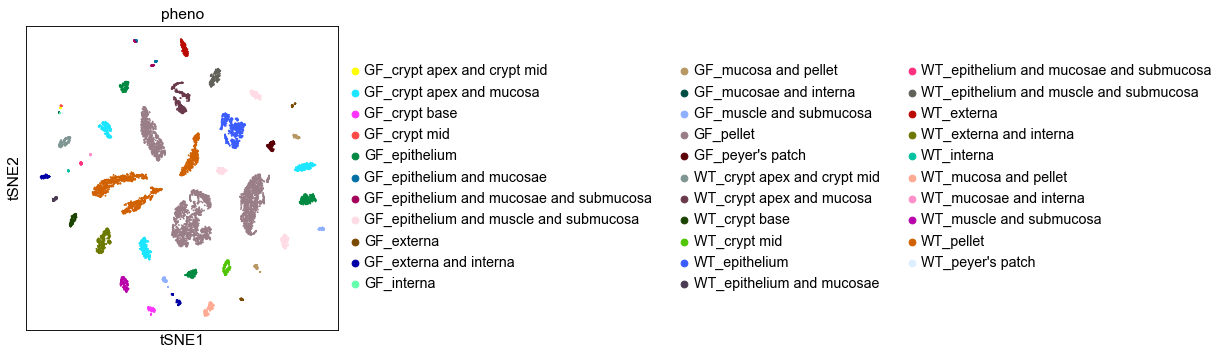

In [16]:
#sanity check after PCA
sc.pl.tsne(st_splotch_pd_bac, color=['pheno',  ], save="Clusters_all_sc2st.pdf") 

## Plot whole tissue rasters

In [17]:
st_splotch_pd_st = st_splotch_pd_bac[~st_splotch_pd_bac.obs.annotation.isin(['pellet', 'mucosa and pellet'])]

Subsetting to major ROIs...
Subsetting to specific genotype...
0.0 23.417499999999997
Cd52


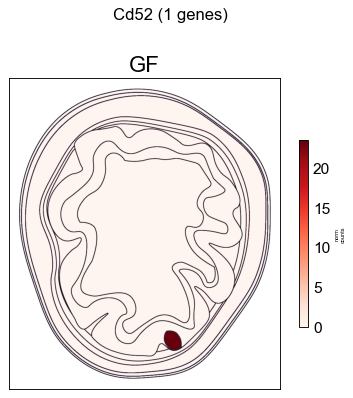

In [18]:
plot_tissue_rasters_bac(st_splotch_pd_st, vmin1 = 0, vmax1 = 0.95,  gene = ['Cd52'], plot_type = 'major', region = ['GF'],)

Subsetting to major ROIs...
Subsetting to specific genotype...
                                                   value
annotation                          conditions          
epithelium                          WT_6w      -0.258708
epithelium and mucosae              WT_6w      -0.347697
epithelium and muscle and submucosa WT_6w      -0.256852
externa                             WT_6w      -0.183406
externa and interna                 WT_6w      -0.406404
interna                             WT_6w      -0.219843
mucosae and interna                 WT_6w      -0.462953
peyer's patch                       WT_6w       3.000838
Cd52


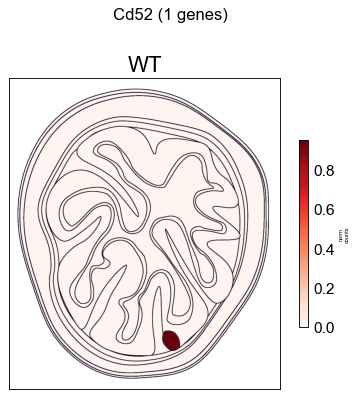

In [19]:
plot_tissue_rasters(st_splotch_pd_st, vmin = 0, vmax = 0.95, gene = ['Cd52'], plot_type = 'major', region = ['WT'],)

Subsetting to major ROIs...
Subsetting to specific genotype...
-3.2675 12.4165
Myh11


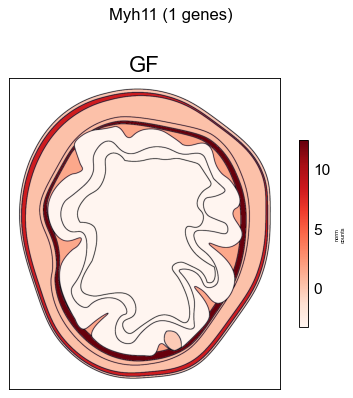

In [20]:
plot_tissue_rasters_bac(st_splotch_pd_st, vmin1 = -0.25, vmax1 = 0.95,   gene = ['Myh11'], plot_type = 'major', region = ['GF'],)

Subsetting to major ROIs...
Subsetting to specific genotype...
-2.865 10.887
Myh11


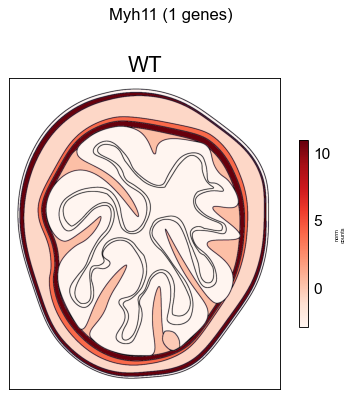

In [21]:
plot_tissue_rasters_bac(st_splotch_pd_st, vmin1 = -0.25, vmax1 = 0.95,  gene = ['Myh11'],  plot_type = 'major', region = ['WT'],)

Subsetting to major ROIs...
Subsetting to specific genotype...
0.7240000000000001 13.756
Epcam


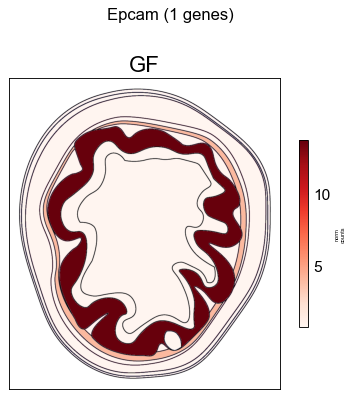

In [22]:
plot_tissue_rasters_bac(st_splotch_pd_st, vmin1 = 0.05, vmax1 = 0.95, gene = ['Epcam'], plot_type = 'major', region = ['GF'],)

Subsetting to major ROIs...
Subsetting to specific genotype...
0.497 9.443
Epcam


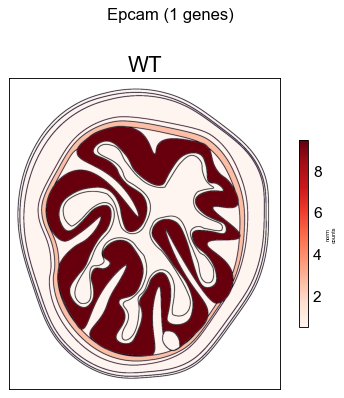

In [23]:
plot_tissue_rasters_bac(st_splotch_pd_st, vmin1 = 0.05, vmax1 = 0.95, gene = ['Epcam'],  plot_type = 'major', region = ['WT'],)

## Plot tsnes for bacs

In [24]:
'Plot bacteria tsne'
st_splotch_pd_bac_plot = st_splotch_pd_bac[st_splotch_pd_bac.obs.annotation.isin(['pellet',
                            'mucosa and pellet', 'crypt apex and mucosa', 'crypt apex and crypt mid',
                            'crypt mid', 'crypt base'])]

#clean up names
st_splotch_pd_bac_plot = st_splotch_pd_bac_plot[:,[i for i in st_splotch_pd_bac_plot.var_names if "Bacteria" in i]]
st_splotch_pd_bac_plot.var_names = [i.split("-")[0] for i in st_splotch_pd_bac_plot.var_names ]

#take only wt to match paper
st_splotch_pd_bac_plot_wt = st_splotch_pd_bac_plot[st_splotch_pd_bac_plot.obs.Genotype == 'WT']


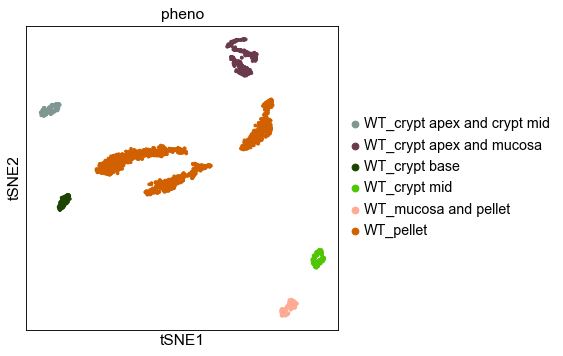

In [25]:
#sanity check after PCA
sc.pl.tsne(st_splotch_pd_bac_plot_wt, color=['pheno',  ], save="Bacteria_tsne_wt_sc2st.pdf" )

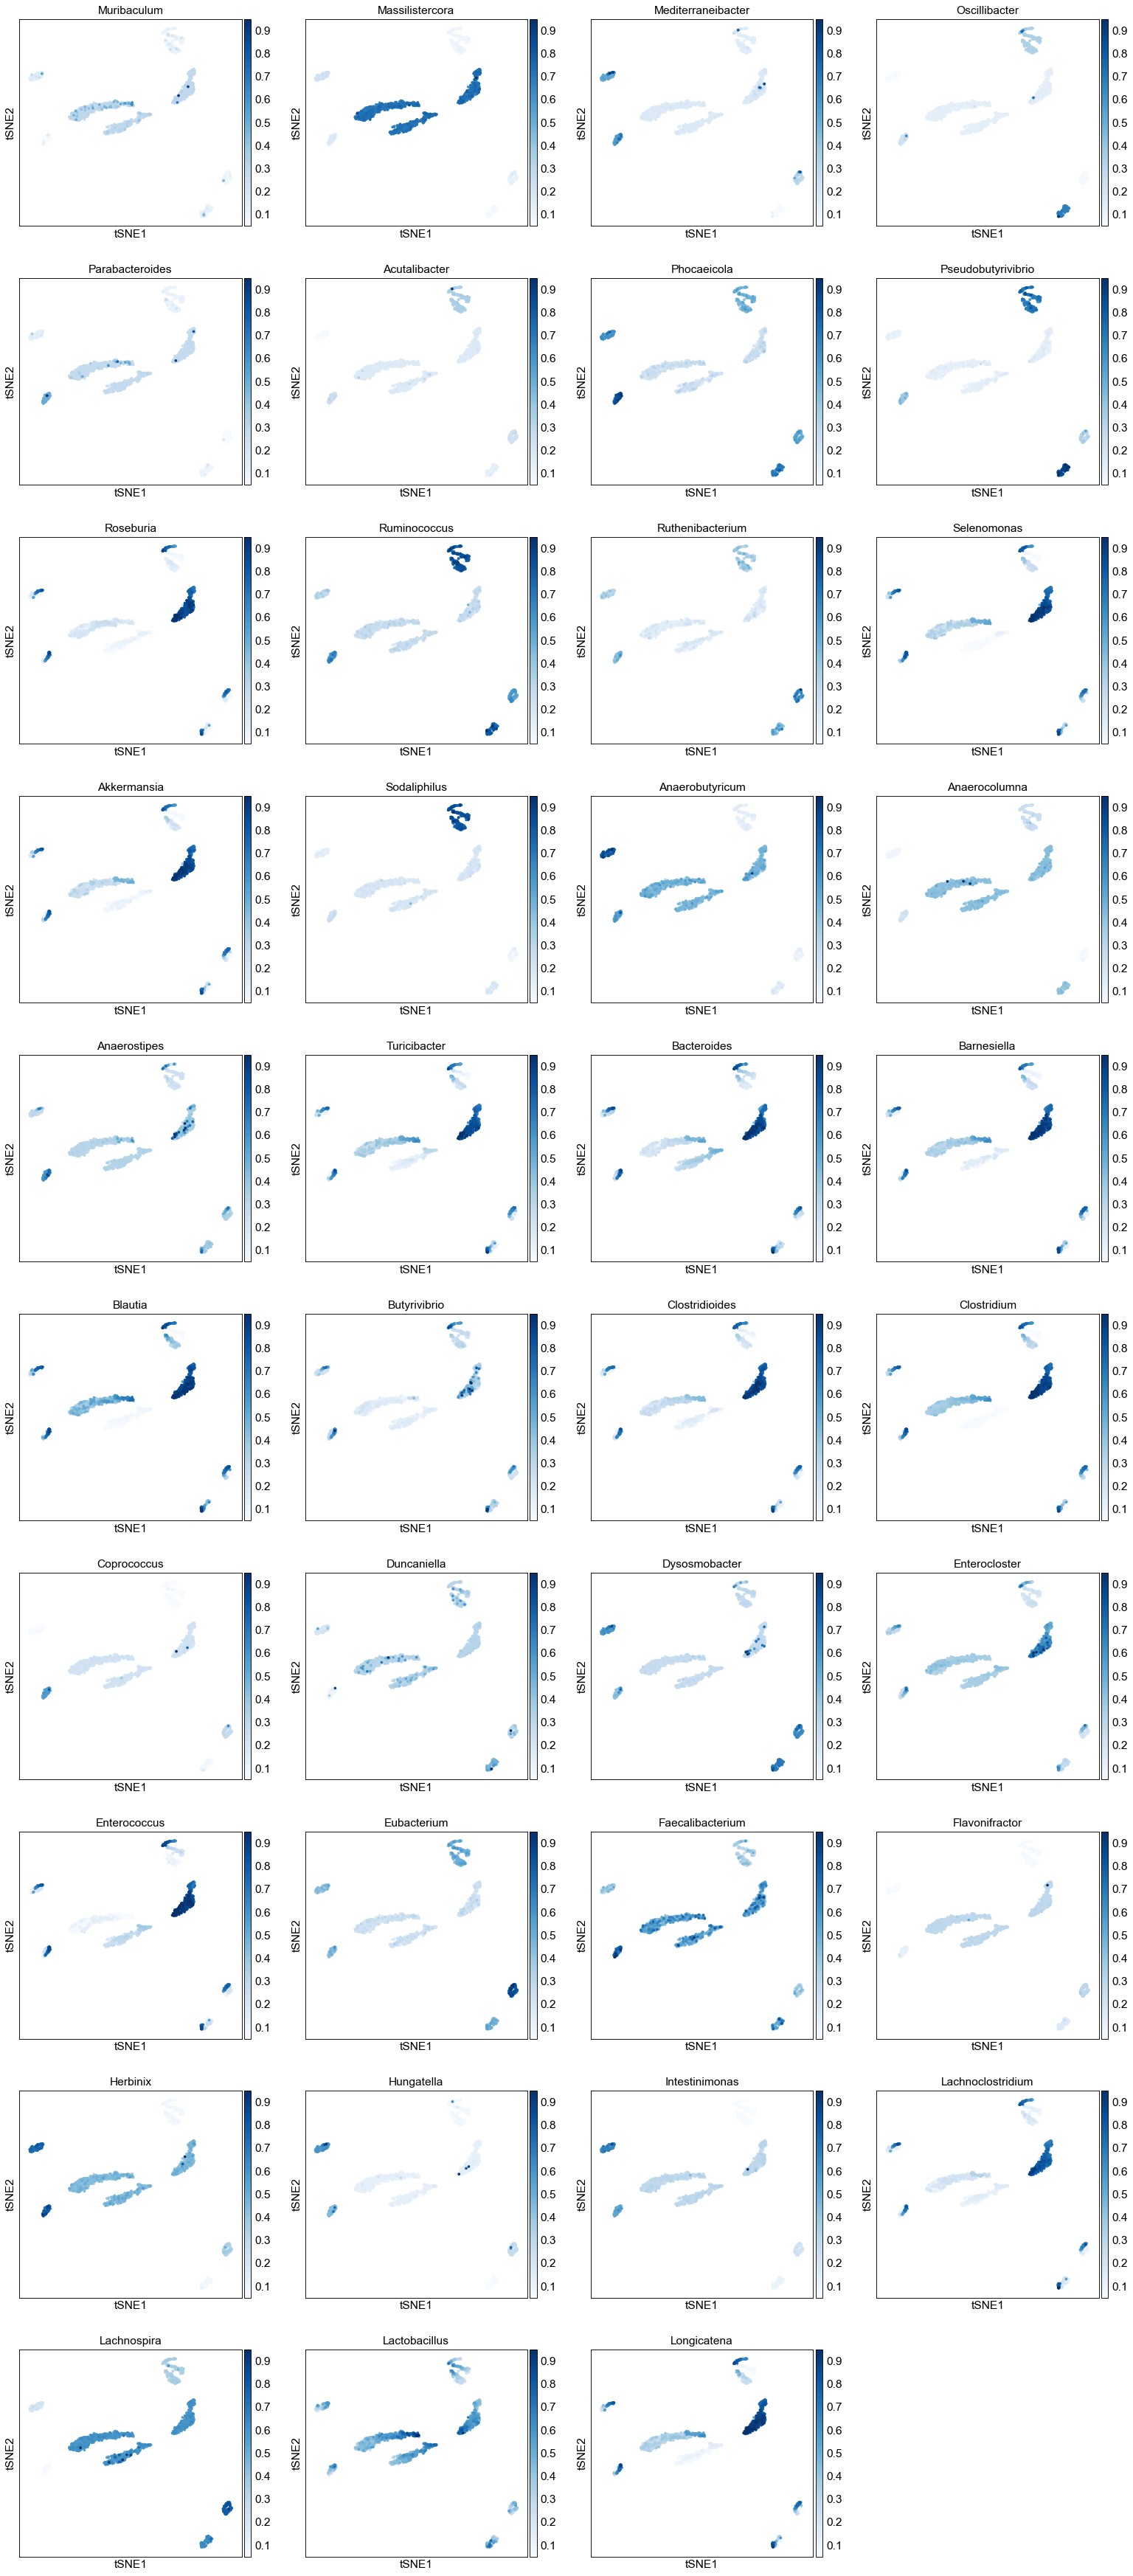

In [26]:
#scale
st_splotch_pd_bac_plot_scaled = st_splotch_pd_bac_plot_wt.copy()
st_splotch_pd_bac_plot_scaled.X = obs_wmean(st_splotch_pd_bac_plot_scaled, "annotation").T
st_splotch_pd_bac_plot_scaled.X = sklearn.preprocessing.minmax_scale(st_splotch_pd_bac_plot_wt.X, feature_range=(0,1))
sc.pl.tsne(st_splotch_pd_bac_plot_scaled, vmin = 0.05, vmax = 0.95, color=st_splotch_pd_bac_plot_scaled.var_names, cmap = 'Blues', save="Bacteria_clusters_sc2st_01.pdf")

Plot heatmap scores

In [27]:
# transpose X
bac_means = grouped_obs_wmean(st_splotch_pd_bac_plot_scaled, "annotation")
uu = pd.DataFrame(bac_means.values, index=bac_means.index, columns=bac_means.columns)

#clean up X
ax = sc.AnnData(X=uu, obs=pd.DataFrame({'annotation1': uu.index.tolist(),
                                       'annotation': uu.index.tolist()}).set_index('annotation1'))
ax.obs['annotation'] = ax.obs['annotation'].astype('category')


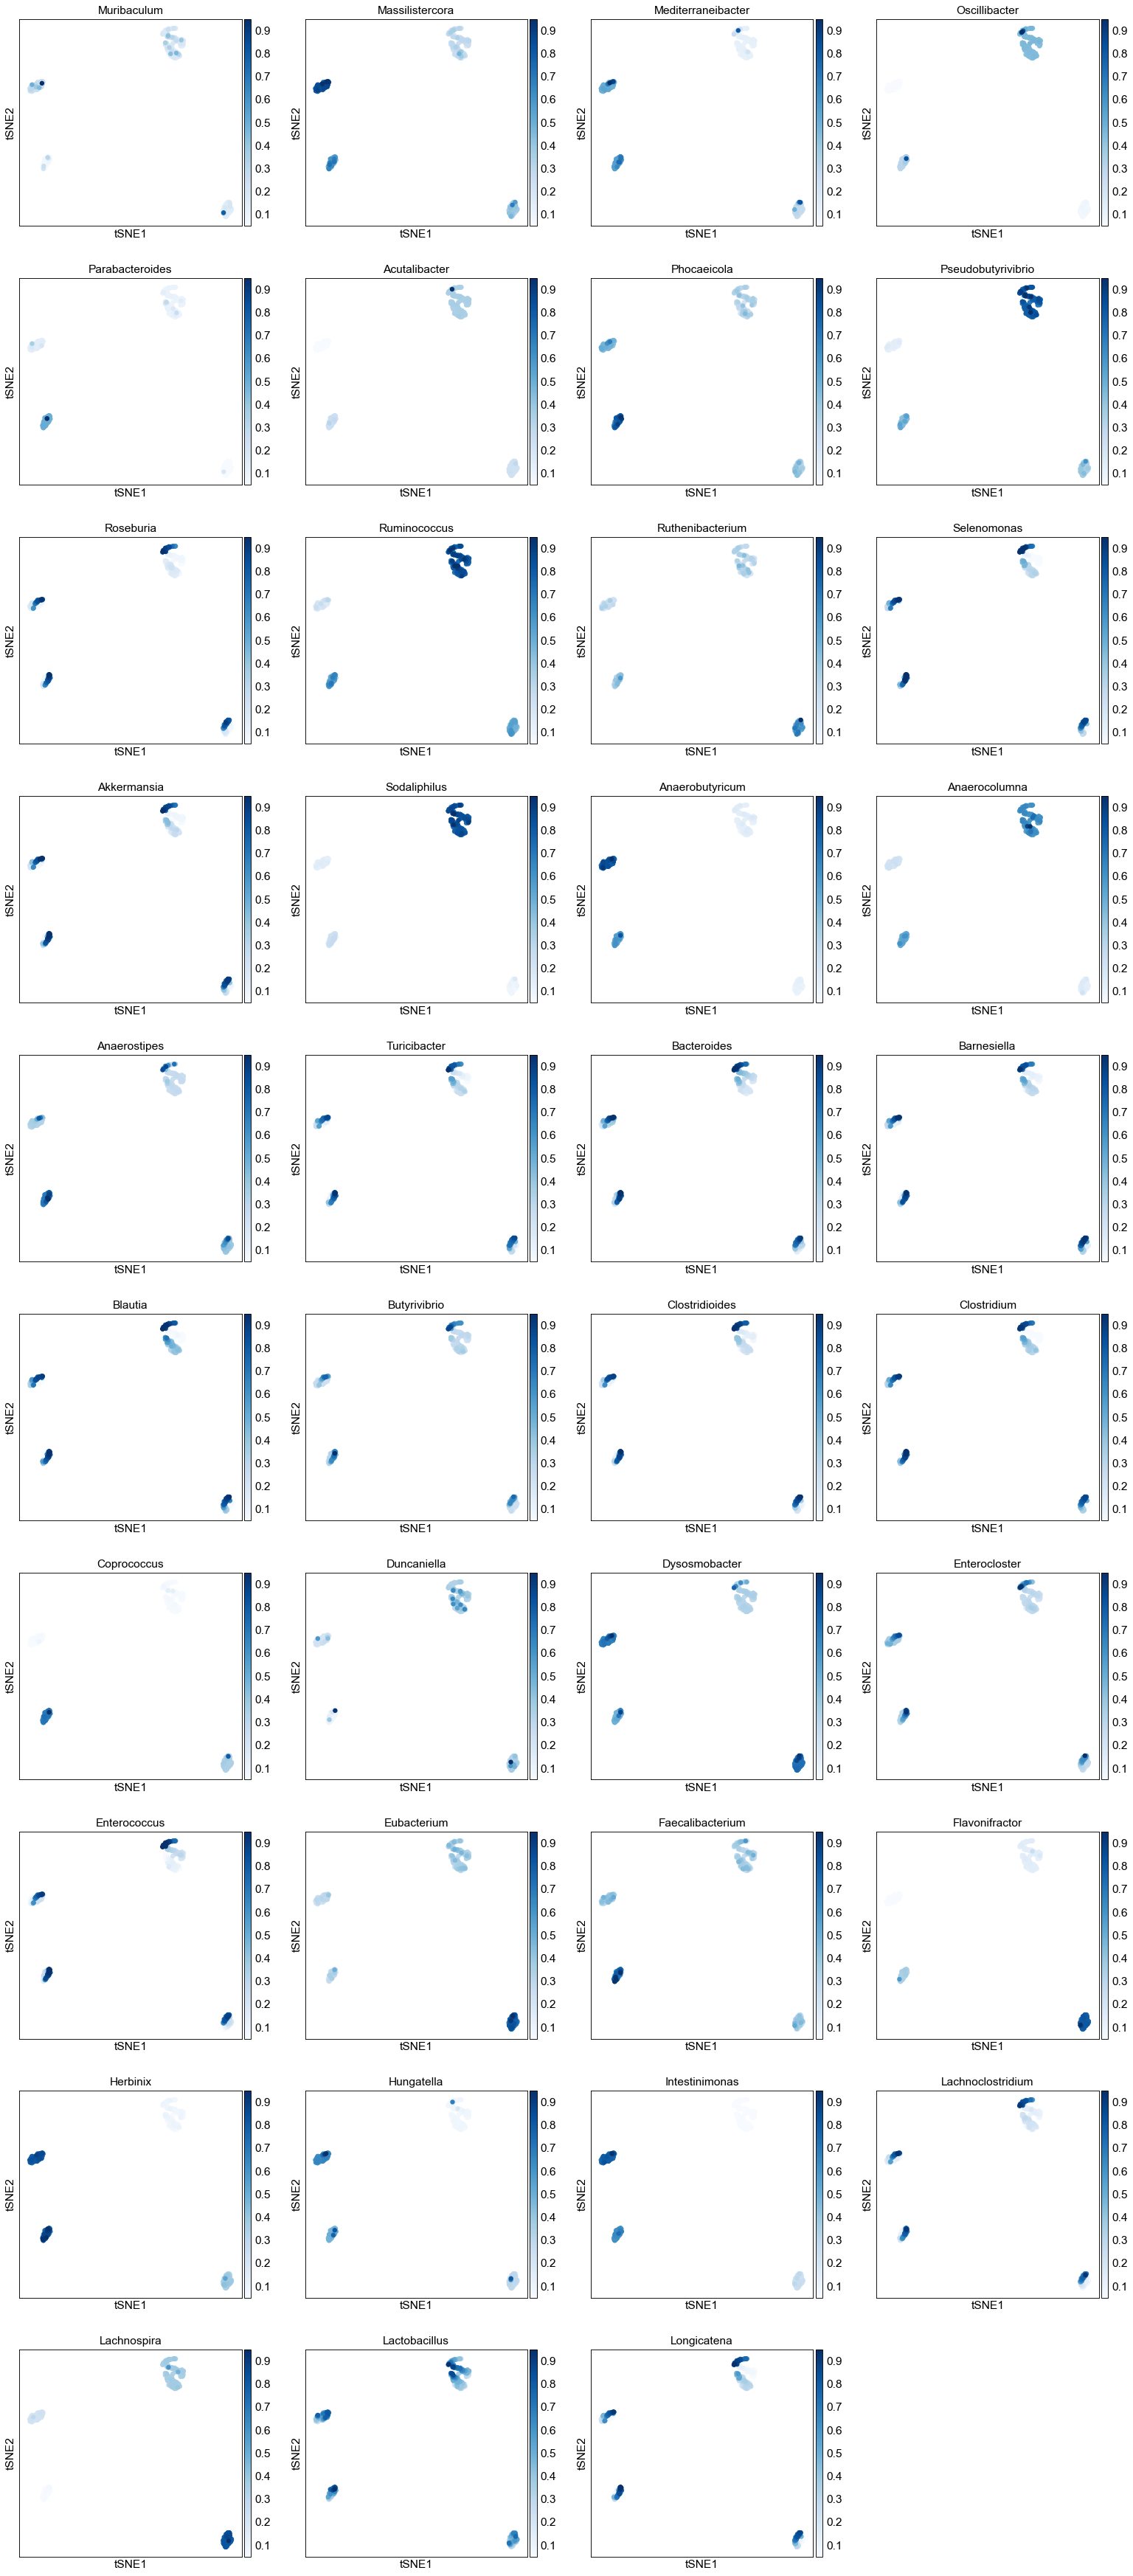

In [30]:
#plot only tissues tsne
st_splotch_pd_bac_plot_scaled = st_splotch_pd_bac_plot_wt.copy()
st_splotch_pd_bac_plot_scaled = st_splotch_pd_bac_plot_scaled[st_splotch_pd_bac_plot_scaled.obs.annotation.isin([
                            'crypt apex and mucosa', 'crypt apex and crypt mid',
                            'crypt mid', 'crypt base'])]
st_splotch_pd_bac_plot_scaled.X = sklearn.preprocessing.minmax_scale(st_splotch_pd_bac_plot_scaled.X, feature_range=(0,1))
sc.pl.tsne(st_splotch_pd_bac_plot_scaled, vmin = 0.05, vmax = 0.95,  color=st_splotch_pd_bac_plot_scaled.var_names, cmap = 'Blues', save="Bacteria_clusters_sc2st_01_4mrois.pdf")

In [31]:
st_splotch_pd_bac_plot_scaled = st_splotch_pd_bac_plot.copy()
st_splotch_pd_bac_plot_scaled.X = obs_wmean(st_splotch_pd_bac_plot_scaled, "annotation").T
st_splotch_pd_bac_plot_scaled = st_splotch_pd_bac_plot_scaled[st_splotch_pd_bac_plot_scaled.obs.annotation.isin([
                            'crypt apex and mucosa', 'crypt apex and crypt mid',
                            'crypt mid', 'crypt base'])]

In [32]:
st_splotch_pd_bac_plot_copy = st_splotch_pd_bac_plot[st_splotch_pd_bac_plot.obs.annotation.isin([
                            'crypt apex and mucosa', 'crypt apex and crypt mid',
                            'crypt mid', 'crypt base'])]

In [33]:
def plot_tissue_rasters(a, plot_type, key = None, gene = None, region = None, age = None, 
                        plot_values = None, axes = None, vmin = None, vmax = None):
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    plot_type - str - needs to match 'major' or 'minor'
    ** kwargs:
    key = 'annotation_analysis'
    plot_type = 'major'
    plot_values = 'modules'
    gene = ['Epcam']
    region = ['GT']
    age = ['6w']
    '''
    
    
    if key != None:
        if plot_values == 'modules':
            plot_values_str = '_modules'
        else:       
            if plot_values == 'submodules':
                plot_values_str = '_submodules'
            else:
                if plot_values == 'clusters':
                    plot_values_str = ''
                else:
                    print('you need to provide: "submodules" or "modules" as keyword arg')
    
    # check if key exhists
    try:
        if (key == None) & (gene == None):
            raise ValueError
        else:
            if (gene != None) & (key != None):
                print("Too many values to unpack...")
                raise ValueError
            else:
                if gene != None:
                    if len(gene) == 1:
                        for_keys = gene
                    else:
                        for_keys = ['gene average']
                else:
                    if 'module' in key:
                        for_keys = a.uns[str(key+plot_values_str)].keys()
                    else:
                        tmp = pd.DataFrame(adata.uns[key]['names'])
                        dict_genes = dict()
                        for col in tmp.columns:
                            dict_genes[col]= np.array([i for i in tmp[col] if str(i) != 'nan'])
                        for_keys = dict_genes.keys()

                for cluster_idx in for_keys:

                    #Get genes per cluster
                    if gene != None:
                        genes_cluster = gene
                    else:
                        if 'module' in key:
                            genes_cluster = a.uns[str(key+plot_values_str)][cluster_idx]
                        else:
                            genes_cluster = dict_genes[cluster_idx]

                    #Make sure anndata has the genes subsetted in this module aka cluster
                    a_cluster = a[:,np.intersect1d(genes_cluster,a.var_names)]

                    #Subset anndata to have all major rois # this is ok if we are using just sth for intial visualizations
                    if plot_type == 'major':
                        print("Subsetting to major ROIs...")
                        a_cluster = subset_to_major_rois(a_cluster)
                    else:
                        print("Subsetting to minor ROIs...")
                        print(np.unique(a_cluster.obs.annotation))
                        a_cluster = subset_to_minor_rois(a_cluster)

                    # subset to appropriate ages
                    ## comment this out if you don't want to subset data before plotting
                    if (key != None):

                        if ('genotype' in key):
                                sub1 = 'GF'
                                sub2 = 'WT'
                                a_cluster = a_cluster[a_cluster.obs.Genotype.isin([sub1, sub2])]

                    if (gene != None):
                        if (region != None):
                            print("Subsetting to specific genotype...")
                            a_cluster = a_cluster[a_cluster.obs.Genotype.isin(region)]
                            width_fig = 5
                        else:
                            width_fig = 3


                    # Scale data
                    sc_data_pd_subset = pd.DataFrame(a_cluster.X.T)
                    sc_data_pd_subset_max = (sc_data_pd_subset.values)/(sc_data_pd_subset.values).max(1,keepdims=True)
                    sc_data_pd_subset_max = (sc_data_pd_subset.values)
                    sc_data_pd_subset_max[np.isnan(sc_data_pd_subset_max)] = 0
                    sc_data_pd_subset_max[np.isinf(sc_data_pd_subset_max)] = 0
                    a_scaled = sc_data_pd_subset_max.flatten()

                    a_anns = a_cluster.obs.annotation
                    a_conds = a_cluster.obs.conditions

                    #Group anndata by condition and annotations
                    a_pd = pd.DataFrame([a_anns.tolist(), a_conds.tolist(), a_scaled.tolist()]).T
                    a_pd.columns = ["annotation", "conditions", "value"]
                    a_pd.value = a_pd.value.astype(float)
                    a_pd_mean = a_pd.groupby(["annotation", "conditions"]).mean()
                    print(a_pd_mean)

                    # set unique variables for plotting
                    ages = np.unique([i.split("_")[1] for i in np.unique([i for i in a_pd_mean.index.get_level_values(1)])])
                    ages = [str(j)+'w' for j in sorted([int(i.split('w')[0]) for i in ages])]
                    regions = np.unique([i.split("_")[0] for i in np.unique([i for i in a_pd_mean.index.get_level_values(1)])])

                    # use the same color scale across the arrays
                    if vmin == None:
                        vmin = 0.05*a_pd_mean.values.min()
                        vmin = 0
                    else:
                        vmin = vmin
                    if vmax == None:
                        vmax = 0.95*a_pd_mean.values.max()
                    else:
                        vmax = vmax
                    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

                    # initialize a figure
                    if axes !=None:
                        
                        cbmap = [None for _ in range(0,2)]
                    else:    
                        
                        fig = matplotlib.pyplot.figure()
                        fig.set_size_inches([len(regions)*5,len(ages)*5])
                        fig.subplots_adjust(hspace=0)

                        fig.suptitle(cluster_idx+" "+"(%d genes)"%(len(genes_cluster)),y=0.999,fontsize=15)

                        # initialize axes
                        ax = [fig.add_subplot(len(ages),len(regions),ax_idx) for ax_idx in range(1,len(regions)*len(ages)+1)]

                        # adjust the axes
                        # loop over the count files
                        ax_idx = 0
                        for n, var_of_interest in enumerate(ages):
                            for j, reg in enumerate(regions):
                                ax[ax_idx].set_title(regions[j], fontsize=20)

                                ax[ax_idx].set_aspect('equal')   
                                ax[ax_idx].set_xticks([])
                                ax[ax_idx].set_yticks([])
                                ax_idx+=1

                        cbmap = [None for _ in range(0,len(ax))]
                    print(cluster_idx)

                    # loop over the count files
                    counter = 0
                    for n, var_of_interest in enumerate(ages):
                        for j, reg in enumerate(regions):

                            # see if the current array has the level variable of interest
                            ax_idx = counter

                            gene_df_tmp = a_pd_mean
                            gene_df_fin = gene_df_tmp[a_pd_mean.index.get_level_values(1) == reg+"_"+var_of_interest]
                            
                            avg_colors = dict()
                            avg_colors[ax_idx] = [cm.Reds(norm(i), bytes=True) for i in gene_df_fin['value'].tolist()]
                            test_keys = gene_df_fin.index.get_level_values(0).tolist()
                            av_colors_dict = {test_keys[i]: avg_colors[ax_idx][i] for i in range(len(test_keys))} 
                            new_cols = dict()
                            colors_to_rois_dict = get_colors_dict()
                            for k in av_colors_dict.keys():
                                for kk in colors_to_rois_dict.values():
                                    if k == kk:
                                        new_cols[get_key(k,colors_to_rois_dict)] = av_colors_dict[k]
                            # read appropriate tissue img
                            if plot_type == 'major':
                                red, green, blue, alpha, data, areas = get_raster_whole_tissue(reg, var_of_interest)
                            else:
                                red, green, blue, alpha, data, areas = get_raster(reg, var_of_interest)
                            for i in get_colors_dict().keys():
                                if i == 'muc':
                                    continue
                                area=areas[i]                                
                                if i in new_cols.keys():
                                    data[..., :-1][area.T] = new_cols[i][0:3] # Transpose back needed
                                else:
                                    data[..., :-1][area.T] = cm.Reds(norm(vmin), bytes=True)[0:3]

                            dtim = np.array(data).astype('uint8')
                            
                            if axes != None:
                                cbmap[ax_idx]=axes.imshow(dtim)
                            else:
                                cbmap[ax_idx]=ax[ax_idx].imshow(dtim)

                            counter +=1
                    # add colorbars
                    
                    if axes != None:
                        cbar = matplotlib.pyplot.colorbar(cm.ScalarMappable(norm=norm, cmap='Reds'),
                                                          ax=axes,shrink=0.8, orientation="horizontal",
                                                          extend='both', pad = 0.05)   
                        ticklabs = cbar.ax.get_yticks()
                        ticklabs = [str(round(float(label), 2)) for label in ticklabs]
                        cbar.ax.set_yticklabels(ticklabs,fontsize=3)
                        cbar.ax.tick_params(labelsize=7)
                    
                    else:
                        ax_idx = 0
                        for n, var_of_interest in enumerate(ages):
                            for j, reg in enumerate(regions):
                                if cbmap[ax_idx] is not None:
                                    cbar = matplotlib.pyplot.colorbar(cm.ScalarMappable(norm=norm, cmap='Reds'),ax=ax[ax_idx],shrink=0.6)    
                                    cbar.set_label(r'%s'%('norm'+'\n'+'counts'),fontsize=5)
                                    ticklabs = cbar.ax.get_yticks()
                                    ticklabs = [str(round(float(label), 2)) for label in ticklabs]
                                ax_idx +=1

                        fig.set_tight_layout(True)
                        if key != None:
                            fig.savefig('figures/tissues_'+plot_type+'_raster_%s.pdf'%(cluster_idx))
                        else:
                            conds = "".join([i+"_" for i in ages])+"".join([i+"_" for i in regions])[:-1] 
                            fig.savefig('figures/tissues_'+plot_type+'_raster_%s.pdf'%(cluster_idx+"_"+conds))
                        

    except ValueError:
        print("no data to show in condition")
        pass

In [239]:
st_splotch_pd_bac_plot_scaled = st_splotch_pd_bac_plot.copy()
st_splotch_pd_bac_plot_scaled = st_splotch_pd_bac_plot_scaled[st_splotch_pd_bac_plot_scaled.obs.annotation.isin([
                            'crypt apex and mucosa', 'crypt apex and crypt mid',
                            'crypt mid', 'crypt base'])]

Subsetting to minor ROIs...
Subsetting to specific genotype...
0.0 33.592
Intestinimonas


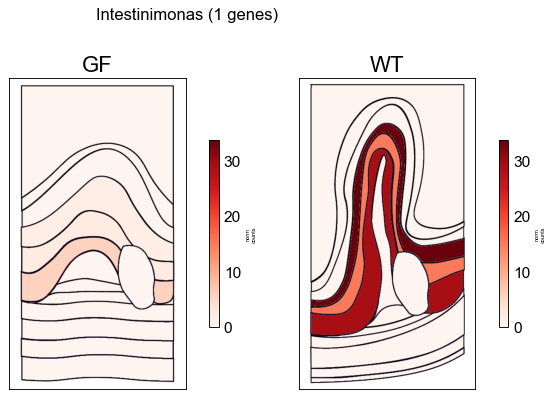

In [34]:
plot_tissue_rasters_bac(st_splotch_pd_bac_plot_scaled, vmin1 = 0,
                        region = ['GF', 'WT'], gene = ['Intestinimonas'], 
                        plot_type = 'minor',)

Subsetting to minor ROIs...
Subsetting to specific genotype...
0.0 78.3845
Pseudobutyrivibrio


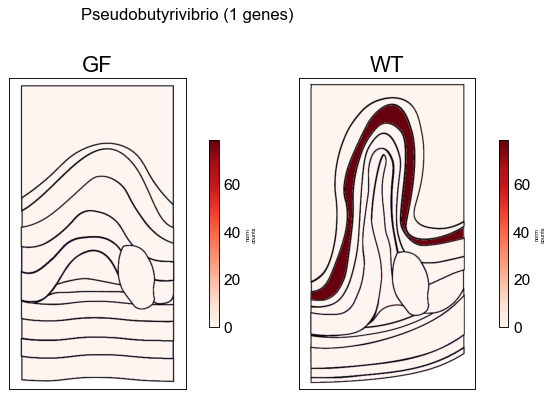

In [35]:
plot_tissue_rasters_bac(st_splotch_pd_bac_plot_scaled, region = ['GF', 'WT'], vmin1 = 0,
                     gene = ['Pseudobutyrivibrio'], plot_type = 'minor',
                    )

Subsetting to minor ROIs...
Subsetting to specific genotype...
0.0 36.385
Coprococcus


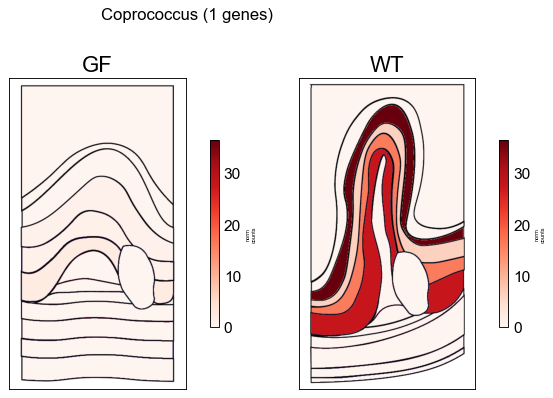

In [36]:
plot_tissue_rasters_bac(st_splotch_pd_bac_plot_scaled, region = ['GF', 'WT'], vmin1 = 0,
                     gene = ['Coprococcus'], plot_type = 'minor',
                    )

Subsetting to minor ROIs...
Subsetting to specific genotype...
0.0 35.187999999999995
Flavonifractor


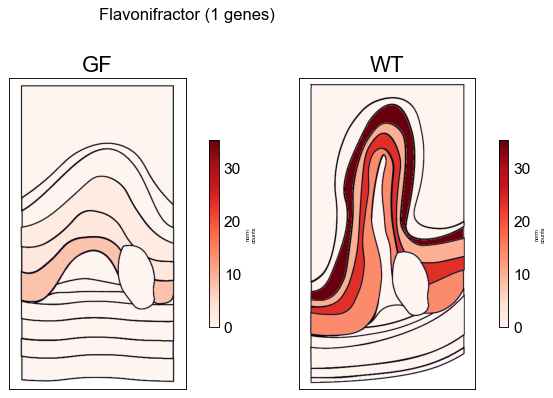

In [37]:
plot_tissue_rasters_bac(st_splotch_pd_bac_plot_scaled,  region = ['GF', 'WT'], vmin1 = 0,
                     gene = ['Flavonifractor'], plot_type = 'minor',
                    )

### Read st anndata and sc grouped_means scores 

In [39]:
# Load Lambda pmean df
path = ''

# Read expression file
filename = os.path.join(path, 'anndata_hm_norm_all_de_genes_n_Feb2022.h5ad')

st_splotch_pd = sc.read_h5ad(filename)
sc.pp.log1p(st_splotch_pd)
sc.pp.scale(st_splotch_pd,max_value=10)

st_splotch_pd.obs['Age'] = '6w'
st_splotch_pd.obs['conditions'] = [i+"_"+str(j) for i,j in zip(st_splotch_pd.obs.Genotype, st_splotch_pd.obs.Age)]
st_splotch_pd = st_splotch_pd[:,[i for i in st_splotch_pd.var_names if not 'Lacrimispora' in i]]
st_splotch_pd = st_splotch_pd[:,[i for i in st_splotch_pd.var_names if not 'Acetobacterium' in i]]

# subset to splotch relevant genes
genes = np.unique([i for i in pd.DataFrame(st_splotch_pd.uns['st_genotype_and_annotation_analysis']['names']).values.flatten() if i != 'nan'])
bacs = [i for i in st_splotch_pd.var_names if "Bacteria" in i]

# read mean file 
marker_gene_expression_pd = pd.read_csv('mli_zscore_norm_scaled_all_pheno_log.csv', header=[0], index_col=0, skipinitialspace=True)


In [40]:
st_splotch_pd_bac

AnnData object with n_obs × n_vars = 10924 × 17956
    obs: 'sample', 'patch', 'annotation', 'x', 'y', 'Genotype', 'Specimen_ID', 'cell_count', 'Sex', 'sections', 'UMIs', 'Genes', 'spots', 'short_annotations', 'index', 'genotype_conds', 'Age', 'conditions', 'pheno'
    var: 'mean', 'std'
    uns: 'bac_annotation_analysis', 'bac_annotation_analysis_filtered', 'bac_annotation_analysis_filtered_n', 'bac_genotype_analysis', 'bac_genotype_analysis_filtered', 'bac_genotype_and_annotation_analysis', 'bac_genotype_and_annotation_analysis_filtered', 'st_annotation_analysis', 'st_annotation_analysis_filtered', 'st_genotype_analysis', 'st_genotype_analysis_filtered', 'st_genotype_and_annotation_analysis', 'st_genotype_and_annotation_analysis_filtered', 'log1p', 'pca', 'neighbors', 'umap', 'pheno_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [41]:
st_splotch_pd

View of AnnData object with n_obs × n_vars = 10924 × 17956
    obs: 'sample', 'patch', 'annotation', 'x', 'y', 'Genotype', 'Specimen_ID', 'cell_count', 'Sex', 'Gnai3', 'sections', 'UMIs', 'Genes', 'spots', 'short_annotations', 'index', 'genotype_conds', 'Age', 'conditions'
    var: 'mean', 'std'
    uns: 'bac_annotation_analysis', 'bac_annotation_analysis_filtered', 'bac_annotation_analysis_filtered_n', 'bac_genotype_analysis', 'bac_genotype_analysis_filtered', 'bac_genotype_and_annotation_analysis', 'bac_genotype_and_annotation_analysis_filtered', 'st_annotation_analysis', 'st_annotation_analysis_filtered', 'st_genotype_analysis', 'st_genotype_analysis_filtered', 'st_genotype_and_annotation_analysis', 'st_genotype_and_annotation_analysis_filtered', 'log1p'

Merge obs and uns from bac anndata

In [42]:
'Merge obs with scores and clusters'
st_splotch_pd_bac = st_splotch_pd_bac[~st_splotch_pd_bac.obs.annotation.isin(['pellet', 'mucosa and pellet'])]
st_splotch_pd = st_splotch_pd[~st_splotch_pd.obs.annotation.isin(['pellet', 'mucosa and pellet'])]
st_splotch_pd.obs = st_splotch_pd_bac.obs
st_splotch_pd.uns = {**st_splotch_pd.uns, **st_splotch_pd_bac.uns} 
st_splotch_pd.obsm = {**st_splotch_pd.obsm, **st_splotch_pd_bac.obsm} 

In [43]:
st_splotch_pd

AnnData object with n_obs × n_vars = 5413 × 17956
    obs: 'sample', 'patch', 'annotation', 'x', 'y', 'Genotype', 'Specimen_ID', 'cell_count', 'Sex', 'sections', 'UMIs', 'Genes', 'spots', 'short_annotations', 'index', 'genotype_conds', 'Age', 'conditions', 'pheno'
    var: 'mean', 'std'
    uns: 'bac_annotation_analysis', 'bac_annotation_analysis_filtered', 'bac_annotation_analysis_filtered_n', 'bac_genotype_analysis', 'bac_genotype_analysis_filtered', 'bac_genotype_and_annotation_analysis', 'bac_genotype_and_annotation_analysis_filtered', 'st_annotation_analysis', 'st_annotation_analysis_filtered', 'st_genotype_analysis', 'st_genotype_analysis_filtered', 'st_genotype_and_annotation_analysis', 'st_genotype_and_annotation_analysis_filtered', 'log1p', 'pca', 'neighbors', 'umap', 'pheno_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'

Standardize datasets to the same gene names

In [44]:
#takes variable genes from sc data
common_genes = np.intersect1d(marker_gene_expression_pd.index,st_splotch_pd.var_names)

# makes sure magic pd and st pd have those sc variable genes
st_splotch_pd_subset = st_splotch_pd[:,st_splotch_pd.var_names.isin(common_genes)]    
marker_gene_expression_pd = marker_gene_expression_pd[marker_gene_expression_pd.index.isin(common_genes)] 

# makes sure st pd and markers pd are in the same gene orders and magic pd
marker_gene_expression_pd = marker_gene_expression_pd.reindex(st_splotch_pd_subset.var_names)

In [45]:
len(common_genes)

16525

Data before correlation

In [46]:
sc_magic_standardized = marker_gene_expression_pd.values
st_splotch_standardized = st_splotch_pd_subset.X


Compute gene-to-gene correlations between the datasets

In [47]:
# compute correlations
corr_matrix_spots_markers = np.corrcoef(sc_magic_standardized.T.astype(float),st_splotch_standardized.astype(float))[0:sc_magic_standardized.shape[1],:][:,sc_magic_standardized.shape[1]:]
X = corr_matrix_spots_markers

In [48]:
'Collect scores into a pandas df'
scores = pd.DataFrame(corr_matrix_spots_markers.T, index = st_splotch_pd.obs.index, columns =  ['score_'+i for i in marker_gene_expression_pd.columns])


In [49]:
corr_matrix_spots_markers.shape

(30, 5413)

Perform clustering to add st_clusters to original st_anndata object

In [50]:
'Set threshold - needs to be the same as in st modules'
cluster_thershold = 0.176 #  0.176 works for 4 mrois

'Correlation matrix between norm gene expression between spatial spots'
corr_matrix_genes = scores


In [51]:
'Hierarchical clustering on the scores matrix'
Y = scipy.cluster.hierarchy.linkage(corr_matrix_genes, metric='cityblock', method='average')

In [52]:
Y.shape

(5412, 4)

In [53]:
cluster_memberships_exp = scipy.cluster.hierarchy.fcluster(Y, cluster_thershold*max(Y[:,2]), criterion='distance')
print("Total clusters found...", len(np.unique(cluster_memberships_exp)))

Total clusters found... 28


In [54]:
'Add cluster numbers to scores st_anndata obs'
st_clust_adata = sc.AnnData(scores, pd.DataFrame(['st_cluster_'+str(i) for i in cluster_memberships_exp], index = scores.index, columns = ['st_cluster']))
st_clust_adata.obs.st_cluster = st_clust_adata.obs.st_cluster.astype('category')

Adds scores and st_clusters to original anndata object

In [55]:
'Make a copy of st_anndata'
st_splotch_pd_copy = st_splotch_pd.copy()

'Merge obs with scores and clusters'
obs_tmp = pd.merge(st_splotch_pd_copy.obs, st_clust_adata.obs, left_index = True, right_index = True)
st_splotch_pd_copy.obs = pd.merge(obs_tmp, scores, left_index = True, right_index = True)
st_splotch_pd_copy.uns = {**st_splotch_pd_copy.uns, **st_clust_adata.uns} 
st_splotch_pd_copy.obsm = {**st_splotch_pd_copy.obsm, **st_clust_adata.obsm} 


Gets into scanpy format

In [56]:
st_splotch_pd_copy.X = st_splotch_pd_copy.X + abs(st_splotch_pd_copy.X.min())

In [60]:
'Makes sure to remove small clusters'
small_clusters_pd = (st_splotch_pd_copy.obs.groupby(['st_cluster']).count() > 10)[['sample']]
small_clusters_st = small_clusters_pd[small_clusters_pd['sample']== True].index
small_clusters_pd = (st_splotch_pd_copy.obs.groupby(['pheno']).count() > 10)[['sample']]
small_clusters_pheno = small_clusters_pd[small_clusters_pd['sample'] == True].index

In [61]:
st_splotch_pd_copy = st_splotch_pd_copy[(st_splotch_pd_copy.obs['pheno'].isin(small_clusters_pheno)) & (st_splotch_pd_copy.obs['st_cluster'].isin(small_clusters_st))]

In [62]:
st_splotch_pd_copy.var_names_make_unique()

In [63]:
'Rank genes per st_cluster'
sc.tl.rank_genes_groups(st_splotch_pd_copy, groupby = 'pheno', rankby_abs=True, key_added='pheno', method='t-test', corr_method='benjamini-hochberg')


In [64]:
# 'Filter to sig values'
filter_rank_genes_st(st_splotch_pd_copy, key = 'pheno', key_added='pheno', 
                    min_fold_change=2,#2
                    min_pvals_change=0.001, #0.001
                    min_scores=1) #1

In [65]:
'Calculate dendrograms'
sc.tl.dendrogram(st_splotch_pd_copy, groupby = 'pheno')

#### Read single-cell data

In [67]:
sc_data_pd = pd.read_csv('mli_zscore_norm_scaled_all_pheno_log.csv', header=[0], index_col=0, skipinitialspace=True)


### Perform Pheno clustering program deconvolution (scRNA with KEGG analysis)

#### Generate Excel spreadsheet containing the KEGG results

In [69]:
generate_kegg_spreadsheet(group_names_st_clusters, file_prefix = "Pheno", output_file_name = 'Pheno_ST_clusters_KEGG_summary.xlsx')


#### Generate Excel spreadsheet containing submodule information

In [70]:
generate_submodules_spreadsheet(group_names_st_clusters, file_prefix = "Pheno", output_file_name = 'Pheno_ST_clusters_KEGG_submodule.xlsx')


#### Add KEGG results to anndata object

In [71]:
module_names_ann = kegg2anndata(st_splotch_pd_copy, key = 'pheno', xl = 'Pheno_ST_clusters_KEGG_summary.xlsx')


pheno_kegg_modules


#### Add KEGG submodules to anndata object 

In [73]:
kegg_submodules2anndata(st_splotch_pd_copy, key = 'pheno', xl = 'Pheno_ST_clusters_KEGG_summary.xlsx', real_module_names = module_names_ann)


pheno_kegg_submodules


[]

#### Add module and submodule gene information to anndata object

In [74]:
modules2anndata(st_splotch_pd_copy,  key = 'pheno', xl = 'Pheno_ST_clusters_KEGG_submodule.xlsx', real_module_names = module_names_ann)


## Repeat for 4 MROIs

In [77]:
'Make a copy of st_anndata'
st_splotch_pd_copy = st_splotch_pd.copy()
st_splotch_pd_copy.var_names_make_unique()

In [78]:
'Merge obs with scores and clusters'
obs_tmp = pd.merge(st_splotch_pd_copy.obs, st_clust_adata.obs, left_index = True, right_index = True)
st_splotch_pd_copy.obs = pd.merge(obs_tmp, scores, left_index = True, right_index = True)
st_splotch_pd_copy.uns = {**st_splotch_pd_copy.uns, **st_clust_adata.uns} 
st_splotch_pd_copy.obsm = {**st_splotch_pd_copy.obsm, **st_clust_adata.obsm} 

In [79]:
st_splotch_pd_copy = st_splotch_pd_copy[st_splotch_pd_copy.obs.annotation.isin(
   ['pellet', 'pellet and mucosa', 'crypt apex and mucosa', 'crypt apex and crypt mid', 'crypt mid', 'crypt base'])]

Gets into scanpy format

In [80]:
st_splotch_pd_copy.X = st_splotch_pd_copy.X + abs(st_splotch_pd_copy.X.min())

Subset to bacteria relevant MROIs

In [81]:
'Rank genes per st_cluster'
sc.tl.rank_genes_groups(st_splotch_pd_copy, groupby = 'pheno', rankby_abs=True, key_added='pheno', method='t-test', corr_method='benjamini-hochberg')


Trying to set attribute `.uns` of view, copying.


In [82]:
'Filter to sig values'
filter_rank_genes_st(st_splotch_pd_copy, key = 'pheno', key_added='pheno',
                    min_fold_change=0.5,
                    min_pvals_change=0.001,
                    min_scores=0)

In [83]:
'Include any marker genes in the plots'
d1 = pd.DataFrame(st_splotch_pd_copy.uns['pheno']['names'])[0:100].to_dict('list')
marker_genes = {
    'GF_crypt apex and mucosa': [],
    'GF_crypt base': [],
    'GF_crypt apex and crypt mid': [],
    'GF_crypt mid': [],
    'WT_crypt apex and crypt mid': ['Tacr1',  'Slamf6'],
    'WT_crypt apex and mucosa': ['Ceacam20', 'Hif1a',],
    'WT_crypt base': ['Chat','Camk2a'],
    'WT_crypt mid': [ 'Fcrls', 'Sema4f' ],
}
d2 = dict()
for nm in marker_genes.keys():
    print(nm)
    gn = [i for i in d1[nm] if str(i) != 'nan']
    if nm in marker_genes.keys():
        d2[nm] = gn[0:20]+marker_genes[nm]
    else:
        d2[nm] = gn[0:20]

GF_crypt apex and mucosa
GF_crypt base
GF_crypt apex and crypt mid
GF_crypt mid
WT_crypt apex and crypt mid
WT_crypt apex and mucosa
WT_crypt base
WT_crypt mid


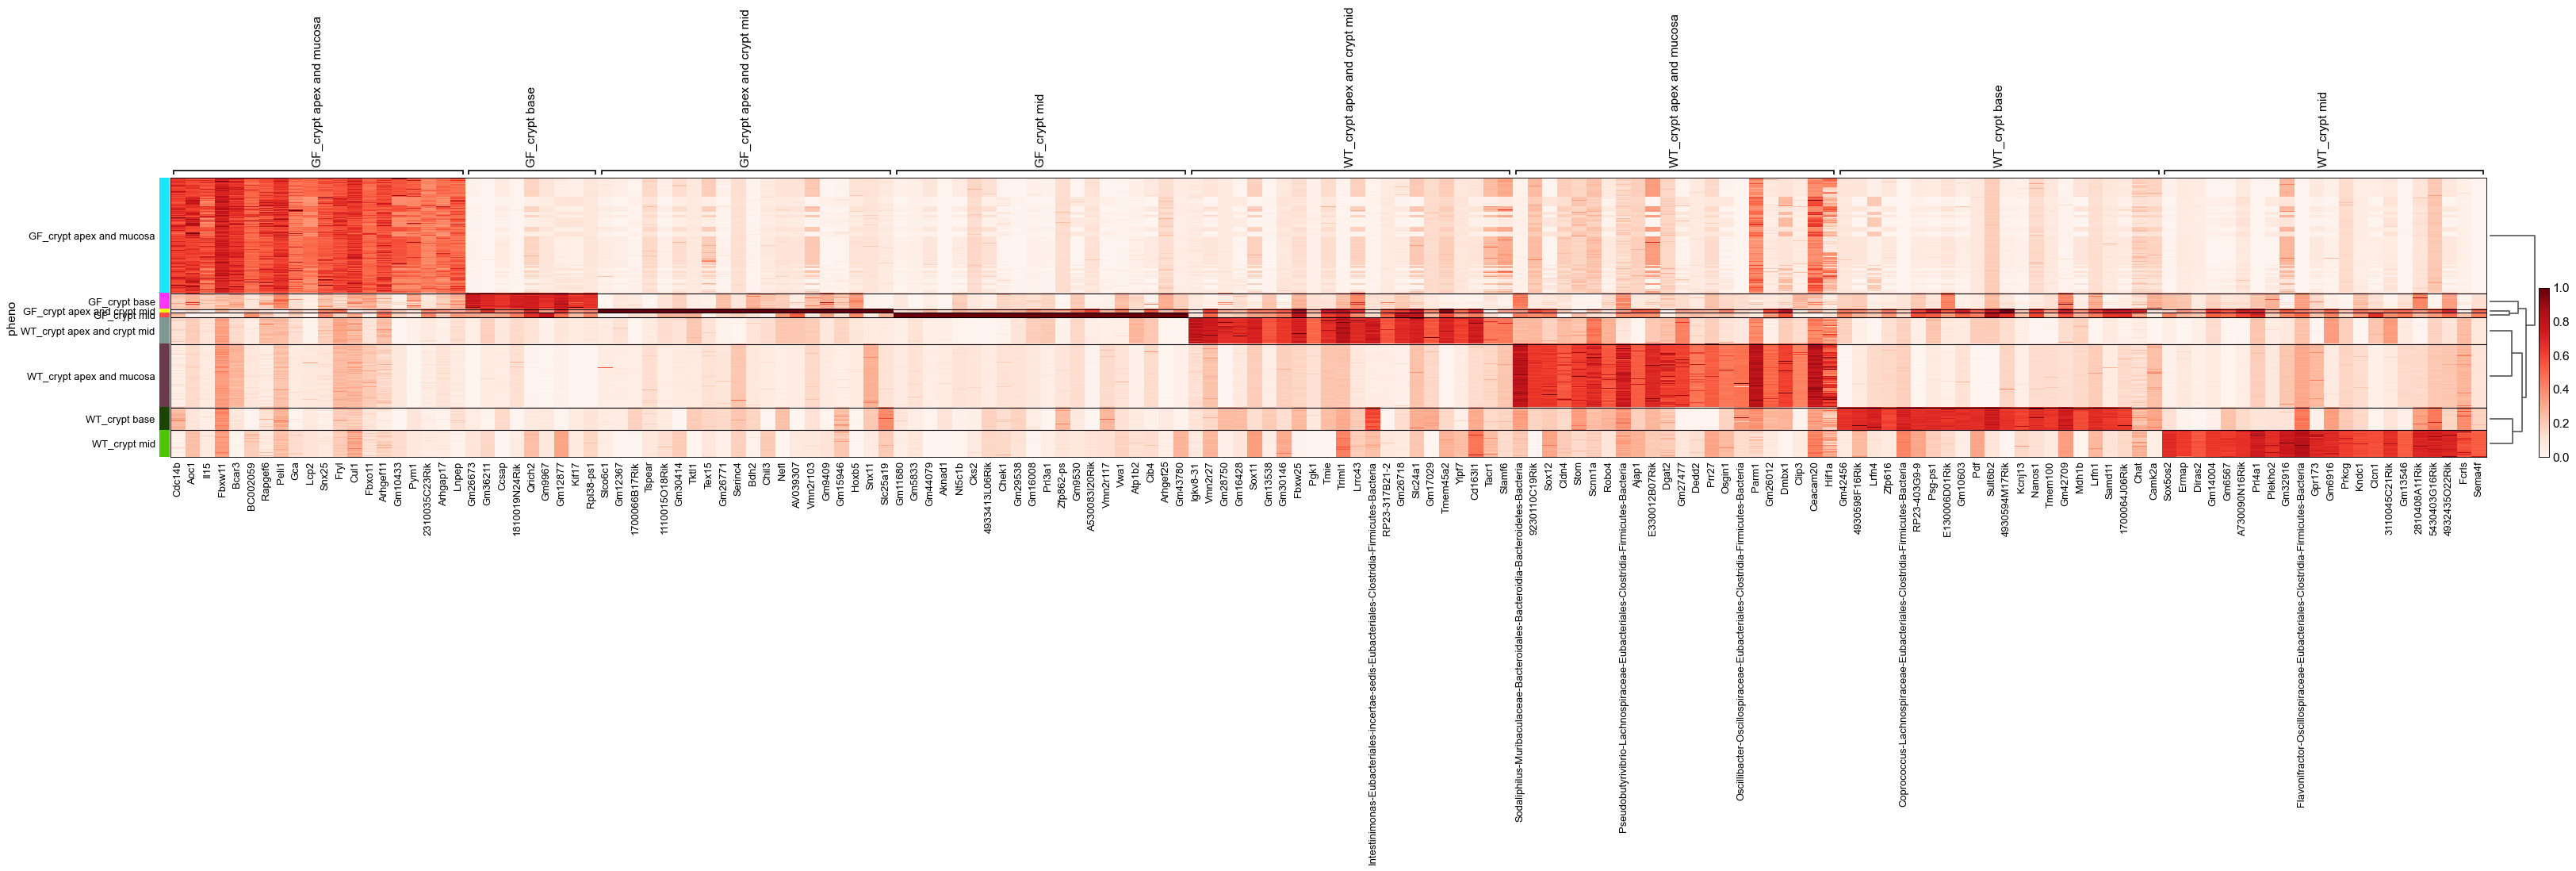

In [84]:
'Plot rankged genes with scanpy'
sc.tl.dendrogram(st_splotch_pd_copy, groupby = 'pheno')
sc.pl.heatmap(st_splotch_pd_copy, d2,cmap = 'Reds', dendrogram = True, 
                                show_gene_labels = True, groupby='pheno', 
                                standard_scale = 'var', save = '_heatmap_modules_4mrois_marker_genes.pdf')

#### Read single-cell data

In [85]:
sc_data_pd = pd.read_csv('mli_zscore_norm_scaled_pheno_log_markers.csv', header=[0], index_col=0, skipinitialspace=True)

### Perform Pheno clustering program deconvolution (scRNA with KEGG analysis)

pheno
GF_crypt_apex_and_crypt_mid
genes in common with scRNAseq data:  8773
genes over scRNA threshold:  336
GF_crypt_apex_and_crypt_mid
1
GF_crypt_apex_and_crypt_mid
2
GF_crypt_apex_and_crypt_mid
3
GF_crypt_apex_and_crypt_mid
4
GF_crypt_apex_and_crypt_mid
5
GF_crypt_apex_and_crypt_mid
6
GF_crypt_apex_and_crypt_mid
7
GF_crypt_apex_and_crypt_mid
8
GF_crypt_apex_and_crypt_mid
9
GF_crypt_apex_and_crypt_mid
10
GF_crypt_apex_and_crypt_mid
11
Total tsne submodules found... 11


Trying to set attribute `.obs` of view, copying.
... storing 'st_submodule' as categorical


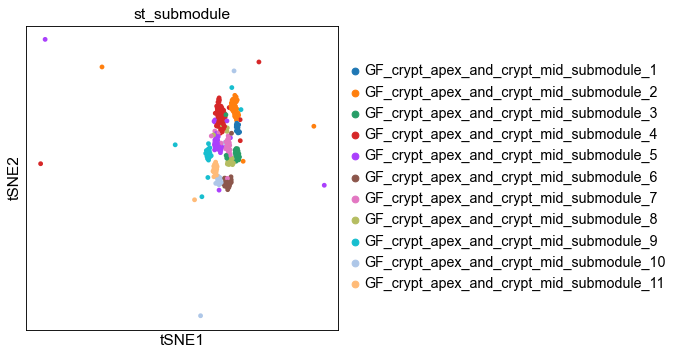

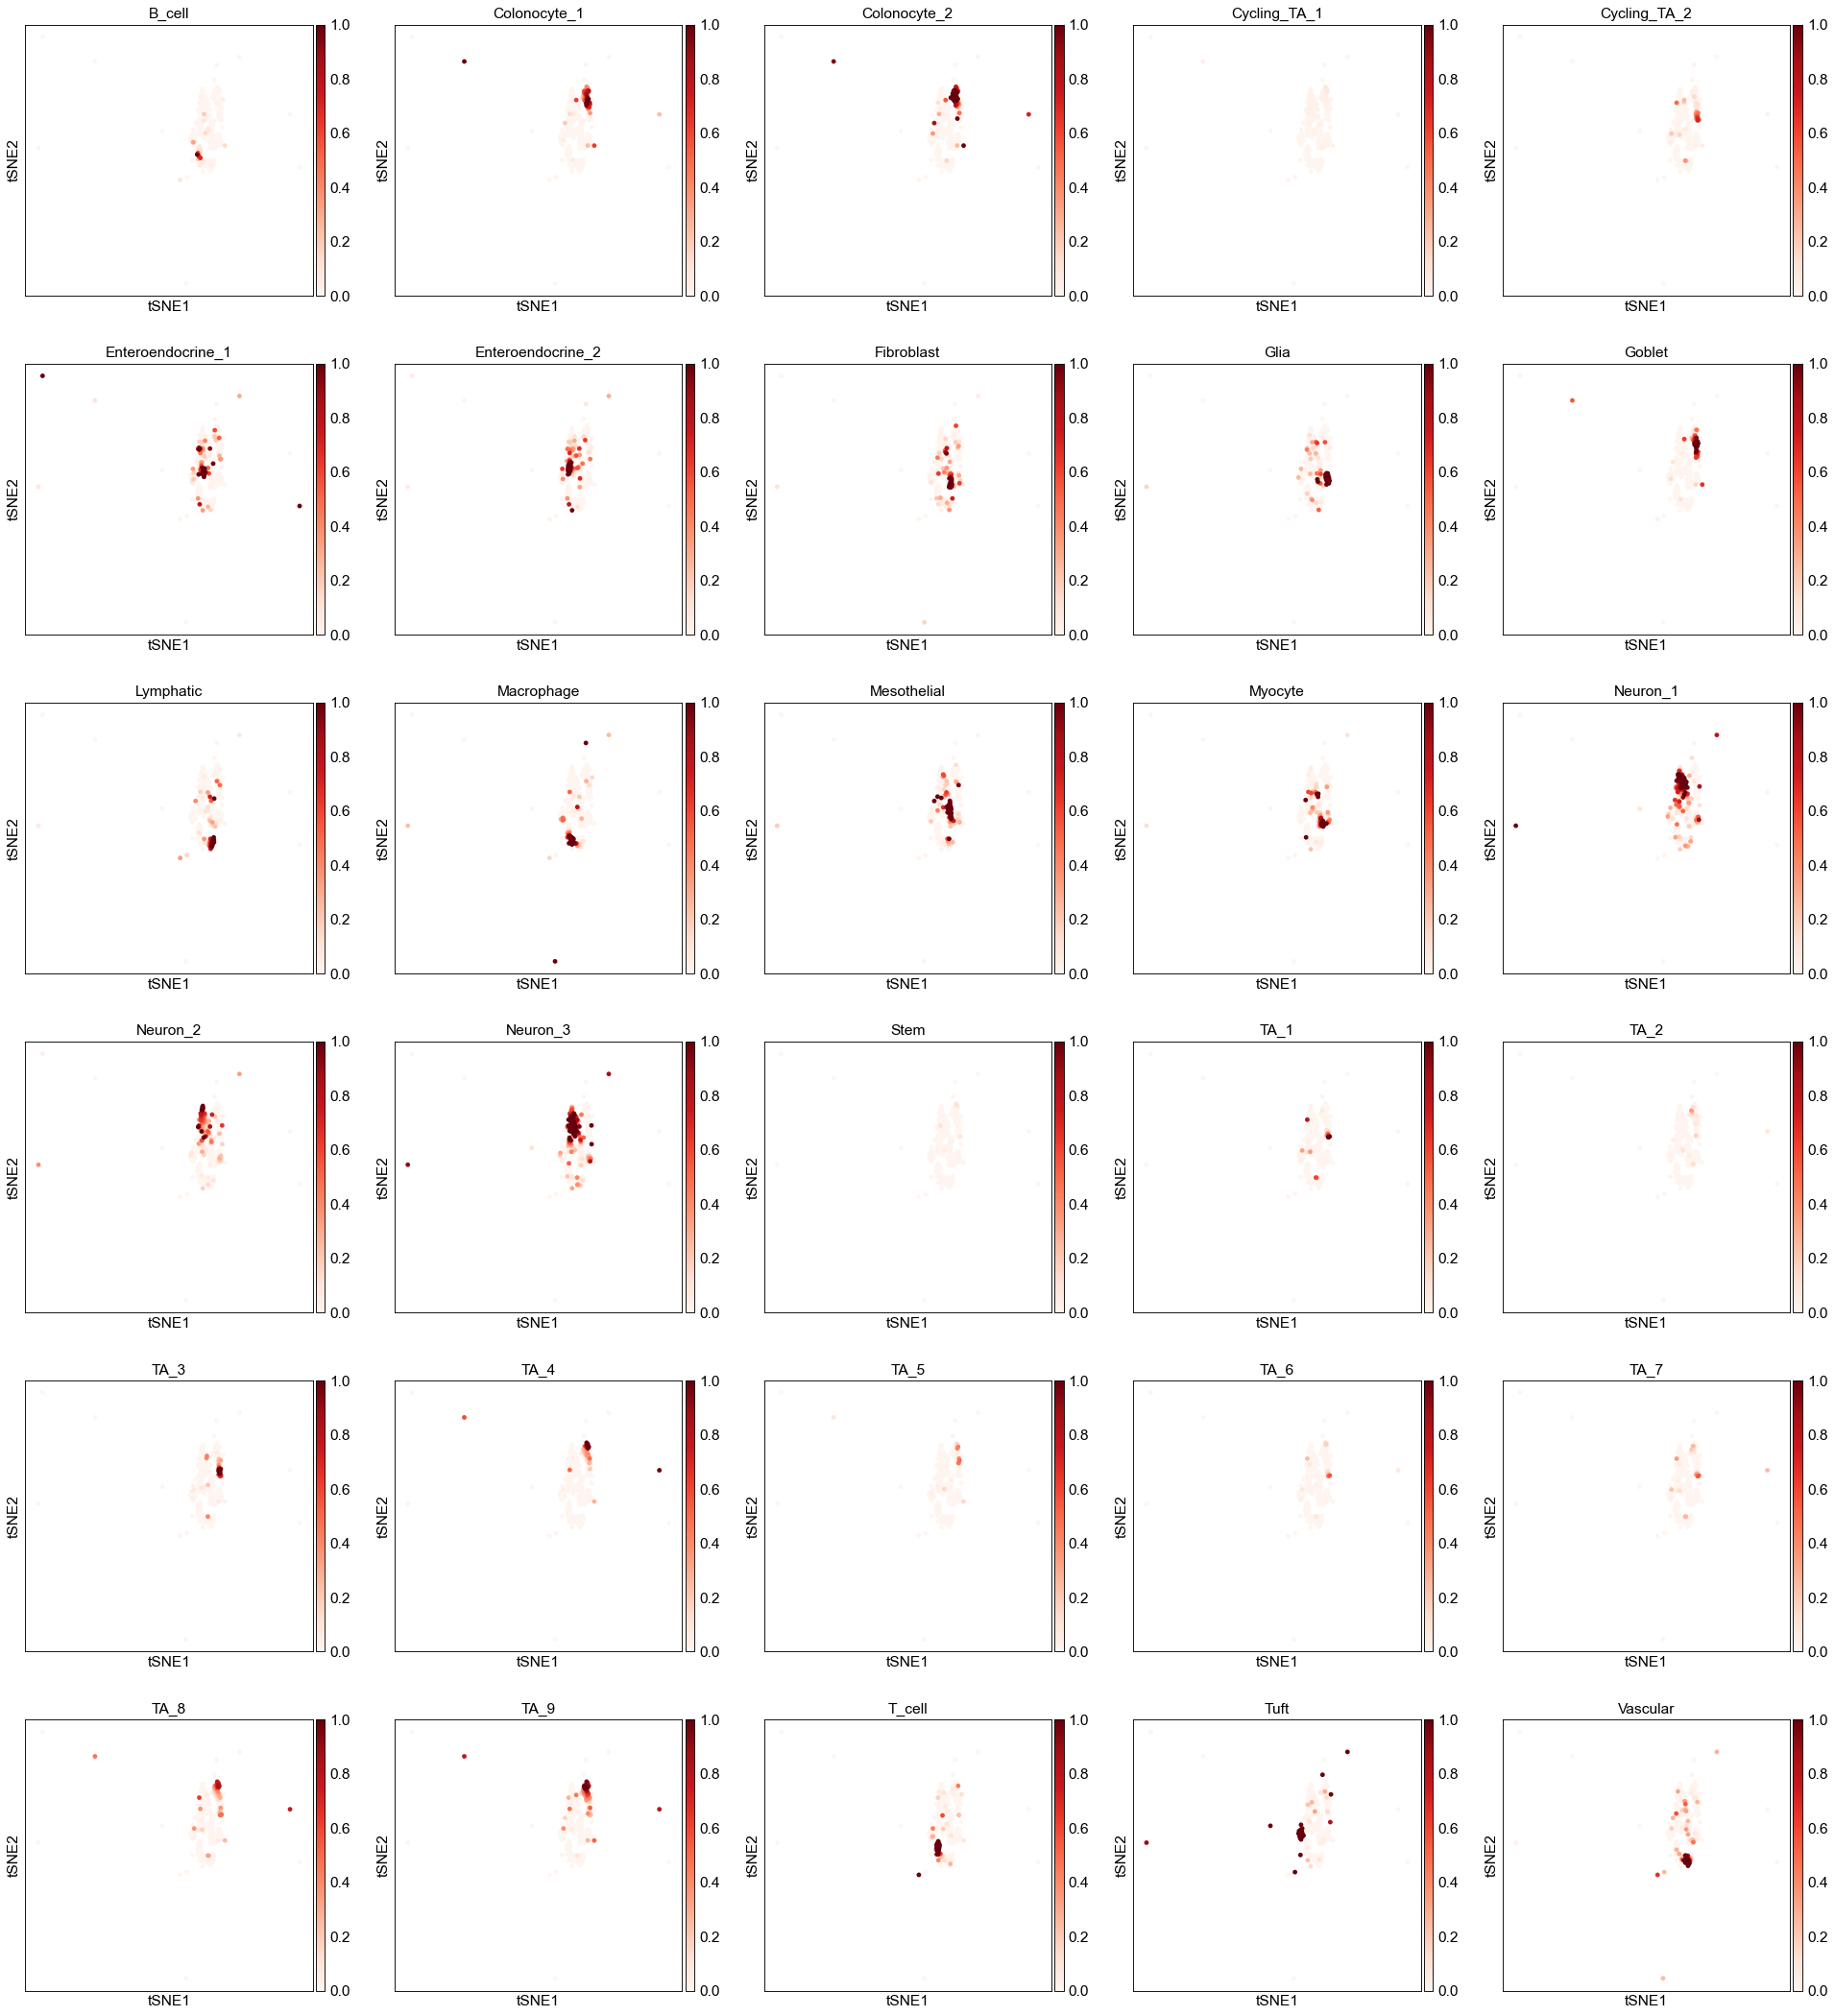

GF_crypt_apex_and_mucosa
genes in common with scRNAseq data:  5041
genes over scRNA threshold:  301
GF_crypt_apex_and_mucosa
1
GF_crypt_apex_and_mucosa
2
GF_crypt_apex_and_mucosa
3
GF_crypt_apex_and_mucosa
4
GF_crypt_apex_and_mucosa
5
GF_crypt_apex_and_mucosa
6
GF_crypt_apex_and_mucosa
7
GF_crypt_apex_and_mucosa
8
GF_crypt_apex_and_mucosa
9
GF_crypt_apex_and_mucosa
10
GF_crypt_apex_and_mucosa
11


Trying to set attribute `.obs` of view, copying.


Total tsne submodules found... 11


... storing 'st_submodule' as categorical


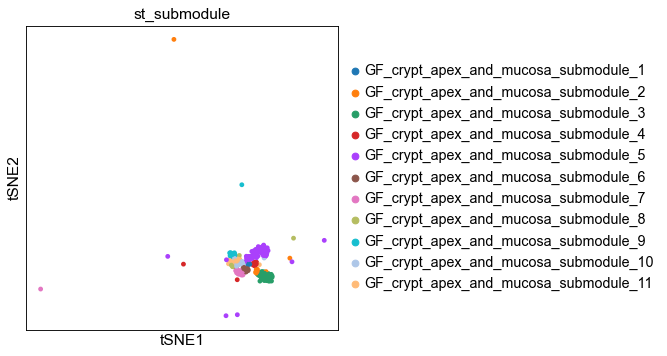

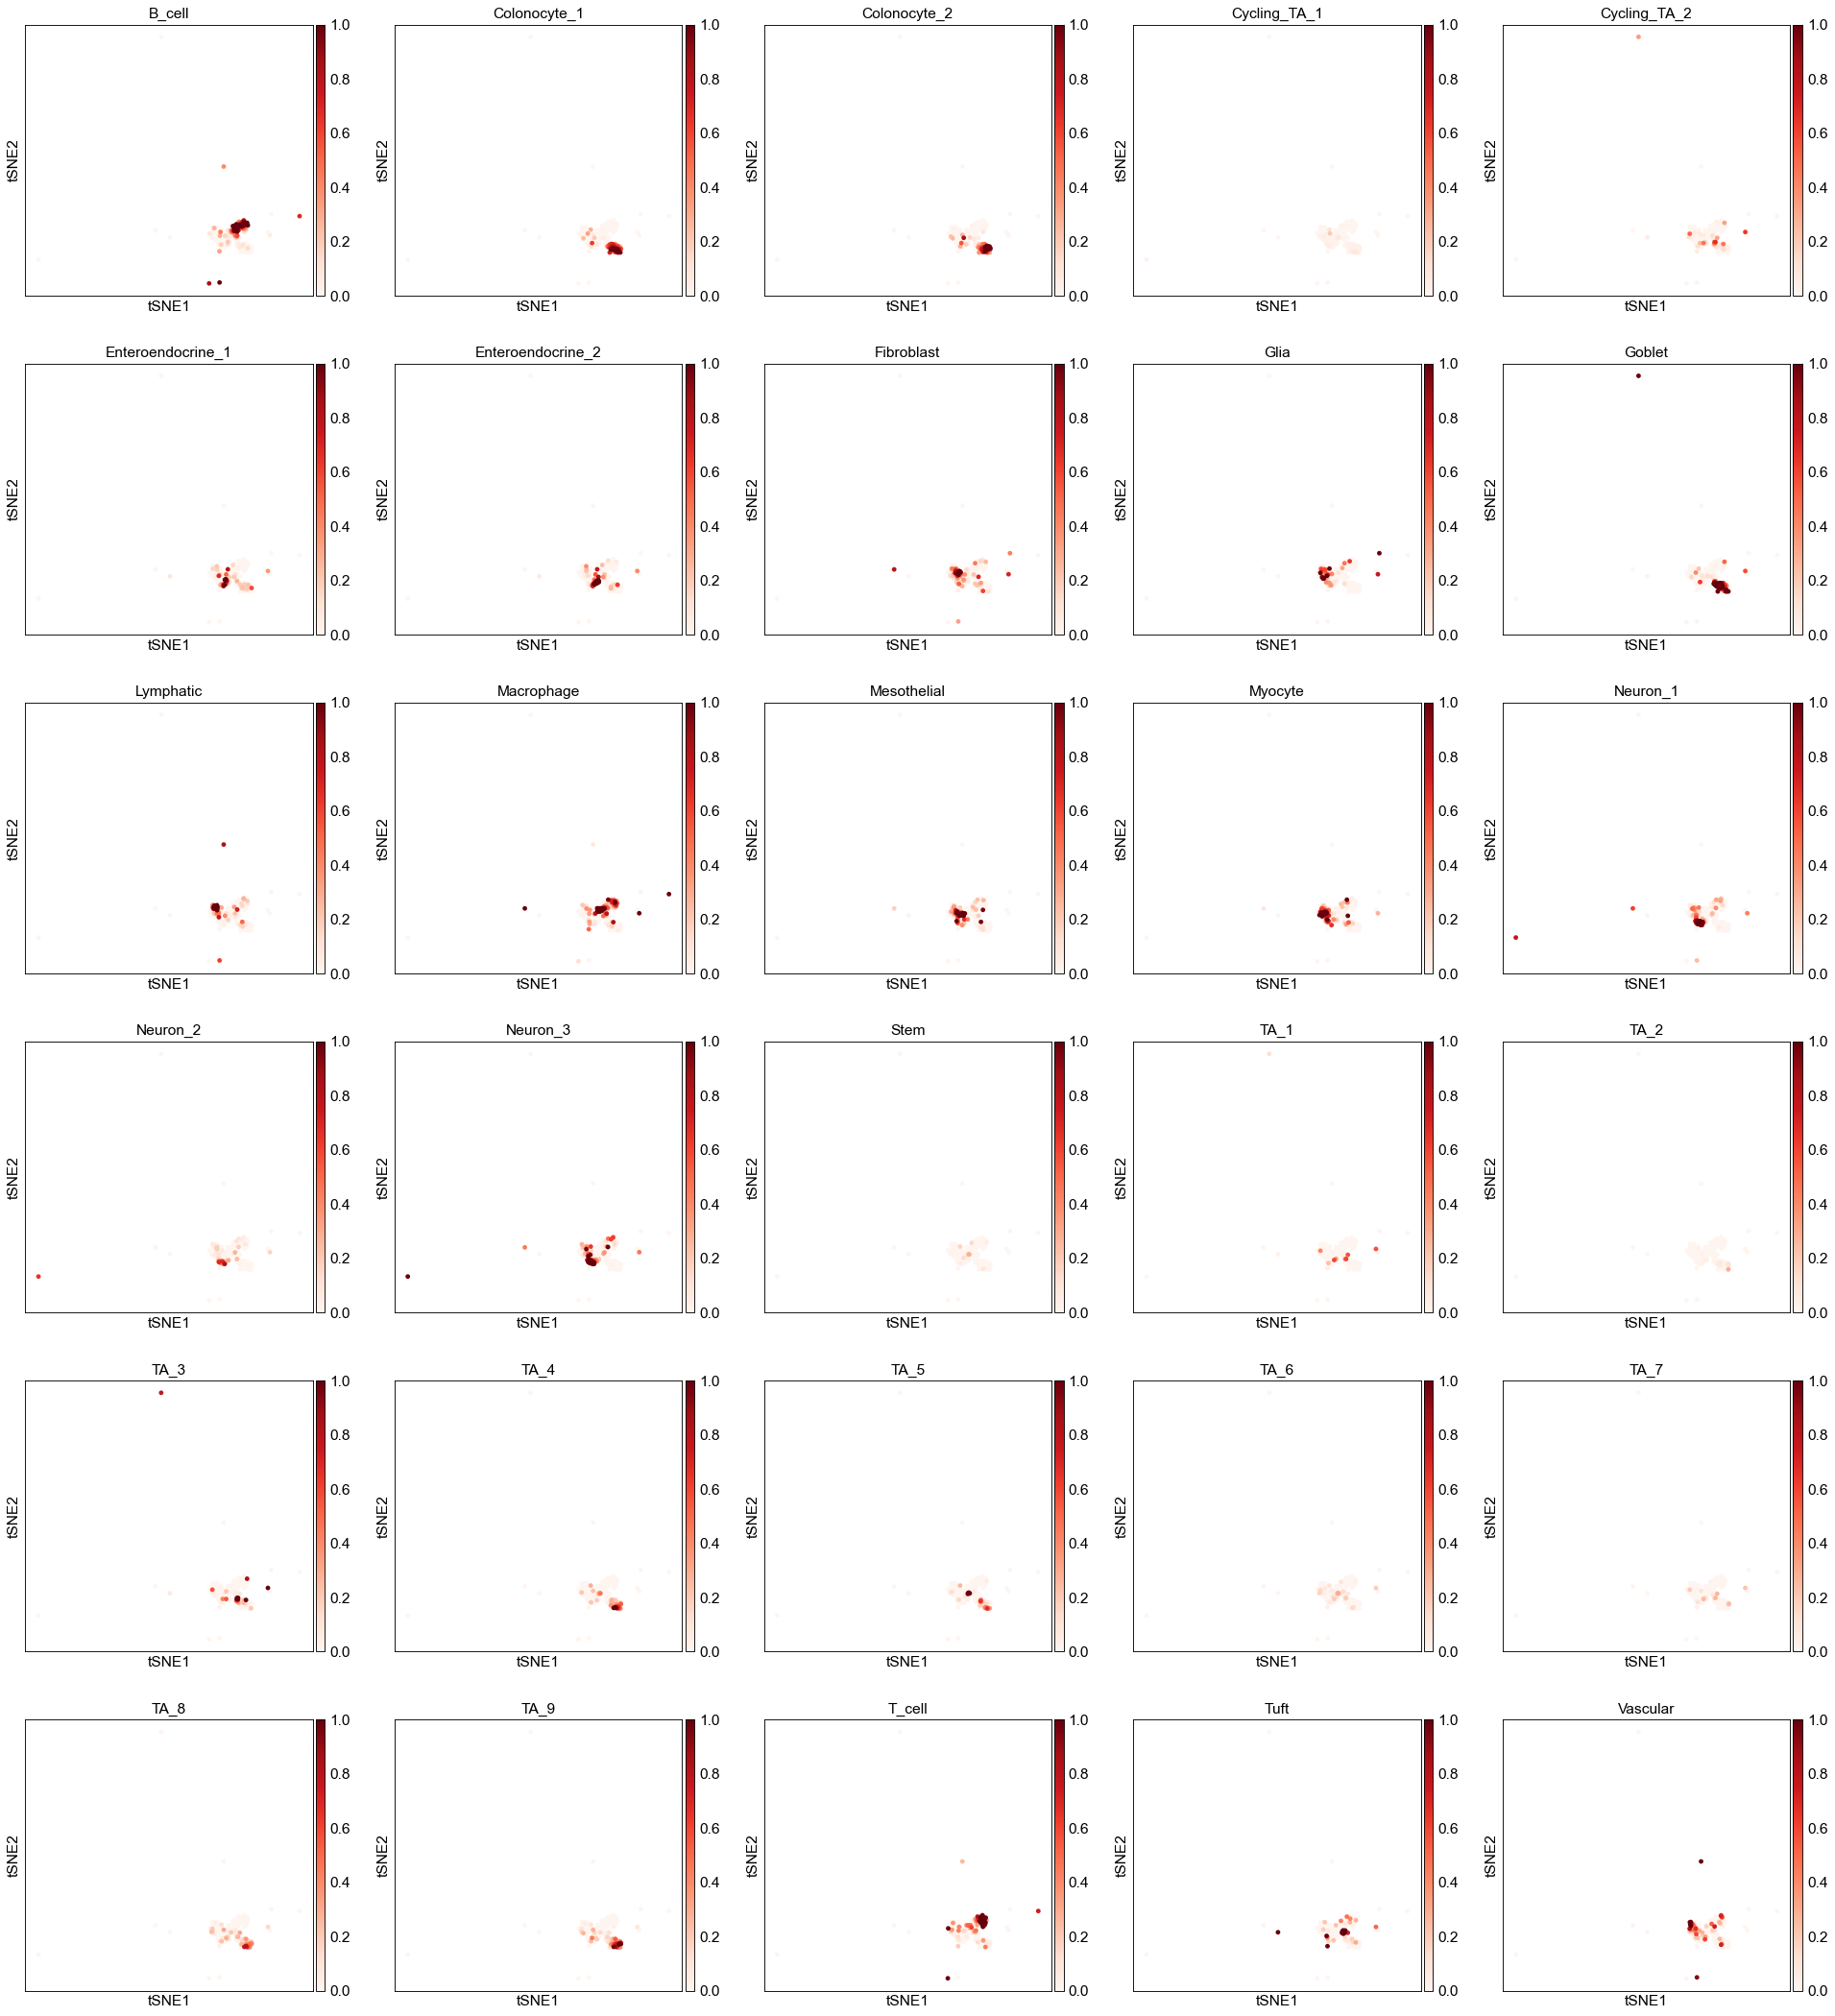

GF_crypt_base
genes in common with scRNAseq data:  6549
genes over scRNA threshold:  229
GF_crypt_base
1
GF_crypt_base
2
GF_crypt_base
3
GF_crypt_base
4
GF_crypt_base
5
GF_crypt_base
6
GF_crypt_base
7
GF_crypt_base
8
GF_crypt_base
9
GF_crypt_base
10
GF_crypt_base
11
GF_crypt_base
12


Trying to set attribute `.obs` of view, copying.


Total tsne submodules found... 12


... storing 'st_submodule' as categorical


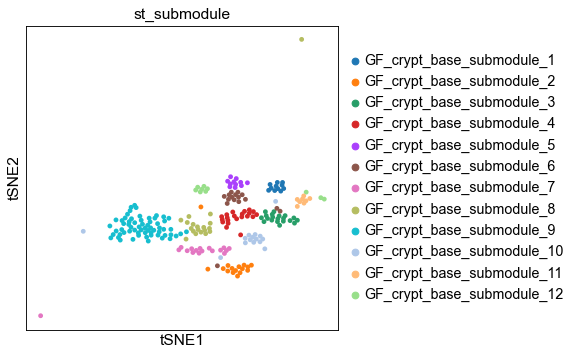

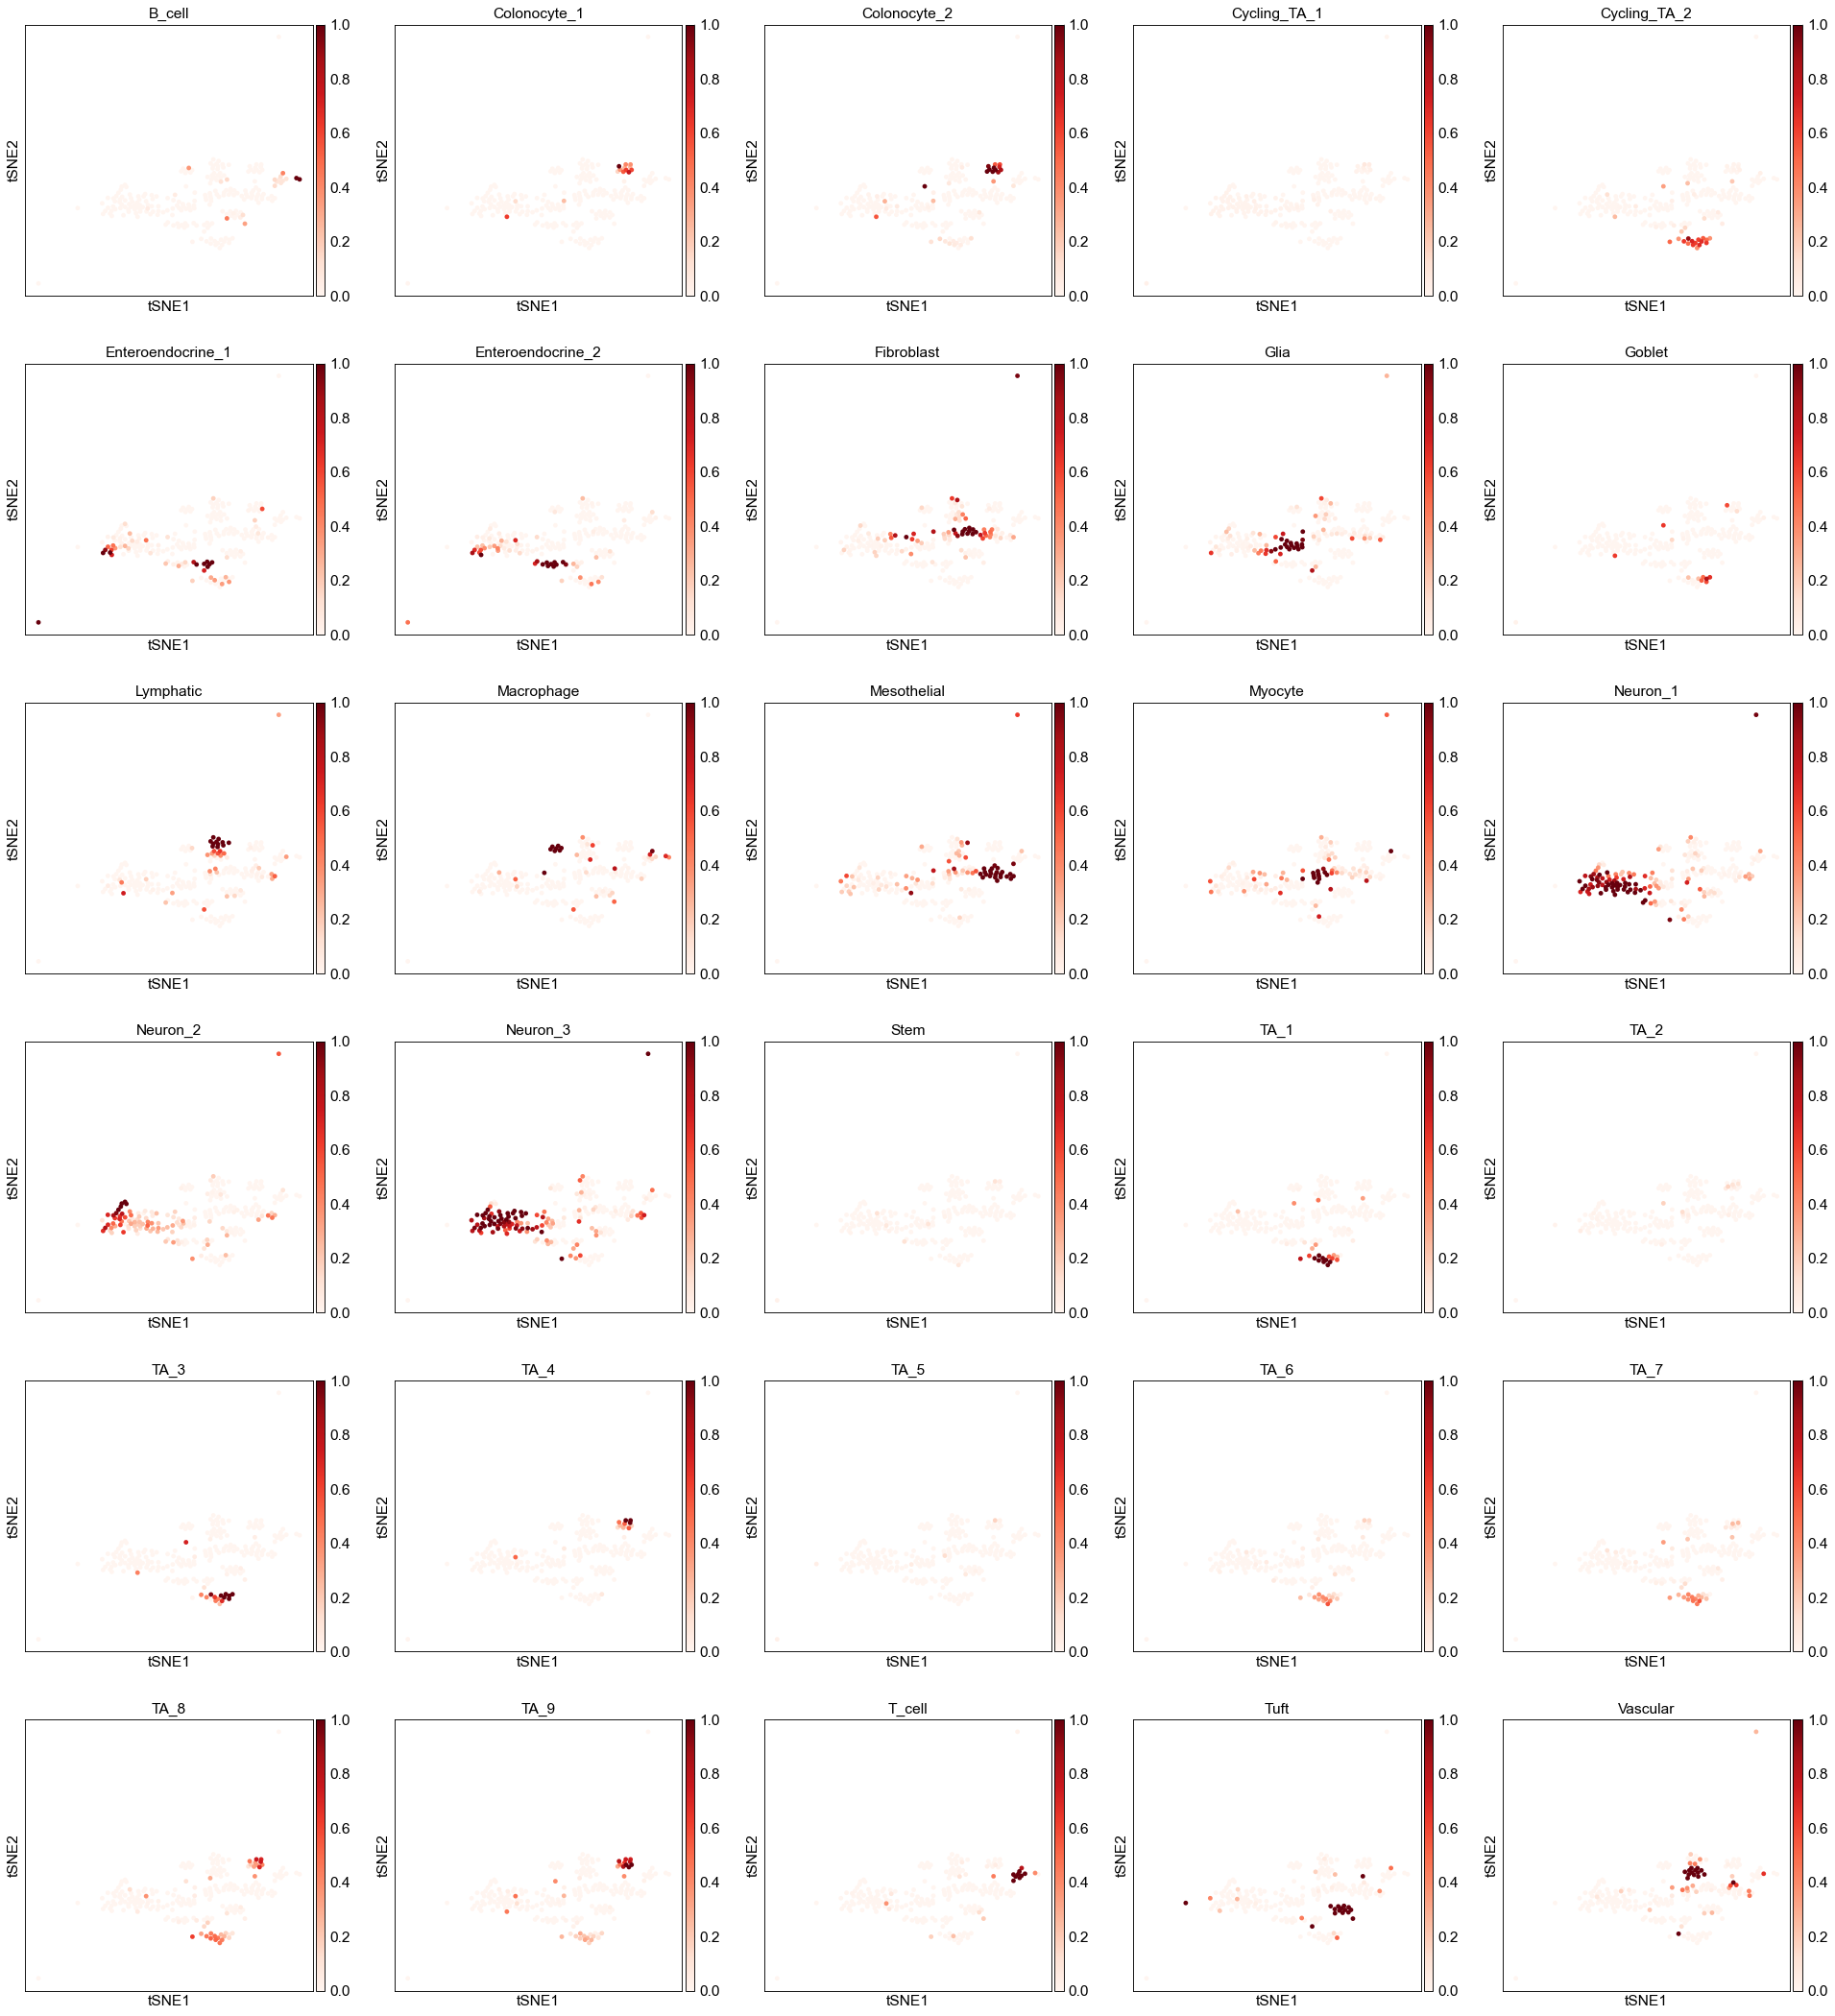

GF_crypt_mid
genes in common with scRNAseq data:  9004
genes over scRNA threshold:  319
GF_crypt_mid
1
GF_crypt_mid
2
GF_crypt_mid
3
GF_crypt_mid
4
GF_crypt_mid
5
GF_crypt_mid
6
GF_crypt_mid
7
GF_crypt_mid
8
GF_crypt_mid
9
GF_crypt_mid
10
GF_crypt_mid
11
GF_crypt_mid
12


Trying to set attribute `.obs` of view, copying.


Total tsne submodules found... 12


... storing 'st_submodule' as categorical


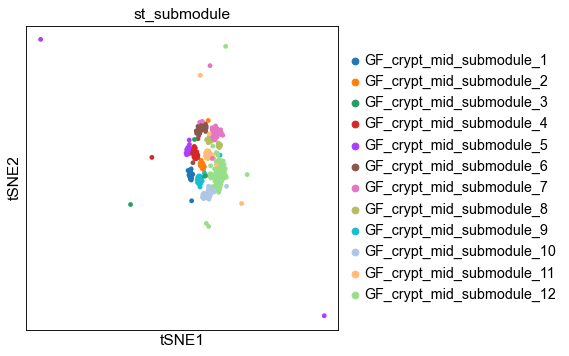

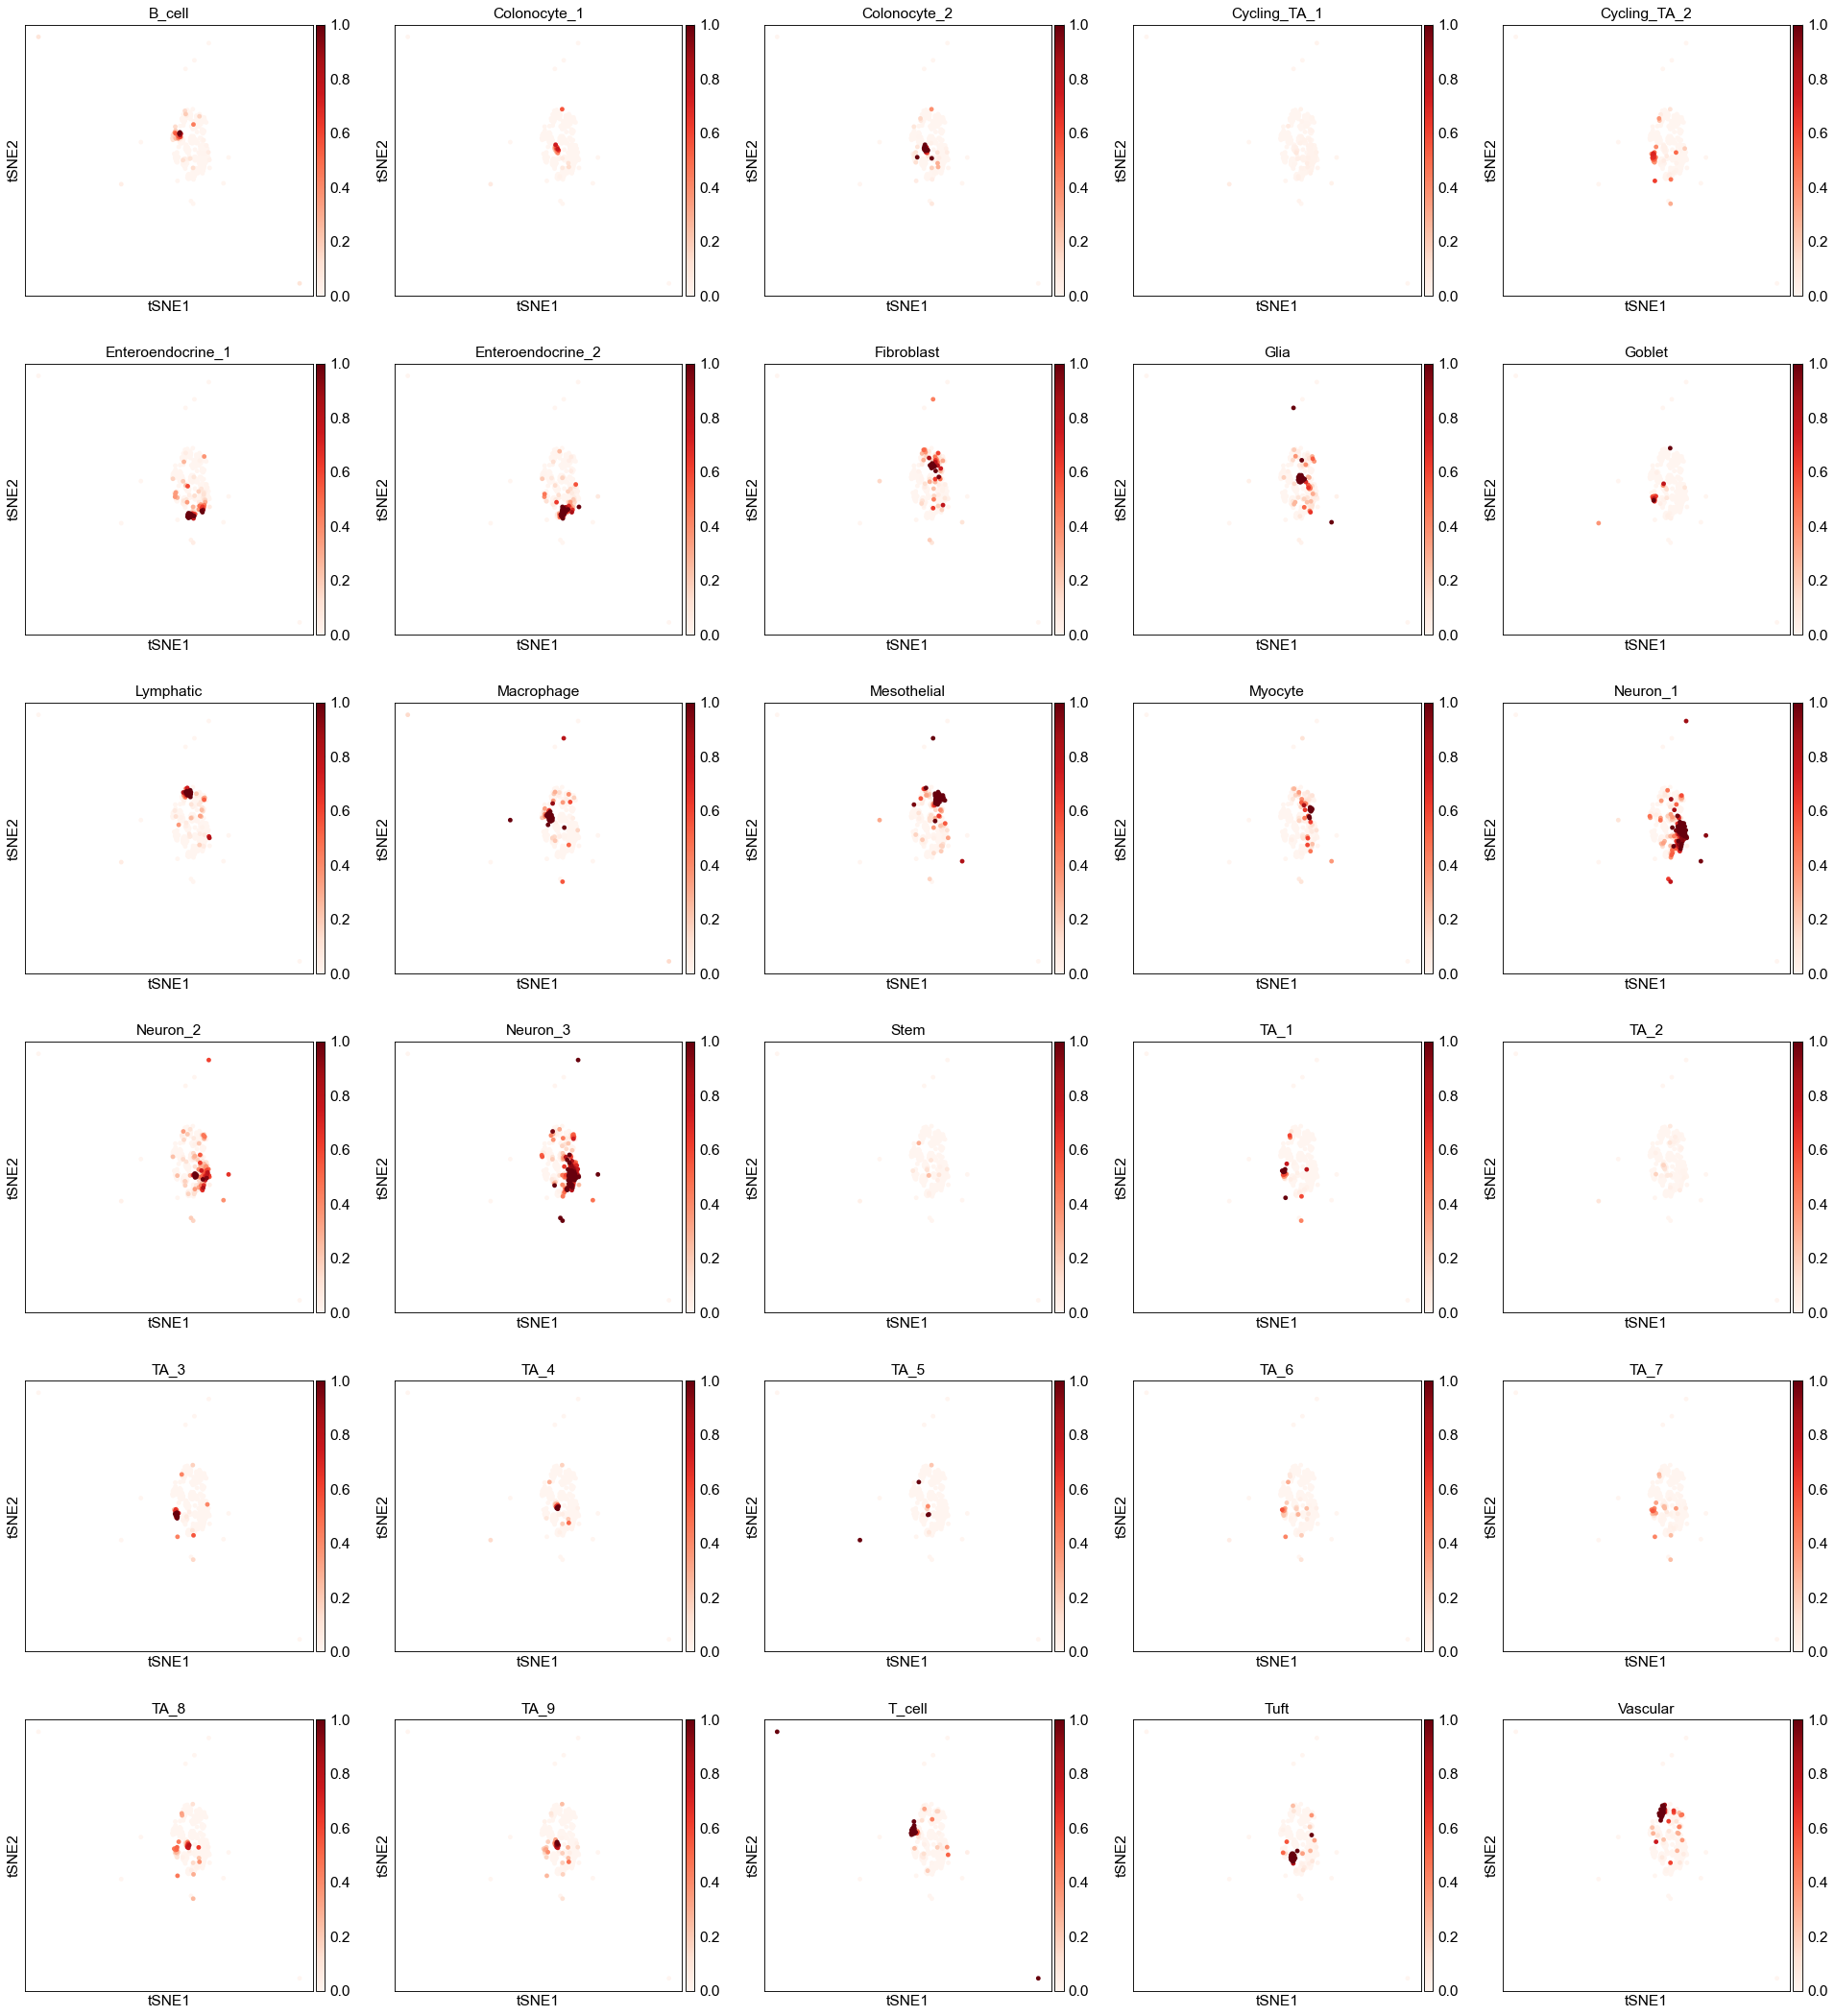

WT_crypt_apex_and_crypt_mid
genes in common with scRNAseq data:  6689
genes over scRNA threshold:  384
WT_crypt_apex_and_crypt_mid
1
WT_crypt_apex_and_crypt_mid
2
WT_crypt_apex_and_crypt_mid
3
WT_crypt_apex_and_crypt_mid
4
WT_crypt_apex_and_crypt_mid
5
WT_crypt_apex_and_crypt_mid
6
WT_crypt_apex_and_crypt_mid
7
WT_crypt_apex_and_crypt_mid
8
WT_crypt_apex_and_crypt_mid
9
WT_crypt_apex_and_crypt_mid
10
WT_crypt_apex_and_crypt_mid
11


Trying to set attribute `.obs` of view, copying.


Total tsne submodules found... 11


... storing 'st_submodule' as categorical


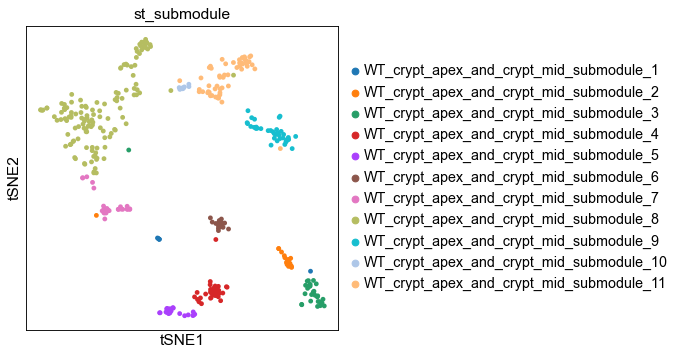

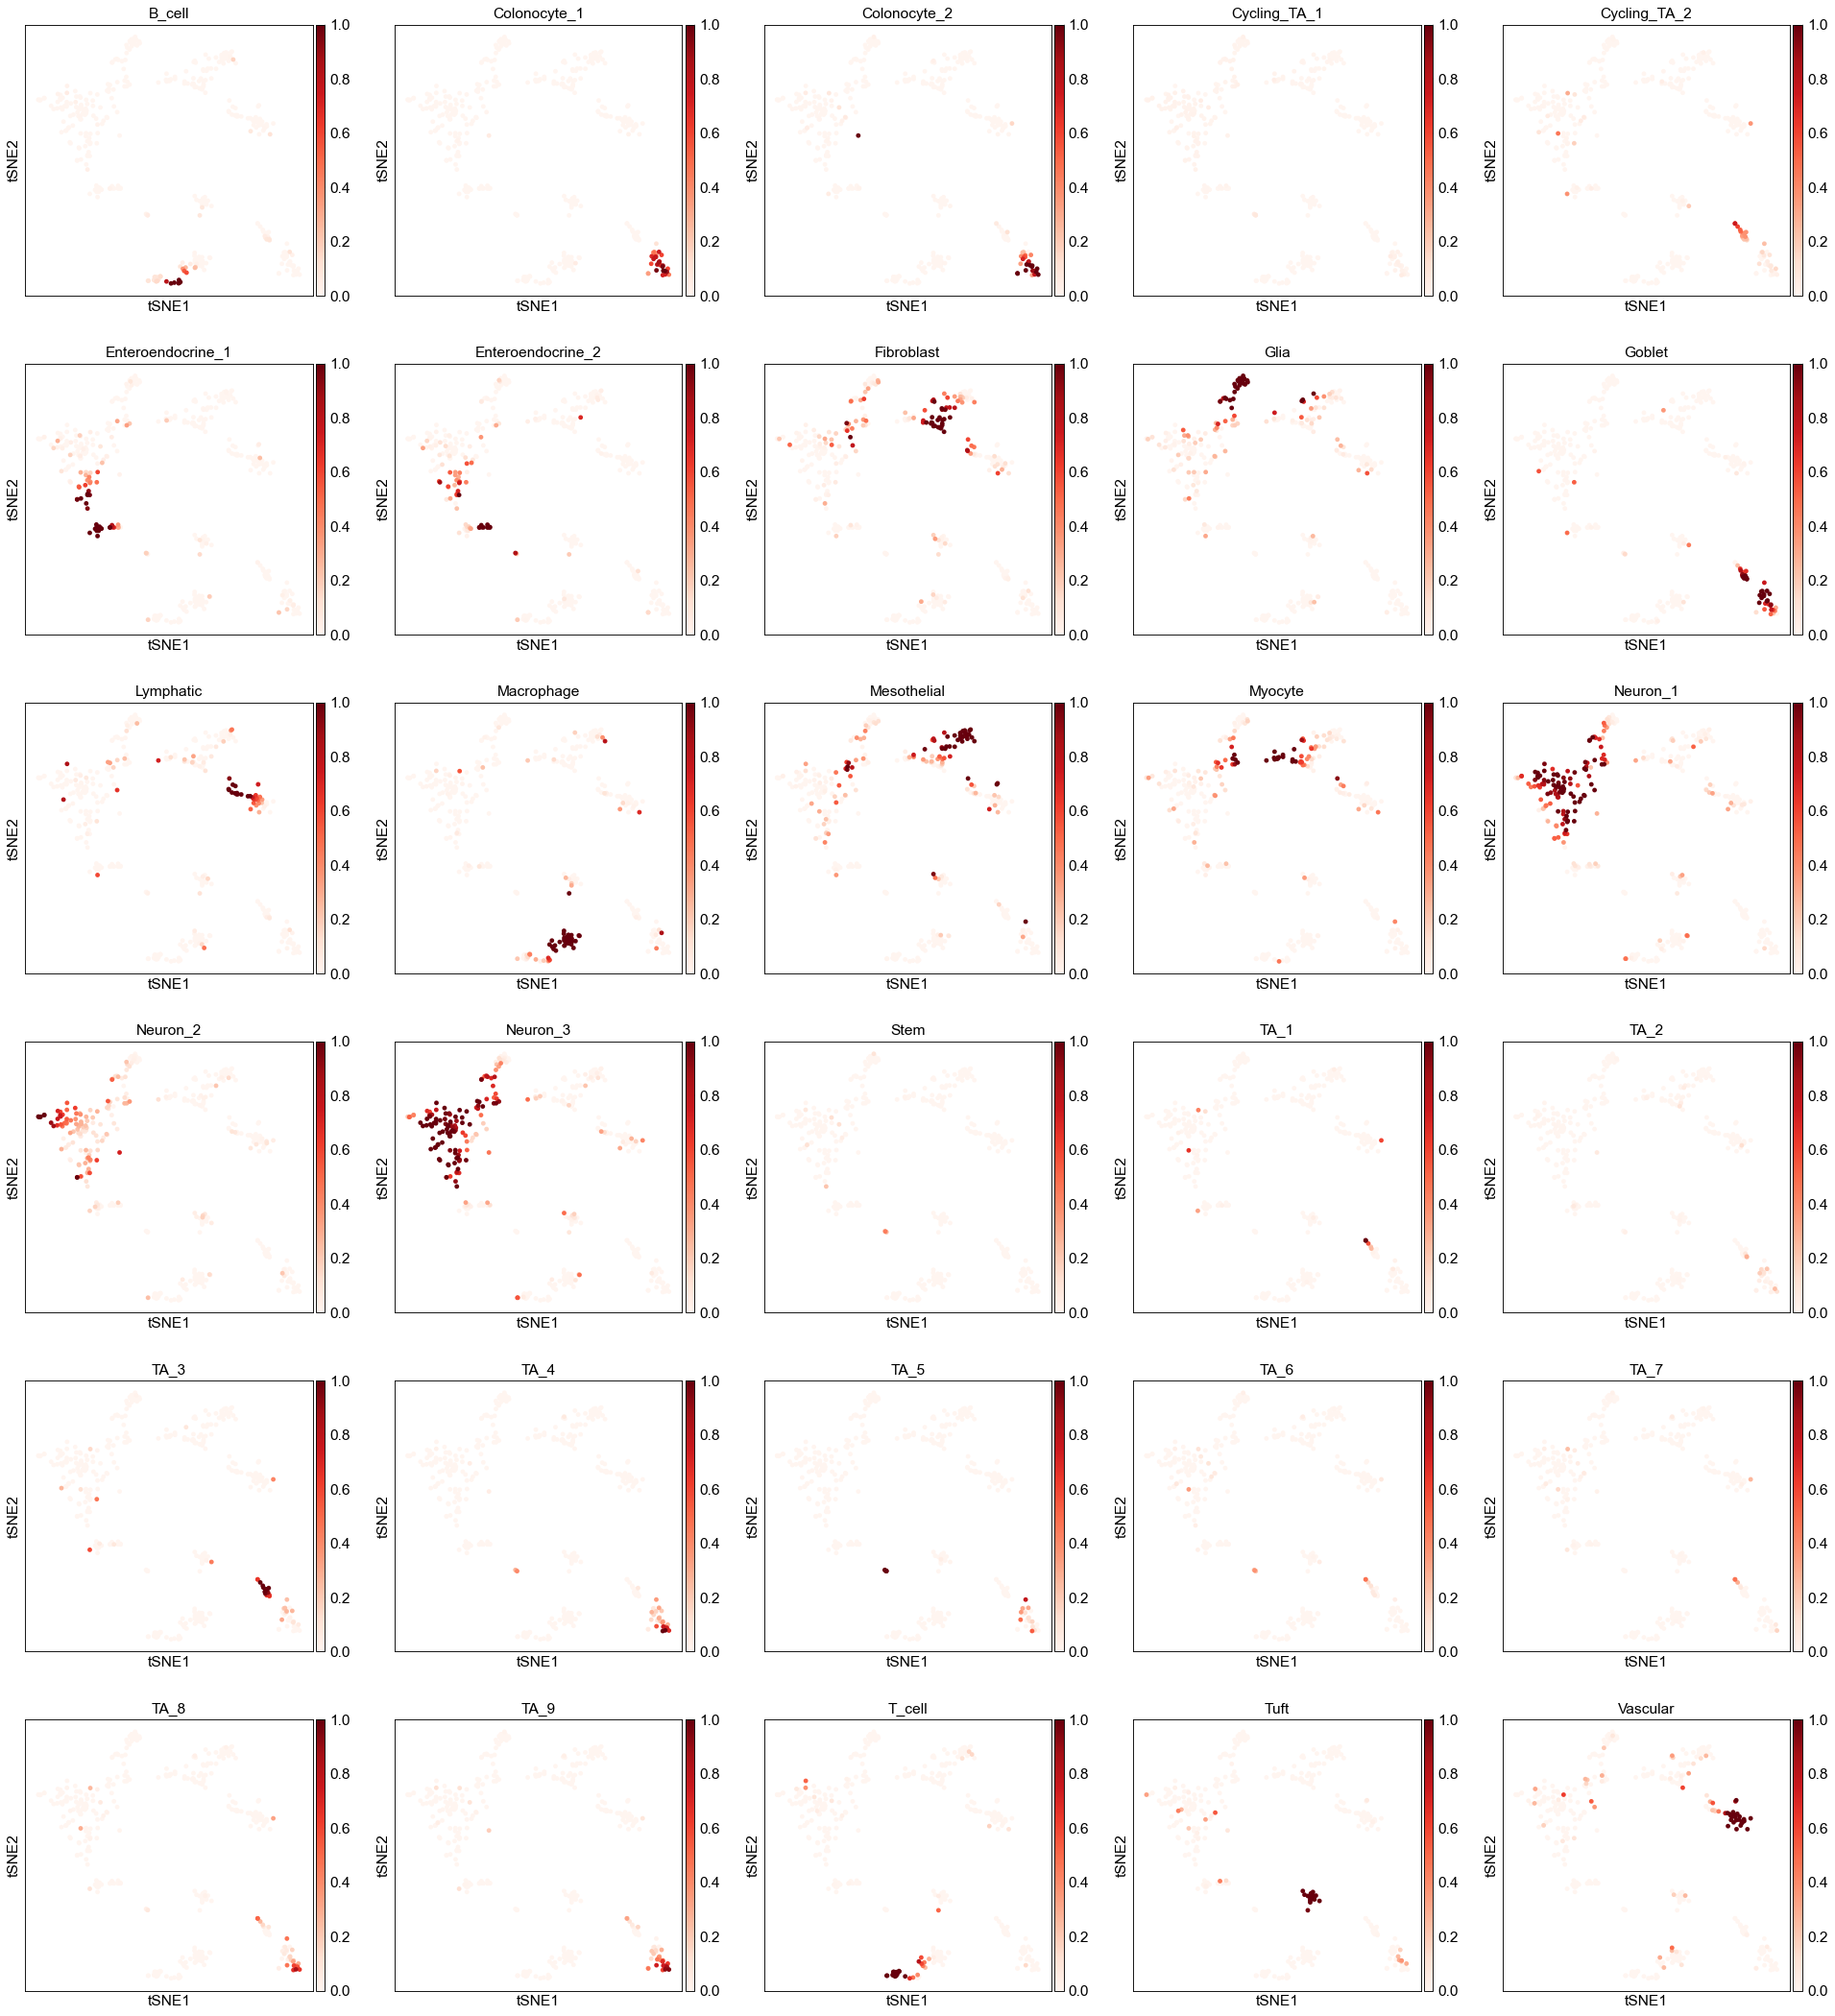

WT_crypt_apex_and_mucosa
genes in common with scRNAseq data:  4546
genes over scRNA threshold:  330
WT_crypt_apex_and_mucosa
1
WT_crypt_apex_and_mucosa
2
WT_crypt_apex_and_mucosa
3
WT_crypt_apex_and_mucosa
4
WT_crypt_apex_and_mucosa
5
WT_crypt_apex_and_mucosa
6
WT_crypt_apex_and_mucosa
7
WT_crypt_apex_and_mucosa
8
WT_crypt_apex_and_mucosa
9
WT_crypt_apex_and_mucosa
10
WT_crypt_apex_and_mucosa
11


Trying to set attribute `.obs` of view, copying.


Total tsne submodules found... 11


... storing 'st_submodule' as categorical


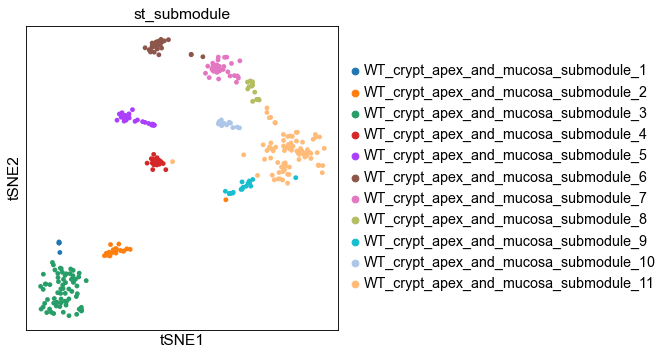

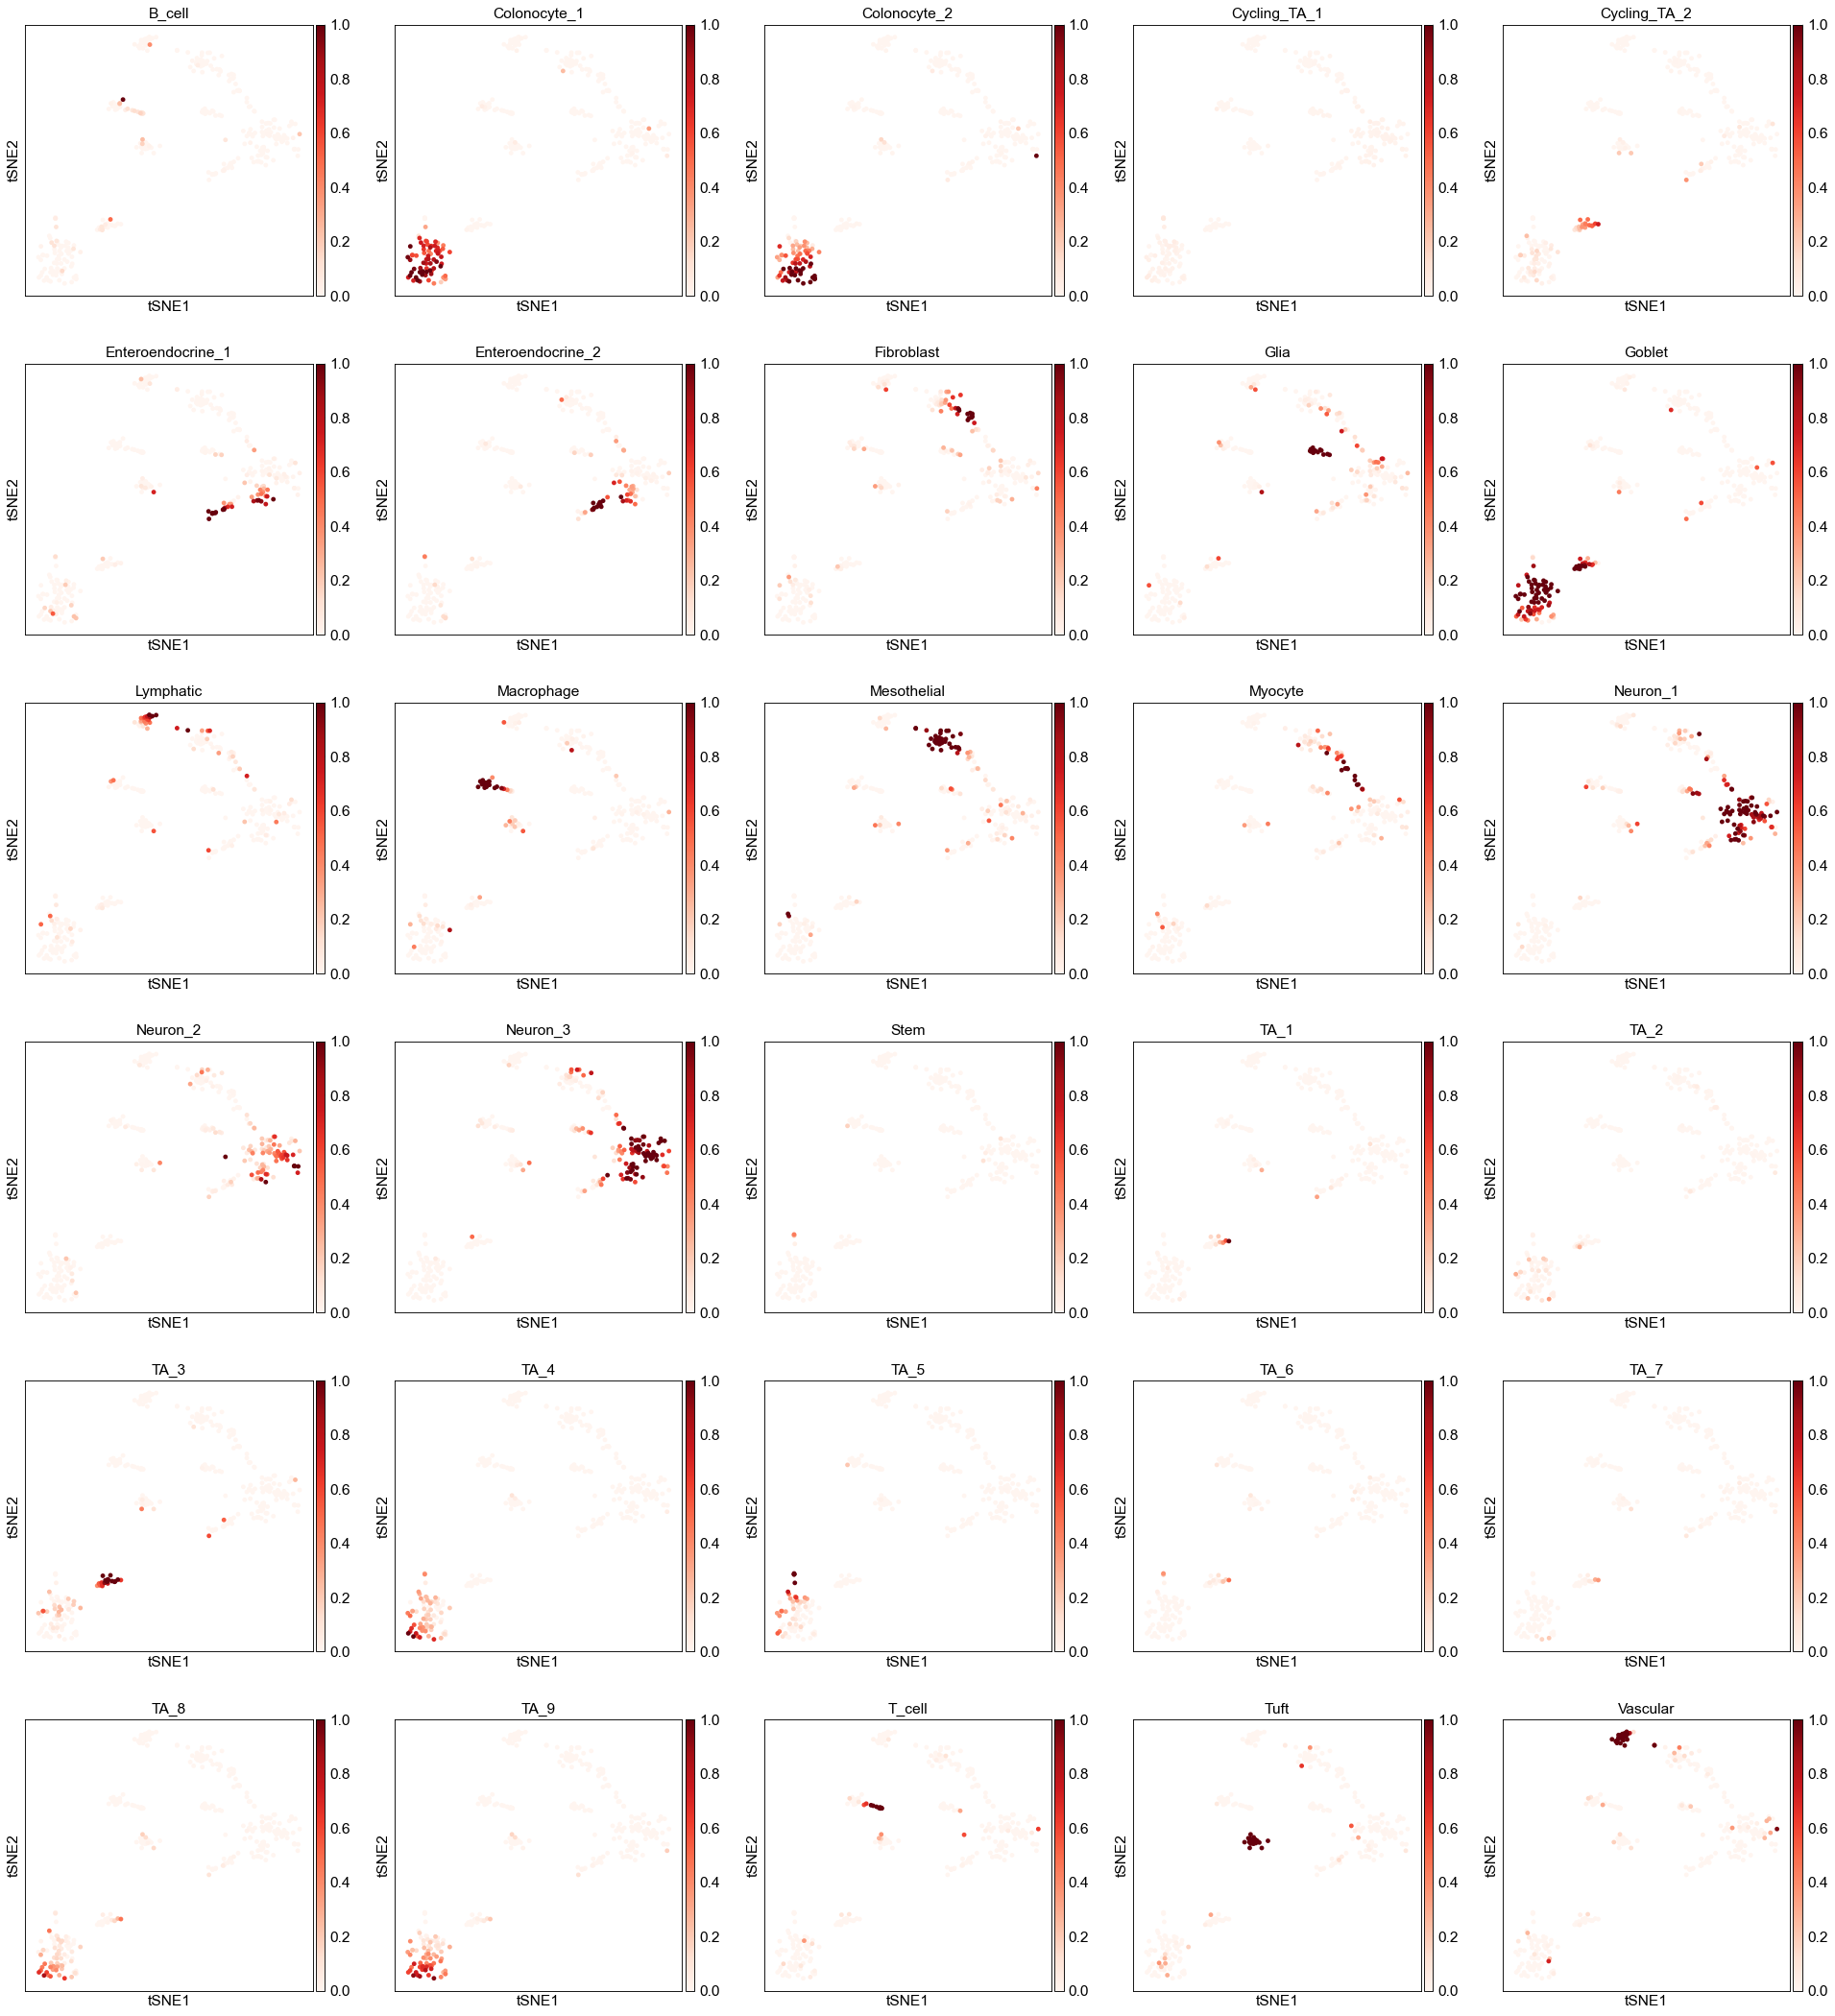

WT_crypt_base
genes in common with scRNAseq data:  8270
genes over scRNA threshold:  467
WT_crypt_base
1
WT_crypt_base
2
WT_crypt_base
3
WT_crypt_base
4
WT_crypt_base
5
WT_crypt_base
6
WT_crypt_base
7
WT_crypt_base
8
WT_crypt_base
9
WT_crypt_base
10
WT_crypt_base
11


Trying to set attribute `.obs` of view, copying.


Total tsne submodules found... 11


... storing 'st_submodule' as categorical


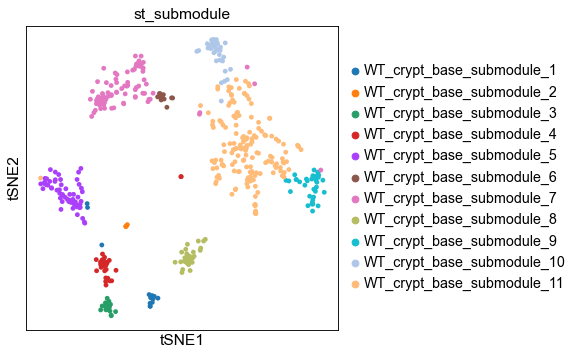

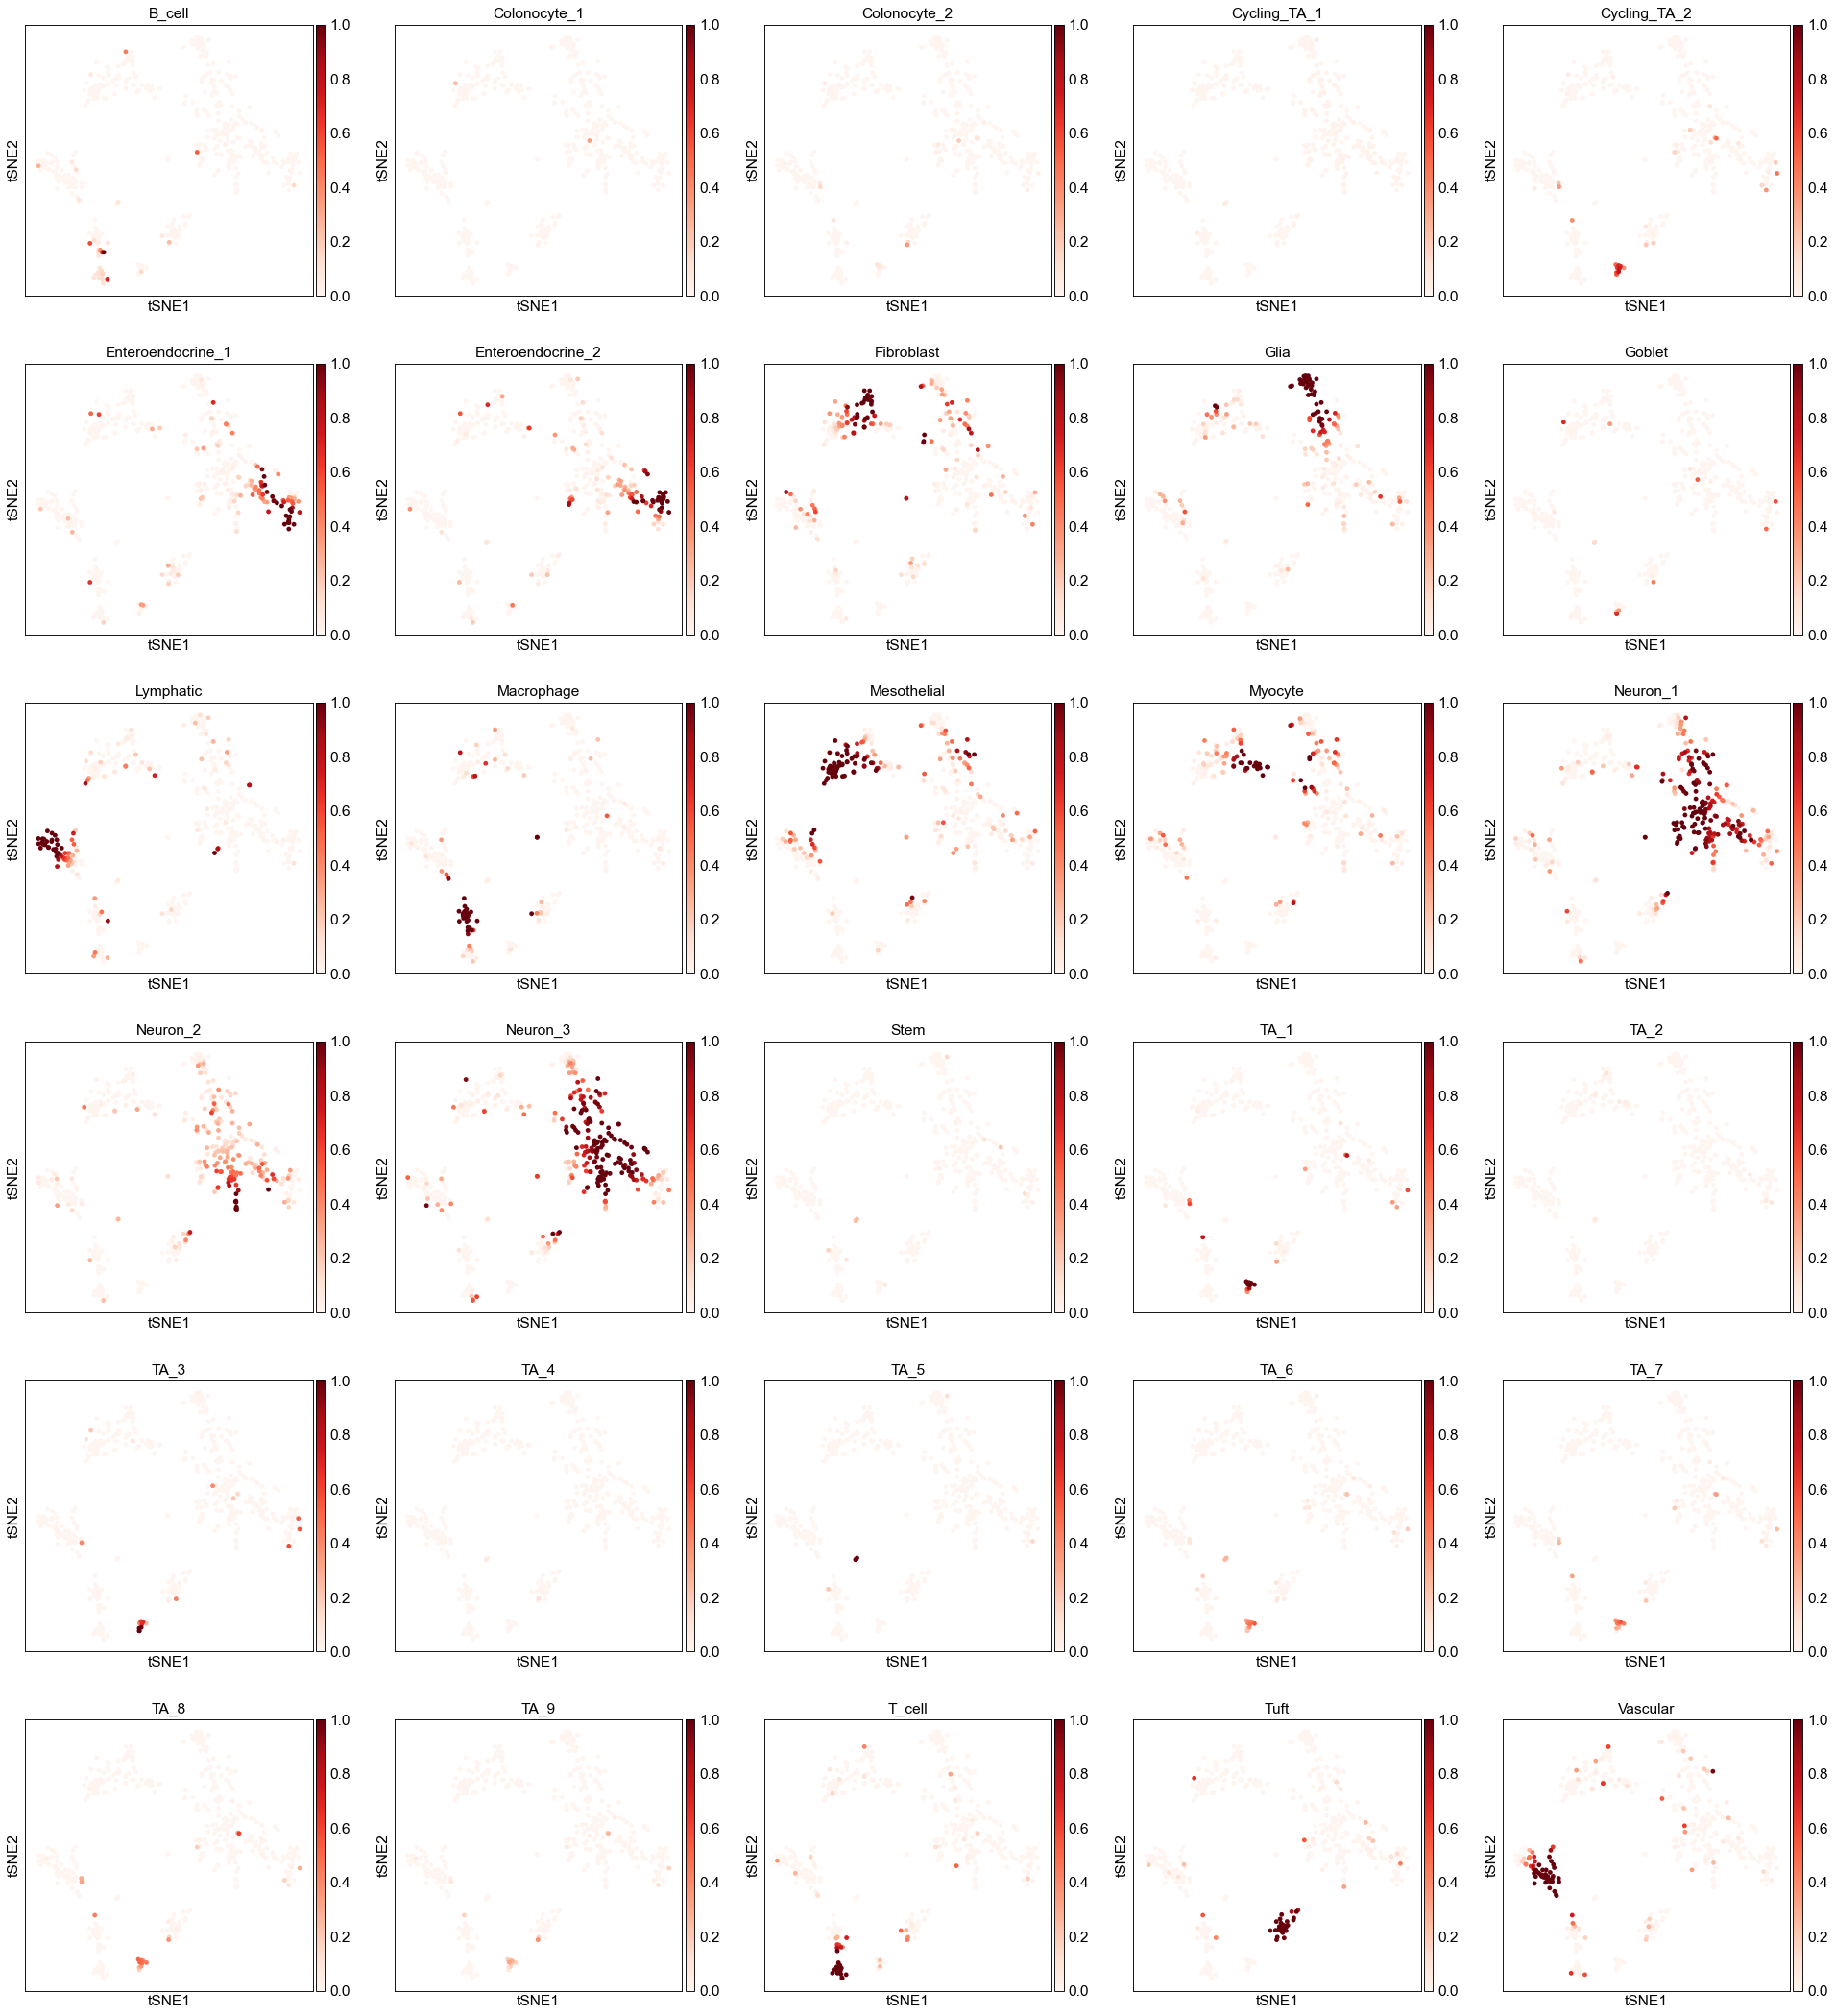

WT_crypt_mid
genes in common with scRNAseq data:  7728
genes over scRNA threshold:  343
WT_crypt_mid
1
WT_crypt_mid
2
WT_crypt_mid
3
WT_crypt_mid
4
WT_crypt_mid
5
WT_crypt_mid
6
WT_crypt_mid
7
WT_crypt_mid
8
WT_crypt_mid
9
WT_crypt_mid
10
WT_crypt_mid
11


Trying to set attribute `.obs` of view, copying.


Total tsne submodules found... 11


... storing 'st_submodule' as categorical


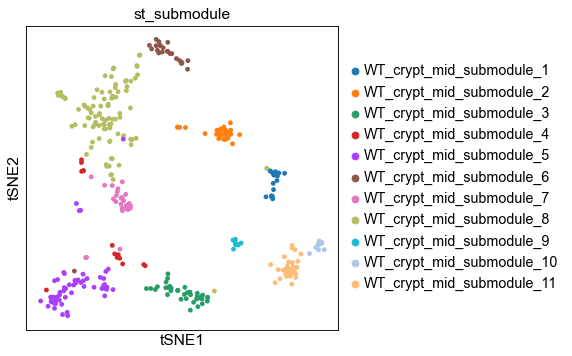

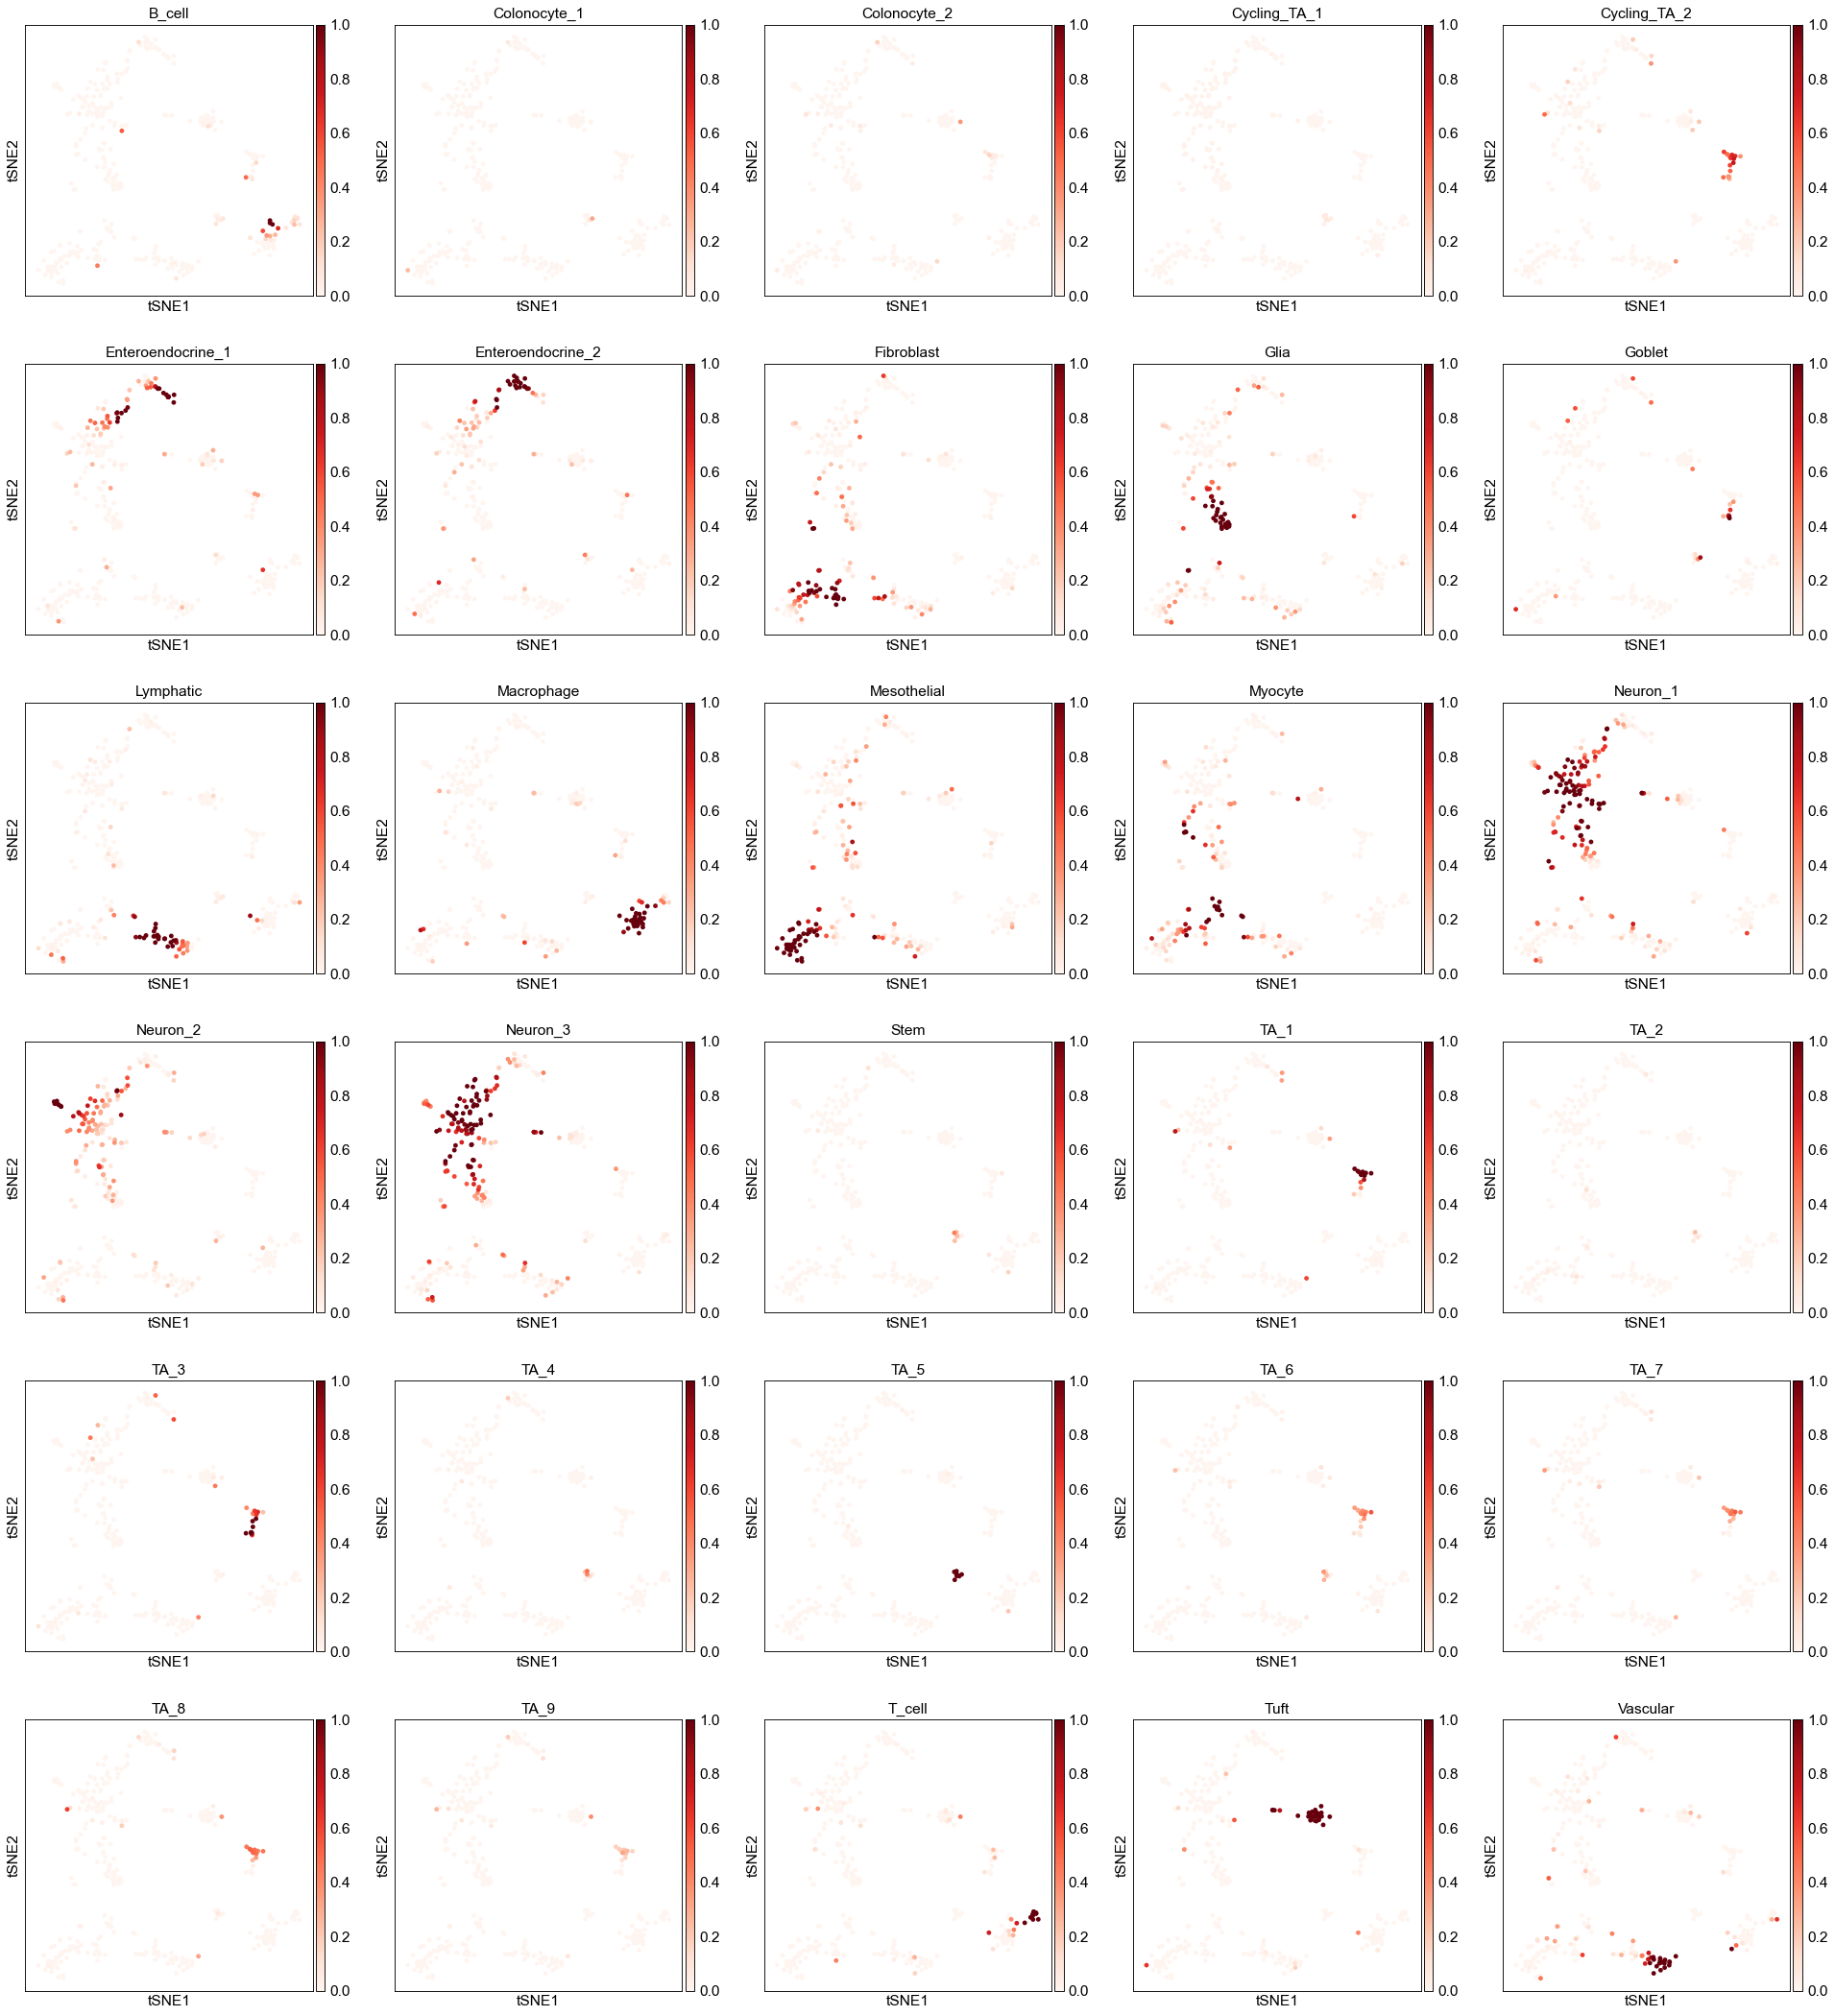

In [86]:
group_names_st_clusters = pheno_kegg_clustering(st_splotch_pd_copy, key = 'pheno', 
                                                single_cell_df = sc_data_pd, color_threshold = 0.6, 
                                                sc_cutoff = 1, tsne = 'yes')


#### Generate Excel spreadsheet containing the KEGG results

In [87]:
generate_kegg_spreadsheet(group_names_st_clusters, file_prefix = "Pheno", output_file_name = 'Pheno_ST_clusters_KEGG_summary.xlsx')


#### Generate Excel spreadsheet containing submodule information

In [88]:
generate_submodules_spreadsheet(group_names_st_clusters, file_prefix = "Pheno", output_file_name = 'Pheno_ST_clusters_KEGG_submodule.xlsx')


#### Add KEGG results to anndata object

In [89]:
module_names_ann = kegg2anndata(st_splotch_pd_copy, key = 'pheno', xl = 'Pheno_ST_clusters_KEGG_summary.xlsx')


pheno_kegg_modules


#### Add KEGG submodules to anndata object 

In [90]:
kegg_submodules2anndata(st_splotch_pd_copy, key = 'pheno', xl = 'Pheno_ST_clusters_KEGG_summary.xlsx', real_module_names = module_names_ann)


pheno_kegg_submodules


[]

#### Add module and submodule gene information to anndata object

In [91]:
modules2anndata(st_splotch_pd_copy,  key = 'pheno', xl = 'Pheno_ST_clusters_KEGG_submodule.xlsx', real_module_names = module_names_ann)


#### Visualize submodule-level KEGG results

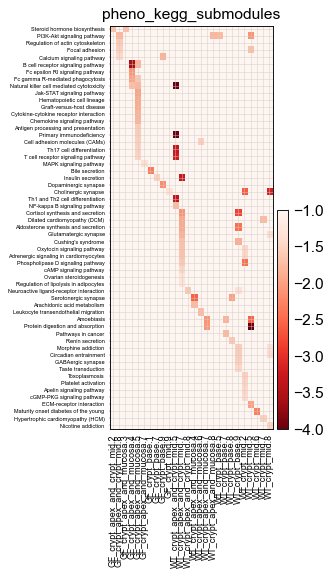

In [93]:
heatmap_kegg_submodules(st_splotch_pd_copy, key = 'pheno', values = 'pvals',)


## Plot gene rasters

Subsetting to minor ROIs...
Subsetting to specific genotype...
0.0 64.79
Ceacam20


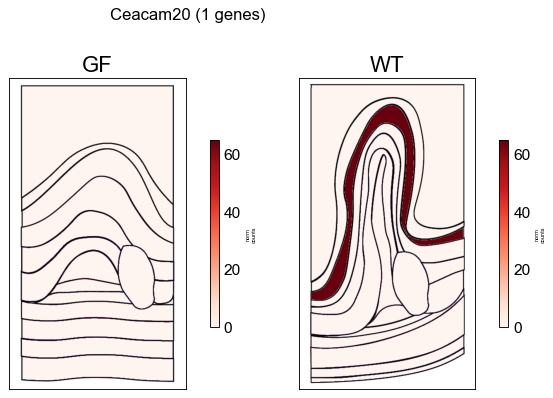

In [94]:
plot_tissue_rasters_bac(st_splotch_pd_copy,  vmin1 = 0, gene = ['Ceacam20'], plot_type = 'minor', region = ['GF','WT'],
                       )

Subsetting to minor ROIs...
Subsetting to specific genotype...
0.0 38.997499999999995
Tacr1


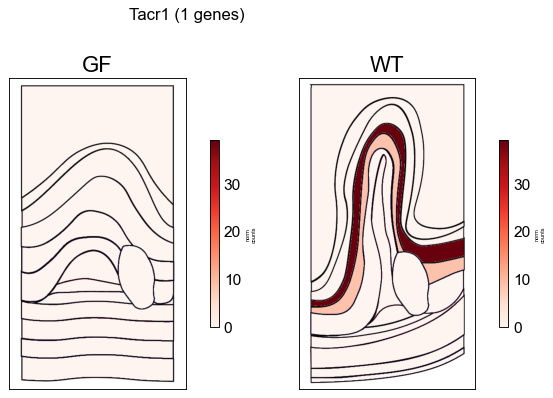

In [95]:
plot_tissue_rasters_bac(st_splotch_pd_copy,  vmin1 = 0, gene = ['Tacr1'], plot_type = 'minor', region = ['GF','WT'],)

Subsetting to minor ROIs...
Subsetting to specific genotype...
0.0 15.808
Chat


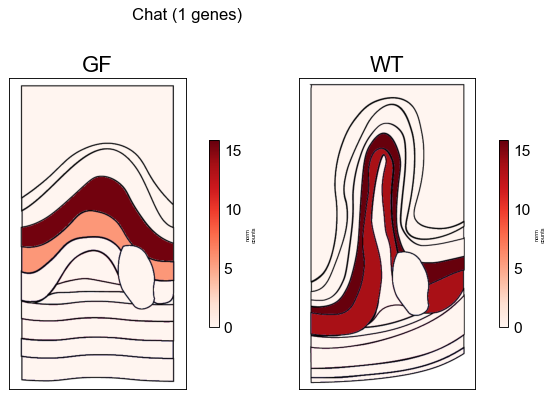

In [96]:
plot_tissue_rasters_bac(st_splotch_pd_copy, vmin1 = 0, gene = ['Chat'], plot_type = 'minor', region = ['GF','WT'],)

Subsetting to minor ROIs...
Subsetting to specific genotype...
0.0 47.158
Sema4f


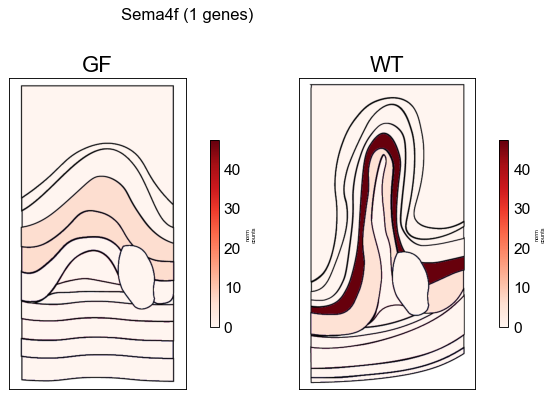

In [97]:
plot_tissue_rasters_bac(st_splotch_pd_copy,  vmin1 = 0, gene = ['Sema4f'], plot_type = 'minor', region = ['GF','WT'],)